In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

In [2]:
models = ['PDBbind_minimized_v18_subset','PLANet_v18', 'PDBbind_minimized_v18_subset_union_PLANet_v18']
tps = ['cmx', 'lig_alone']

In [3]:
test_dir = '/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/test_result'

# PDBbind hold out 2019

In [4]:
PDBbind_whole_property = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/distribution/property/PDBbind_whole.csv', sep='\t')
PDBbind_whole_property

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
0       3zzf      0.40  187.151 -3.2289   5.0  1.0  5.0 -2.0  13.0
1       3gww      0.45  310.339  3.4088   6.0  1.0  1.0  1.0  22.0
2       1w8l      0.49  141.214  1.2648   0.0  0.0  1.0  0.0  10.0
3       3fqa      0.49  136.130 -0.3677   1.0  1.0  3.0 -1.0  10.0
4       1zsb      0.60  222.251 -0.8561   2.0  2.0  6.0  0.0  13.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17174   7cpa     13.96  580.574  2.5536  14.0  2.0  8.0 -2.0  41.0
17175   2xuf     14.39  658.854  8.6355  12.0  3.0  8.0  0.0  50.0
17176   1avd     15.00  243.308 -0.5379   5.0  2.0  4.0 -1.0  16.0
17177   2xui     15.00  658.854  8.6355  12.0  3.0  8.0  0.0  50.0
17178   2avi     15.22  243.308 -0.5379   5.0  2.0  4.0 -1.0  16.0

[17179 rows x 9 columns]

In [236]:
PDBbind_hold = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PDBbind_subset/PDBbind_hold_out_2019_subset.csv',  sep='\t')
# PDBbind_hold_prop = pd.merge(PDBbind_whole_property, PDBbind_hold, on=['pdb_id', '-logAffi'])
PDBbind_hold_prop = PDBbind_whole_property[PDBbind_whole_property['pdb_id'].isin(PDBbind_hold['pdb_id'])].copy()
PDBbind_hold_prop

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
168     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0
242     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0
652     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0
655     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0
666     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17025   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17032   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17049   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0
17073   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0
17083   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0

[485 rows x 9 columns]

In [9]:
PDBbind_hold_prop[PDBbind_hold_prop['HA']<60]

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
168     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0
242     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0
652     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0
655     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0
666     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17025   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17032   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17049   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0
17073   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0
17083   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0

[485 rows x 9 columns]

# 1. metrics

In [10]:
mean_pred_df = pd.DataFrame.from_dict({})
label_to_res_dict = defaultdict(list)
for model in models:
    for tp in tps:
        res_df = pd.read_csv(f'{test_dir}/test_on_PDBbind_hold_out_2019/{model}_{tp}/test.csv', sep='\t')
        # print(len(res_df_heavy_atom))
        # res_df_with_prop_Mw_pAffi = res_df_with_prop[(res_df_with_prop['y_true'] < 10) & (res_df_with_prop['y_true'] >0) & (res_df_with_prop['mw'] < 800)].copy()
        for i in range(5):
            r2 = r2_score(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            mae = mean_absolute_error(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            mse = mean_squared_error(y_true=res_df['y_true'], y_pred=res_df[f'{model}_{tp}_{i+1}_pred'])
            pearsonr = stats.pearsonr(res_df['y_true'], res_df[f'{model}_{tp}_{i+1}_pred'])[0]
            spearmanr = stats.spearmanr(res_df['y_true'], res_df[f'{model}_{tp}_{i+1}_pred'])[0]
            label_to_res_dict[f'{model}_{tp}_{i+1}']=[r2, mae, mse, pearsonr, spearmanr]

        res_df[f'{model}_{tp}_mean'] = res_df[[f'{model}_{tp}_{i+1}_pred' for i in range(5)]].mean(axis=1)
        if mean_pred_df.empty:
            mean_pred_df = res_df[['unique_identify', 'y_true', f'{model}_{tp}_mean']].copy()
        else:
            mean_pred_df = pd.merge(mean_pred_df, res_df[['unique_identify', 'y_true', f'{model}_{tp}_mean']], on=['unique_identify', 'y_true'])

In [11]:
sum_df = pd.DataFrame.from_dict(label_to_res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
sum_df.rename(columns={"index": "model_names_test_type"}, inplace=True)
sum_df['rmse'] = np.sqrt(sum_df['mse'])
sum_df['model_tp'] = sum_df['model_names_test_type'].str.rsplit('_', n=1).str[0]
sum_df['type'] = ['cmx' if 'cmx' in m else 'ligand_alone' for m in sum_df['model_tp']]
sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in sum_df['model_tp']]
sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/6_models_5_repeats_metrics_heavy_atom_filtered.csv', sep='\t', index=False)
sum_df

model_names_test_type        r2       mae  \
0                  PDBbind_minimized_v18_subset_cmx_1  0.187259  1.168822   
1                  PDBbind_minimized_v18_subset_cmx_2  0.147658  1.188742   
2                  PDBbind_minimized_v18_subset_cmx_3  0.160946  1.188070   
3                  PDBbind_minimized_v18_subset_cmx_4  0.169625  1.188225   
4                  PDBbind_minimized_v18_subset_cmx_5  0.150852  1.177540   
5            PDBbind_minimized_v18_subset_lig_alone_1  0.233121  1.148845   
6            PDBbind_minimized_v18_subset_lig_alone_2  0.223995  1.164858   
7            PDBbind_minimized_v18_subset_lig_alone_3  0.227373  1.148936   
8            PDBbind_minimized_v18_subset_lig_alone_4  0.192291  1.184231   
9            PDBbind_minimized_v18_subset_lig_alone_5  0.202934  1.177447   
10                                   PLANet_v18_cmx_1  0.102134  1.223669   
11                                   PLANet_v18_cmx_2  0.148396  1.227296   
12                                   PLANet_v18_cmx_3  0.243503  1.124079   
13                                   PLANet_v18_cmx_4  0.210788  1.142239   
14                                   PLANet_v18_cmx_5  0.195011  1.127290   
15                             PLANet_v18_lig_alone_1  0.132834  1.204683   
16                             PLANet_v18_lig_alone_2  0.153532  1.204454   
17                             PLANet_v18_lig_alone_3  0.189886  1.185581   
18                             PLANet_v18_lig_alone_4  0.120766  1.214405   
19                             PLANet_v18_lig_alone_5  0.142243  1.236156   
20  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.300923  1.088656   
21  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.222059  1.148997   
22  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.237029  1.131903   
23  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.226353  1.139960   
24  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.231246  1.136458   
25  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.113484  1.228857   
26  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.154780  1.218316   
27  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.101330  1.210898   
28  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.138630  1.222068   
29  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.189417  1.161814   

         mse  pearsonr  spearmanr      rmse  \
0   2.191933  0.497595   0.451938  1.480518   
1   2.298737  0.488124   0.441319  1.516159   
2   2.262899  0.483341   0.446725  1.504293   
3   2.239493  0.498004   0.448059  1.496493   
4   2.290123  0.501495   0.455806  1.513315   
5   2.068244  0.494588   0.449380  1.438139   
6   2.092857  0.481938   0.436566  1.446671   
7   2.083749  0.488396   0.444498  1.443520   
8   2.178363  0.474585   0.423330  1.475928   
9   2.149658  0.467885   0.423937  1.466171   
10  2.421512  0.456056   0.425069  1.556121   
11  2.296747  0.498543   0.462071  1.515502   
12  2.040246  0.545490   0.510686  1.428372   
13  2.128478  0.526669   0.499027  1.458930   
14  2.171028  0.530841   0.504300  1.473441   
15  2.338715  0.447006   0.425824  1.529286   
16  2.282894  0.446072   0.427596  1.510925   
17  2.184848  0.475240   0.432069  1.478123   
18  2.371262  0.453147   0.424597  1.539890   
19  2.313339  0.464752   0.438784  1.520967   
20  1.885385  0.586158   0.554651  1.373093   
21  2.098079  0.543144   0.502247  1.448475   
22  2.057706  0.535314   0.492522  1.434471   
23  2.086498  0.537392   0.496291  1.444471   
24  2.073302  0.543830   0.497648  1.439897   
25  2.390903  0.426682   0.370189  1.546255   
26  2.279530  0.460470   0.407256  1.509811   
27  2.423681  0.433844   0.416330  1.556818   
28  2.323083  0.452048   0.408321  1.524166   
29  2.186114  0.495866   0.461140  1.478551   

                                             model_tp          type  \
0                    PDBbind_minimized_v18_subset_cmx           cmx   
1                    PDBbind_minimized_v18_s

In [12]:
grouped_median = sum_df.groupby(['dataset', 'type']).median().reset_index()
grouped_median['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median.itertuples()]
grouped_median

dataset          type        r2  \
0                   PDBbind_minimized_v18_subset           cmx  0.160946   
1                   PDBbind_minimized_v18_subset  ligand_alone  0.223995   
2  PDBbind_minimized_v18_subset_union_PLANet_v18           cmx  0.231246   
3  PDBbind_minimized_v18_subset_union_PLANet_v18  ligand_alone  0.138630   
4                                     PLANet_v18           cmx  0.195011   
5                                     PLANet_v18  ligand_alone  0.142243   

        mae       mse  pearsonr  spearmanr      rmse  \
0  1.188070  2.262899  0.497595   0.448059  1.504293   
1  1.164858  2.092857  0.481938   0.436566  1.446671   
2  1.136458  2.073302  0.543144   0.497648  1.439897   
3  1.218316  2.323083  0.452048   0.408321  1.524166   
4  1.142239  2.171028  0.526669   0.499027  1.473441   
5  1.204683  2.313339  0.453147   0.427596  1.520967   

                                          model_name  
0                   PDBbind_minimized_v18_subset_cmx  
1          PDBbind_minimized_v18_subset_ligand_alone  
2  PDBbind_minimized_v18_subset_union_PLANet_v18_cmx  
3  PDBbind_minimized_v18_subset_union_PLANet_v18_...  
4                                     PLANet_v18_cmx  
5                            PLANet_v18_ligand_alone

# pearsonr

In [174]:
metric='pearsonr'

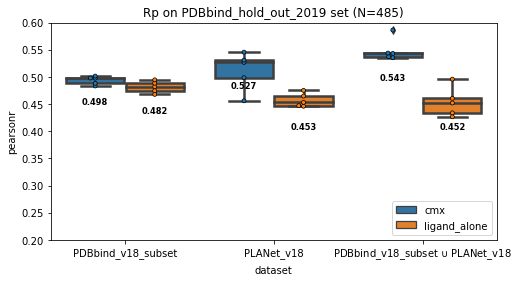

In [177]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'Rp on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.1 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.2,0.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# spearmanr

In [178]:
metric='spearmanr'

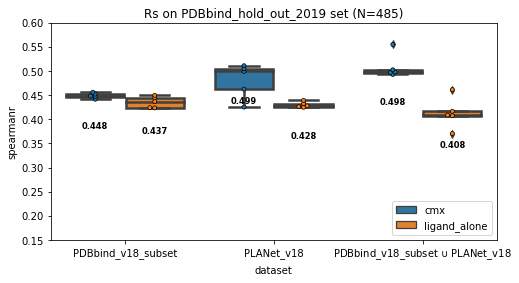

In [181]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'Rs on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.15 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.15,0.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# rmse

In [182]:
metric='rmse'

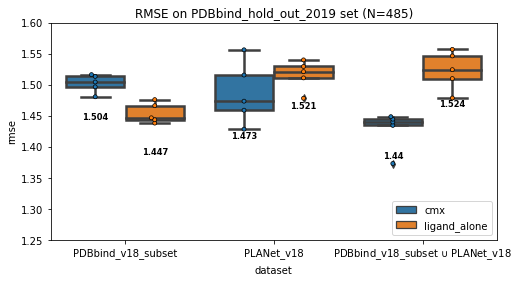

In [184]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'RMSE on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.04 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(1.25,1.6)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# mae

In [185]:
metric='mae'

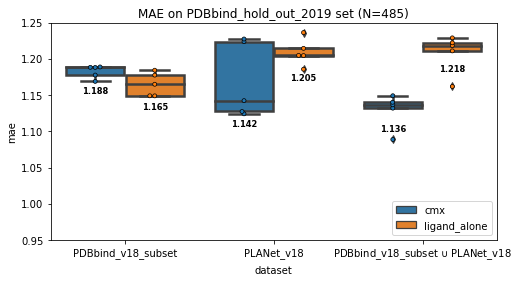

In [188]:
fig, ax= plt.subplots(figsize=(8,4))
sns.boxplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, linewidth=2.5)
sns.swarmplot(x="dataset", y=metric, data=sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)
ax.set_title(f'MAE on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# fig.autofmt_xdate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='lower right')
vertical_offset = sum_df[metric].median() * 0.03 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'ligand_alone']:
        median_metric = round(grouped_median.loc[(grouped_median['model_name'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(0.95,1.25)
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/scaled/{metric}_all_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 2. mean of 5 models

In [47]:
mean_pred_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/6models.csv', sep='\t', index=False)
mean_pred_df

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
0              5eng    5.85                               5.380701   
1              5ep7    5.40                               3.944631   
2              5fxq    7.85                               7.675058   
3              5fxs    8.05                               7.410508   
4              5g2b    7.00                               9.180742   
..              ...     ...                                    ...   
476            6m9t    7.70                               7.712587   
477            6ma5    8.10                               6.400635   
478            6mrg    7.55                               6.946436   
479            6mx8    9.43                               7.895870   
480            6nao    6.70                               7.266832   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
0                                       6.926975             6.109479   
1                                       5.104884             5.572817   
2                                       8.337734             6.231024   
3                                       8.598834             7.421319   
4                                       7.783034             7.925518   
..                                           ...                  ...   
476                                     6.622941             7.343087   
477                                     6.937207             6.370486   
478                                     6.864380             6.536760   
479                                     7.646135             8.449475   
480                                     6.583043             5.805114   

     PLANet_v18_lig_alone_mean  \
0                     6.134713   
1                     4.738019   
2                     8.289605   
3                     8.355122   
4                     6.687080   
..                         ...   
476                   6.481245   
477                   5.756728   
478                   6.696309   
479                   8.546027   
480                   6.293966   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
0                                             5.598933        
1                                             4.992645        
2                                             6.583290        
3                                             7.449681        
4                                             8.600389        
..                                                 ...        
476                                           8.256964        
477                                           6.755843        
478                                           6.555857        
479                                           8.239832        
480                                           6.408082        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  
0                                             6.653835             
1                                             5.605777             
2                                             7.886528             
3                                             8.070054             
4                                             6.333493             
..                                                 ...             
476                                           6.607823             
477                                           5.779567             
478                                           7.211950             
479                                           8.388421             
480                                           6.939303             

[481 rows x 8 columns]

In [48]:
res_dict={}
for model in models:
    for tp in tps:
        r2 = r2_score(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        mae = mean_absolute_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        mse = mean_squared_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df[f'{model}_{tp}_mean'])
        pearsonr = stats.pearsonr(mean_pred_df['y_true'], mean_pred_df[f'{model}_{tp}_mean'])[0]
        spearmanr = stats.spearmanr(mean_pred_df['y_true'], mean_pred_df[f'{model}_{tp}_mean'])[0]
        res_dict[f'{model}_{tp}']=[r2, mae, mse, pearsonr, spearmanr]

com_sum_df = pd.DataFrame.from_dict(res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
com_sum_df.rename(columns={"index": "model_names_test_type"}, inplace=True)
com_sum_df['type'] = ['cmx' if 'cmx' in m else 'lig_alone' for m in com_sum_df['model_names_test_type']]
com_sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in com_sum_df['model_names_test_type']]
com_sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/6models_metric.csv', sep='\t', index=False)
com_sum_df

model_names_test_type        r2       mae  \
0                   PDBbind_minimized_v18_subset_cmx  0.192430  1.159504   
1             PDBbind_minimized_v18_subset_lig_alone  0.227887  1.156718   
2                                     PLANet_v18_cmx  0.276821  1.104115   
3                               PLANet_v18_lig_alone  0.275091  1.117092   
4  PDBbind_minimized_v18_subset_union_PLANet_v18_cmx  0.335048  1.061633   
5  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.274317  1.114313   

        mse  pearsonr  spearmanr       type  \
0  2.177987  0.506244   0.461518        cmx   
1  2.082362  0.490227   0.448596  lig_alone   
2  1.950387  0.562079   0.523621        cmx   
3  1.955055  0.537730   0.505230  lig_alone   
4  1.793353  0.599468   0.555850        cmx   
5  1.957142  0.538058   0.495992  lig_alone   

                                         dataset  
0                   PDBbind_minimized_v18_subset  
1                   PDBbind_minimized_v18_subset  
2                                     PLANet_v18  
3                                     PLANet_v18  
4  PDBbind_minimized_v18_subset_union_PLANet_v18  
5  PDBbind_minimized_v18_subset_union_PLANet_v18

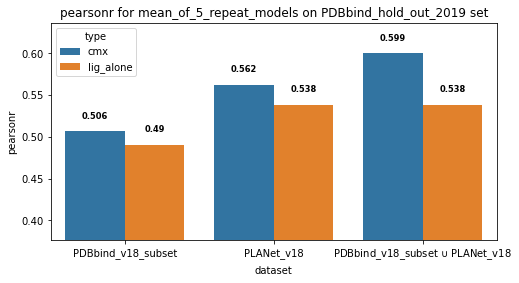

In [51]:
metric='pearsonr'
fig, ax= plt.subplots(figsize=(8,4))
sns.barplot(x="dataset", y=metric, hue='type', data=com_sum_df)

ax.set_title(f'{metric} for mean_of_5_repeat_models on PDBbind_hold_out_2019 set')
vertical_offset = com_sum_df[metric].median() * 0.03 # offset from median for display
for i, modl in enumerate(models):
    for tp in ['cmx', 'lig_alone']:
        median_metric = round(com_sum_df.loc[(com_sum_df['model_names_test_type'] == f'{modl}_{tp}')][metric].values[0], 3)
        if tp == 'cmx':
            ax.text(i-.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
        else:
            ax.text(i+.2, median_metric+vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
ax.set_ylim(min(sum_df[metric])-0.05, min(max(sum_df[metric])+0.05, 1))
ax.set_xticklabels(['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18'])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 2.1 mean_pred-Experimental pAffi 散点图

In [52]:
from scipy.stats import gaussian_kde

In [56]:
simple_dict = {'PDBbind_minimized_v18_subset':'PDBbind_v18_subset', 'PDBbind_minimized_v18_subset_union_PLANet_v18':'PDBbind_v18_subset '+r'$\cup{}$' + ' PLANet_v18','PLANet_v18':'PLANet_v18'}

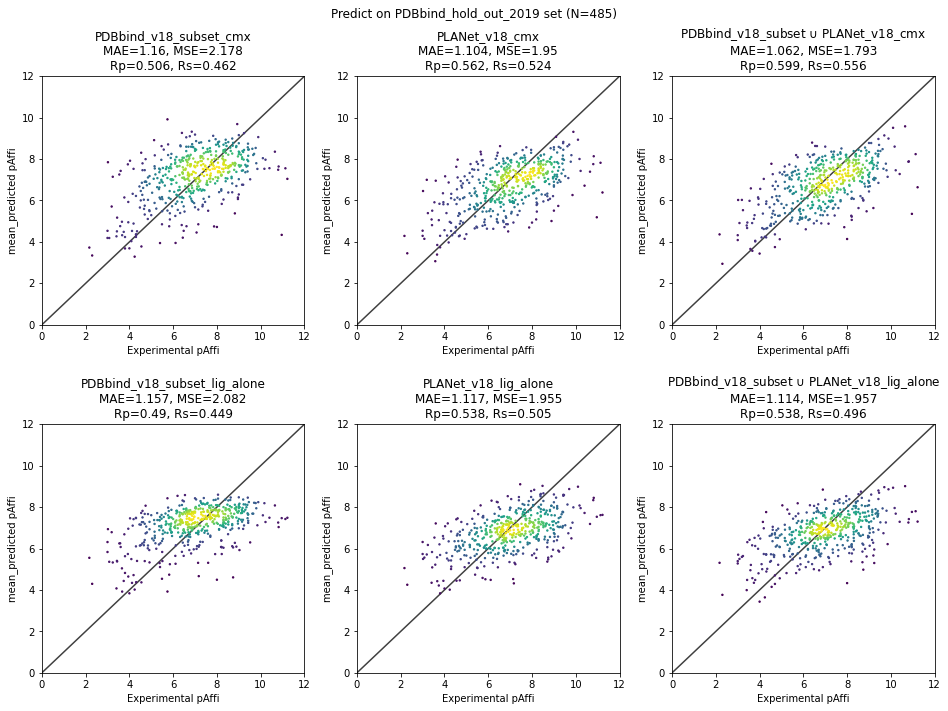

In [189]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        y_true = mean_pred_df['y_true']
        y_pred = mean_pred_df[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='y_true', y=f'{model}_{tp}_mean', data=mean_pred_df)
        lims = [0,12]
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Experimental pAffi')
        ax.set_title(f'{simple_dict[model]}_{tp}\nMAE={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["mae"].values[0], 3)}, MSE={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["mse"].values[0], 3)}\nRp={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["pearsonr"].values[0], 3)}, Rs={round(com_sum_df[com_sum_df["model_names_test_type"]==f"{model}_{tp}"]["spearmanr"].values[0], 3)}')
# plt.subplots_adjust(left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.87, 
#                     wspace=1, 
#                     hspace=0.8)
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.92, 
                    wspace=0.2, 
                    hspace=0.4)
plt.suptitle(f'Predict on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/scatter_6_models.png', dpi=300, bbox_inches='tight')

# 2.1.1 PDBbind_v18_subset vs PLANet_v18

In [250]:
mean_pred_df['d(PLANet_cmx-PDBbind_cmx)']=np.abs(mean_pred_df['PLANet_v18_cmx_mean']-mean_pred_df['PDBbind_minimized_v18_subset_cmx_mean'])
mean_pred_df.sort_values(by='d(PLANet_cmx-PDBbind_cmx)',ascending=False)

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
229            6bsm    6.80                               8.204883   
216            6bkx    6.39                               4.813794   
470            6hu0    6.91                               7.389592   
163            5zfi    5.92                               8.249456   
414            6gdg    8.74                               8.780783   
..              ...     ...                                    ...   
3              5fxs    8.05                               7.410508   
57             5o1c    3.95                               5.928838   
168            5zo8    8.20                               6.474166   
268            6cks    7.82                               7.026221   
377            6fqu    5.66                               5.877014   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
229                                     7.658442             5.233982   
216                                     7.702251             7.718675   
470                                     7.221808             4.505314   
163                                     7.868542             5.467325   
414                                     4.605402             6.022542   
..                                           ...                  ...   
3                                       8.598834             7.421319   
57                                      6.954997             5.918157   
168                                     6.385758             6.482622   
268                                     7.312966             7.028417   
377                                     7.147491             5.877905   

     PLANet_v18_lig_alone_mean  \
229                   6.371705   
216                   8.253631   
470                   7.469720   
163                   6.777795   
414                   5.559978   
..                         ...   
3                     8.355122   
57                    6.480055   
168                   6.468597   
268                   7.778443   
377                   7.016652   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
229                                           5.654247        
216                                           6.658460        
470                                           5.932378        
163                                           6.644599        
414                                           5.994602        
..                                                 ...        
3                                             7.449681        
57                                            5.803060        
168                                           6.424287        
268                                           6.881560        
377                                           6.420412        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
229                                           7.702178              
216                                           7.041137              
470                                           7.591029              
163                                           7.279614              
414                                           6.183889              
..                                                 ...              
3                                             8.070054              
57                                            6.624538              
168                                           6.113504              
268                                           7.030501              
377                                           6.882459              

     d(PLANet_cmx-PDBbind_cmx)  
229                   2.970901  
216                   2.904881  
470                   2.884277  
163                   2.782131  
414                   2.758241  
..                         ...  
3                     0.010811  
57                    0.010

# d > 1

In [334]:
PLANet_vs_PDBbind_dlarge1_cmx = mean_pred_df[np.abs(mean_pred_df['d(PLANet_cmx-PDBbind_cmx)'])>1].copy()
len(PLANet_vs_PDBbind_dlarge1_cmx)

159

In [338]:
PLANet_vs_PDBbind_dlarge1_cmx_prop = PLANet_vs_PDBbind_dlarge1_cmx.round({'y_true': 2}).merge(PDBbind_hold_prop_sasa_Pfam.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true'])
len(PLANet_vs_PDBbind_dlarge1_cmx_prop)

159

In [339]:
len(PLANet_vs_PDBbind_dlarge1_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true']) > np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False))

92

In [346]:
PLANet_vs_PDBbind_dlarge1_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true']) > np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true'])].groupby('PCV_cluster').size()

In [348]:
PLANet_vs_PDBbind_dlarge1_cmx_prop[PLANet_vs_PDBbind_dlarge1_cmx_prop['PCV_cluster'] == 'P53-like']

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
15            5o1a    4.52                               6.457995   
16            5o1b    4.70                               5.323044   
17            5o1d    4.66                               6.038726   
18            5o1e    4.48                               5.660220   
19            5o1f    4.52                               6.003012   
20            5o1h    4.85                               6.029898   
21            5o1i    5.40                               7.493425   

    PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
15                                     7.150183             4.725118   
16                                     6.411172             4.307718   
17                                     6.156137             4.272268   
18                                     6.141131             4.449686   
19                                     6.162184             4.692666   
20                                     6.145538             4.930928   
21                                     7.526984             5.231322   

    PLANet_v18_lig_alone_mean  \
15                   6.104350   
16                   6.060204   
17                   6.129116   
18                   5.937140   
19                   6.050576   
20                   6.190423   
21                   6.686304   

    PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
15                                           4.779778        
16                                           3.750443        
17                                           4.873248        
18                                           4.791575        
19                                           4.877429        
20                                           5.257705        
21                                           6.484726        

    PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
15                                           5.400787              
16                                           4.289716              
17                                           5.590054              
18                                           5.359791              
19                                           5.720440              
20                                           5.215319              
21                                           6.288955              

    d(PLANet_cmx-PDBbind_cmx)       mw  ...  rotb  hbd  hba    q    HA  \
15                   1.732877  538.147  ...   2.0  2.0  3.0  1.0  23.0   
16                   1.015326  441.006  ...   2.0  2.0  3.0  0.0  16.0   
17                   1.766458  386.165  ...   5.0  1.0  5.0 -1.0  20.0   
18                   1.210534  384.149  ...   5.0  1.0  5.0 -1.0  20.0   
19                   1.310347  400.192  ...   6.0  1.0  5.0 -1.0  21.0   
20                   1.098970  402.233  ...   5.0  1.0  5.0 -1.0  20.0   
21                   2.262103  456.285  ...   5.0  1.0  7.0 -1.0  24.0   

    lig_sasa    rec_sasa    com_sasa   del_sasa  PCV_cluster  
15  5.957557  104.368721   99.304916  11.021362     P53-like  
16  4.555434  106.946922   98.939743  12.562614     P53-like  
17  5.140255  106.179398  100.189438  11.130219     P53-like  
18  5.140731  106.560593   99.292931  12.408394     P53-like  
19  5.523054  104.843468   98.957336  11.409187     P53-like  
20  5.281420  106.011307   98.598625  12.694099     P53-like  
21  5.840074  104.831551   98.252876  12.418747     P53-like  

[7 rows x 21 columns]

In [340]:
len(PLANet_vs_PDBbind_dlarge1_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true']) < np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False))

67

In [349]:
PLANet_vs_PDBbind_dlarge1_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true']) < np.abs(PLANet_vs_PDBbind_dlarge1_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge1_cmx_prop['y_true'])].groupby('PCV_cluster').size()

PCV_cluster
APC                 1
Arginase            4
BCLiA               1
Beta-tent           1
Bromodomain         1
C2                  1
Calycin             4
Carb_anhydrase      1
Concanavalin        1
EF_hand             1
Filo_glycop         1
GPCR_A              6
Glyco_hydro_tim     1
HAD                 2
His_Kinase_A        2
LDH_C               1
Mab-21              1
NUDIX               1
Neur_chan_LBD       2
P-loop_NTPase       1
Peptidase_AA        1
Peptidase_CA        1
Peptidase_MA        2
Peptidase_MH        1
Peptidase_PA        2
SET                 1
Tudor               1
dUTPase             1
hormone_recep       5
pkinase            16
una_322             1
una_436             1
dtype: int64

# d > 2

In [263]:
PLANet_vs_PDBbind_dlarge2_cmx = mean_pred_df[np.abs(mean_pred_df['d(PLANet_cmx-PDBbind_cmx)'])>2].copy()
len(PLANet_vs_PDBbind_dlarge2_cmx)

24

In [277]:
PDBbind_hold_prop[PDBbind_hold_prop['pdb_id']=='6bsm']

pdb_id  -logAffi       mw   logp  rotb  hbd  hba    q    HA
213   6bsm       6.8  405.451  2.289  12.0  3.0  6.0  0.0  29.0

In [326]:
PDBbind_hold_prop_sasa_Pfam.columns

Index(['pdb_id', '-logAffi', 'mw', 'logp', 'rotb', 'hbd', 'hba', 'q', 'HA',
       'lig_sasa', 'rec_sasa', 'com_sasa', 'del_sasa', 'PCV_cluster'],
      dtype='object')

In [327]:
len(PLANet_vs_PDBbind_dlarge2_cmx.round({'y_true': 2}).merge(PDBbind_hold_prop_sasa_Pfam.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true']))

24

In [329]:
PLANet_vs_PDBbind_dlarge2_cmx_prop = PLANet_vs_PDBbind_dlarge2_cmx.round({'y_true': 2}).merge(PDBbind_hold_prop_sasa_Pfam.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true'])
PLANet_vs_PDBbind_dlarge2_cmx_prop

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
0             5o1i    5.40                               7.493425   
1             5oh4    4.55                               3.779947   
2             5th7    5.16                               8.178618   
3             5y0f    6.68                               7.058956   
4             5y0g    6.70                               7.283258   
5             5y13    5.94                               7.027843   
6             5yc8    8.19                               7.211215   
7             5ye7    5.46                               7.963439   
8             5zfi    5.92                               8.249456   
9             5zk8    8.89                               7.380718   
10            5zkb    8.70                               8.990161   
11            6b31    8.44                               8.629776   
12            6bkx    6.39                               4.813794   
13            6bqg    8.93                               9.687162   
14            6bsl    9.00                               7.706146   
15            6bsm    6.80                               8.204883   
16            6c2y    6.60                               8.595844   
17            6cmr    6.61                               4.756164   
18            6di1    6.74                               6.953985   
19            6ekq    5.46                               6.998802   
20            6f9u    5.13                               8.912198   
21            6gdg    8.74                               8.780783   
22            6gl8    8.61                               8.551259   
23            6hu0    6.91                               7.389592   

    PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
0                                      7.526984             5.231322   
1                                      4.365128             5.827003   
2                                      6.616428             5.793593   
3                                      6.327753             5.023591   
4                                      6.403997             4.955491   
5                                      6.784871             4.638747   
6                                      6.075627             5.086172   
7                                      7.098470             5.843468   
8                                      7.868542             5.467325   
9                                      6.091107             5.007895   
10                                     7.122255             6.331952   
11                                     7.419364             6.292456   
12                                     7.702251             7.718675   
13                                     7.760524             7.390601   
14                                     7.945188             5.509823   
15                                     7.658442             5.233982   
16                                     7.931143             5.920925   
17                                     7.777583             6.777720   
18                                     6.750432             4.715145   
19                                     7.016012             4.737185   
20                                     7.372923             6.852281   
21                                     4.605402             6.022542   
22                                     8.340610             6.274817   
23                                     7.221808             4.505314   

    PLANet_v18_lig_alone_mean  \
0                    6.686304   
1                    4.444626   
2                    6.155783   
3                    6.044891   
4                    5.655402   
5                    6.682442   
6                    5.545399   
7                    5.459024   
8                    6.777795   
9                    5.621985   
10                   6.065807   
11                   7.290492   
12                   8.253631   
13            

In [330]:
len(PLANet_vs_PDBbind_dlarge2_cmx[np.abs(PLANet_vs_PDBbind_dlarge2_cmx['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx['y_true']) > np.abs(PLANet_vs_PDBbind_dlarge2_cmx['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False))

9

In [331]:
PLANet_vs_PDBbind_dlarge2_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge2_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx_prop['y_true']) > np.abs(PLANet_vs_PDBbind_dlarge2_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx_prop['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False)

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
12            6bkx    6.39                               4.813794   
8             5zfi    5.92                               8.249456   
16            6c2y    6.60                               8.595844   
2             5th7    5.16                               8.178618   
0             5o1i    5.40                               7.493425   
19            6ekq    5.46                               6.998802   
7             5ye7    5.46                               7.963439   
20            6f9u    5.13                               8.912198   
17            6cmr    6.61                               4.756164   

    PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
12                                     7.702251             7.718675   
8                                      7.868542             5.467325   
16                                     7.931143             5.920925   
2                                      6.616428             5.793593   
0                                      7.526984             5.231322   
19                                     7.016012             4.737185   
7                                      7.098470             5.843468   
20                                     7.372923             6.852281   
17                                     7.777583             6.777720   

    PLANet_v18_lig_alone_mean  \
12                   8.253631   
8                    6.777795   
16                   6.684518   
2                    6.155783   
0                    6.686304   
19                   6.748584   
7                    5.459024   
20                   6.672122   
17                   6.246797   

    PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
12                                           6.658460        
8                                            6.644599        
16                                           6.242888        
2                                            6.573157        
0                                            6.484726        
19                                           5.050886        
7                                            7.014585        
20                                           7.381222        
17                                           5.019536        

    PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
12                                           7.041137              
8                                            7.279614              
16                                           6.116126              
2                                            6.374897              
0                                            6.288955              
19                                           6.212586              
7                                            6.399173              
20                                           5.611905              
17                                           5.897080              

    d(PLANet_cmx-PDBbind_cmx)       mw  ...  rotb  hbd   hba    q    HA  \
12                   2.904881  346.434  ...   2.0  1.0   5.0  0.0  26.0   
8                    2.782131  542.471  ...   7.0  2.0   6.0  0.0  37.0   
16                   2.674919  536.524  ...   8.0  5.0   8.0  0.0  39.0   
2                    2.385025  387.484  ...   9.0  2.0   7.0  0.0  28.0   
0                    2.262103  456.285  ...   5.0  1.0   7.0 -1.0  24.0   
19                   2.261617  349.480  ...   4.0  2.0   5.0  1.0  24.0   
7                    2.119971  432.501  ...   6.0  2.0   4.0  0.0  31.0   
20                   2.059917  532.526  ...  14.0  4.0  10.0 -3.0  38.0   
17                   2.021556  353.277  ...   2.0  2.0   4.0  1.0  23.0   

    lig_sasa    rec_sasa    com_sasa   del_sasa   PCV_cluster  
12  5.951746  340.199799  344.466461   1.685089        Iso_DH  
8   8.545912  108.537560  107.393639   9.689835  Peptidase_PA  
16  8.413074  3

In [267]:
len(PLANet_vs_PDBbind_dlarge2_cmx[np.abs(PLANet_vs_PDBbind_dlarge2_cmx['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx['y_true']) < np.abs(PLANet_vs_PDBbind_dlarge2_cmx['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False))

15

In [332]:
PLANet_vs_PDBbind_dlarge2_cmx_prop[np.abs(PLANet_vs_PDBbind_dlarge2_cmx_prop['PDBbind_minimized_v18_subset_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx_prop['y_true']) < np.abs(PLANet_vs_PDBbind_dlarge2_cmx_prop['PLANet_v18_cmx_mean']-PLANet_vs_PDBbind_dlarge2_cmx_prop['y_true'])].sort_values(by='d(PLANet_cmx-PDBbind_cmx)', ascending=False)

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
15            6bsm    6.80                               8.204883   
23            6hu0    6.91                               7.389592   
21            6gdg    8.74                               8.780783   
10            5zkb    8.70                               8.990161   
5             5y13    5.94                               7.027843   
9             5zk8    8.89                               7.380718   
11            6b31    8.44                               8.629776   
4             5y0g    6.70                               7.283258   
13            6bqg    8.93                               9.687162   
22            6gl8    8.61                               8.551259   
18            6di1    6.74                               6.953985   
14            6bsl    9.00                               7.706146   
6             5yc8    8.19                               7.211215   
1             5oh4    4.55                               3.779947   
3             5y0f    6.68                               7.058956   

    PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
15                                     7.658442             5.233982   
23                                     7.221808             4.505314   
21                                     4.605402             6.022542   
10                                     7.122255             6.331952   
5                                      6.784871             4.638747   
9                                      6.091107             5.007895   
11                                     7.419364             6.292456   
4                                      6.403997             4.955491   
13                                     7.760524             7.390601   
22                                     8.340610             6.274817   
18                                     6.750432             4.715145   
14                                     7.945188             5.509823   
6                                      6.075627             5.086172   
1                                      4.365128             5.827003   
3                                      6.327753             5.023591   

    PLANet_v18_lig_alone_mean  \
15                   6.371705   
23                   7.469720   
21                   5.559978   
10                   6.065807   
5                    6.682442   
9                    5.621985   
11                   7.290492   
4                    5.655402   
13                   7.297997   
22                   7.074387   
18                   5.859919   
14                   6.910743   
6                    5.545399   
1                    4.444626   
3                    6.044891   

    PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
15                                           5.654247        
23                                           5.932378        
21                                           5.994602        
10                                           7.132554        
5                                            5.117921        
9                                            5.476874        
11                                           7.311522        
4                                            6.001811        
13                                           7.470260        
22                                           6.211209        
18                                           6.630938        
14                                           6.434840        
6                                            5.264543        
1                                            5.180502        
3                                            5.616314        

    PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
15                                           7.702178              
23                                           7.591029              
21                 

In [261]:
PLANet_rmse = np.sqrt(mean_squared_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df['PLANet_v18_cmx_mean']))
PLANet_pearsonr = stats.pearsonr(mean_pred_df['y_true'], mean_pred_df['PLANet_v18_cmx_mean'])
PLANet_mae = mean_absolute_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df['PLANet_v18_cmx_mean'])
PLANet_spearmanr = stats.spearmanr(mean_pred_df['y_true'], mean_pred_df['PLANet_v18_cmx_mean'])


PIP_rmse = np.sqrt(mean_squared_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df['PDBbind_minimized_v18_subset_cmx_mean']))
PIP_pearsonr = stats.pearsonr(mean_pred_df['y_true'], mean_pred_df['PDBbind_minimized_v18_subset_cmx_mean'])
PIP_mae = mean_absolute_error(y_true=mean_pred_df['y_true'], y_pred=mean_pred_df['PDBbind_minimized_v18_subset_cmx_mean'])
PIP_spearmanr = stats.spearmanr(mean_pred_df['y_true'], mean_pred_df['PDBbind_minimized_v18_subset_cmx_mean'])
print(f'PLANet Rp:{PLANet_pearsonr[0]}, MAE:{PLANet_mae}, Rs:{PLANet_spearmanr[0]}, RMSE:{PLANet_rmse}')
print(f'PIP Rp:{PIP_pearsonr[0]}, MAE:{PIP_mae}, Rs:{PIP_spearmanr[0]}, RMSE:{PIP_rmse}')

PLANet Rp:0.562079054369123, MAE:1.1041152951127526, Rs:0.5236210816926538, RMSE:1.3965626666585764
PIP Rp:0.5062437231582405, MAE:1.159503565905248, Rs:0.4615176372290587, RMSE:1.475800446004764


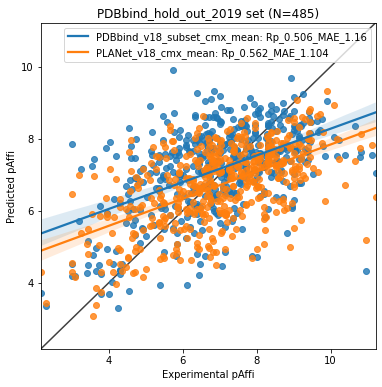

In [482]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=mean_pred_df, x="y_true", y="PDBbind_minimized_v18_subset_cmx_mean")
sns.regplot(data=mean_pred_df, x="y_true", y="PLANet_v18_cmx_mean")
# sns.regplot(data=delta_df, x="y_true", y="PLANet_cmx_mean", marker="o", facecolor="none", edgecolor='black', linewidth=2)
# sns.scatterplot(data=delta_df, x="y_true", y="PIP_cmx_mean", marker="o", facecolor="none", edgecolor='dimgrey', linewidth=2)
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental pAffi")
plt.ylabel("Predicted pAffi")
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.legend(labels=[f"PDBbind_v18_subset_cmx_mean: Rp_{round(PIP_pearsonr[0],3)}_MAE_{round(PIP_mae,3)}", f"PLANet_v18_cmx_mean: Rp_{round(PLANet_pearsonr[0],3)}_MAE_{round(PLANet_mae,3)}"])
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/PLANet_vs_PIP_cmx_mean_MAE_regplot.png', dpi=300, bbox_inches='tight')

In [258]:
mean_pred_df_melted = mean_pred_df.melt(id_vars=['unique_identify', 'y_true'], var_name='model')

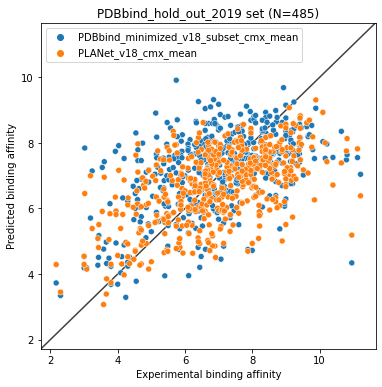

In [260]:
PIP_PLANet_cmx = mean_pred_df_melted[mean_pred_df_melted['model'].isin(['PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean'])].copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=PIP_PLANet_cmx, x="y_true", y="value", hue='model')
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='upper left')
# plt.savefig(f'CASF/Core_inter_Uw_scatter_PLANet_vs_PIP_cmx_1.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'PDBbind_hold_out_2019 set (N=485)')

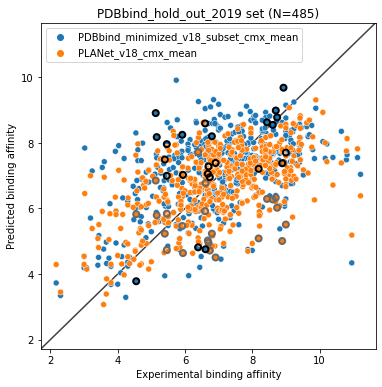

In [269]:
PIP_PLANet_cmx = mean_pred_df_melted[mean_pred_df_melted['model'].isin(['PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean'])].copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=PIP_PLANet_cmx, x="y_true", y="value", hue='model')

sns.scatterplot(data=PLANet_vs_PDBbind_dlarge2_cmx, x="y_true", y="PLANet_v18_cmx_mean", marker="o", facecolor="none", edgecolor='dimgrey', linewidth=2)
sns.scatterplot(data=PLANet_vs_PDBbind_dlarge2_cmx, x="y_true", y="PDBbind_minimized_v18_subset_cmx_mean", marker="o", facecolor="none", edgecolor='black', linewidth=2)

lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='upper left')
# plt.savefig(f'CASF/Core_inter_Uw_scatter_PLANet_vs_PIP_cmx_1.png', dpi=300, bbox_inches='tight')

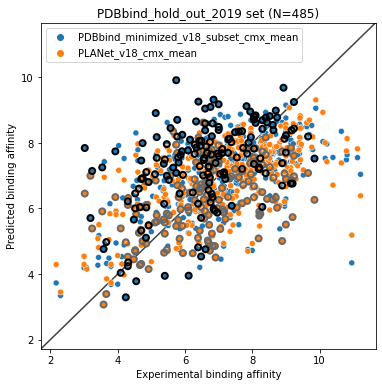

In [270]:
PIP_PLANet_cmx = mean_pred_df_melted[mean_pred_df_melted['model'].isin(['PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean'])].copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=PIP_PLANet_cmx, x="y_true", y="value", hue='model')

sns.scatterplot(data=PLANet_vs_PDBbind_dlarge1_cmx, x="y_true", y="PLANet_v18_cmx_mean", marker="o", facecolor="none", edgecolor='dimgrey', linewidth=2)
sns.scatterplot(data=PLANet_vs_PDBbind_dlarge1_cmx, x="y_true", y="PDBbind_minimized_v18_subset_cmx_mean", marker="o", facecolor="none", edgecolor='black', linewidth=2)

lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='upper left')
# plt.savefig(f'CASF/Core_inter_Uw_scatter_PLANet_vs_PIP_cmx_1.png', dpi=300, bbox_inches='tight')

# 2.2 Mw-mean_predicted_pAffi

In [75]:
mean_pred_df_with_prop = pd.merge(mean_pred_df.round({'y_true': 2}), PDBbind_hold_prop.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true'])
mean_pred_df_with_prop

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
0              5eng    5.85                               5.380701   
1              5ep7    5.40                               3.944631   
2              5fxq    7.85                               7.675058   
3              5fxs    8.05                               7.410508   
4              5g2b    7.00                               9.180742   
..              ...     ...                                    ...   
476            6m9t    7.70                               7.712587   
477            6ma5    8.10                               6.400635   
478            6mrg    7.55                               6.946436   
479            6mx8    9.43                               7.895870   
480            6nao    6.70                               7.266832   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
0                                       6.926975             6.109479   
1                                       5.104884             5.572817   
2                                       8.337734             6.231024   
3                                       8.598834             7.421319   
4                                       7.783034             7.925518   
..                                           ...                  ...   
476                                     6.622941             7.343087   
477                                     6.937207             6.370486   
478                                     6.864380             6.536760   
479                                     7.646135             8.449475   
480                                     6.583043             5.805114   

     PLANet_v18_lig_alone_mean  \
0                     6.134713   
1                     4.738019   
2                     8.289605   
3                     8.355122   
4                     6.687080   
..                         ...   
476                   6.481245   
477                   5.756728   
478                   6.696309   
479                   8.546027   
480                   6.293966   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
0                                             5.598933        
1                                             4.992645        
2                                             6.583290        
3                                             7.449681        
4                                             8.600389        
..                                                 ...        
476                                           8.256964        
477                                           6.755843        
478                                           6.555857        
479                                           8.239832        
480                                           6.408082        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean       mw  \
0                                             6.653835             471.554   
1                                             5.605777             271.252   
2                                             7.886528             409.905   
3                                             8.070054             509.038   
4                                             6.333493             528.653   
..                                                 ...                 ...   
476                                           6.607823             367.506   
477                                           5.779567             540.599   
478                                           7.211950             349.390   
479                                           8.388421             586.121   
480                                           6.939303             379.396   

        logp  rotb  hbd  hba    q    HA  
0    0.16750  10.0  3.0  6.0  2.0  34.0  
1    0.00110   3.0  1.0  5.0 -1.0  20.0  
2    2.59152   4.0  2.0  7.0  1.0  29.0  
3    2.30964   

In [192]:
max(mean_pred_df_with_prop['mw'])

841.3909999999993

In [193]:
min(mean_pred_df_with_prop['mw'])

85.10600000000001

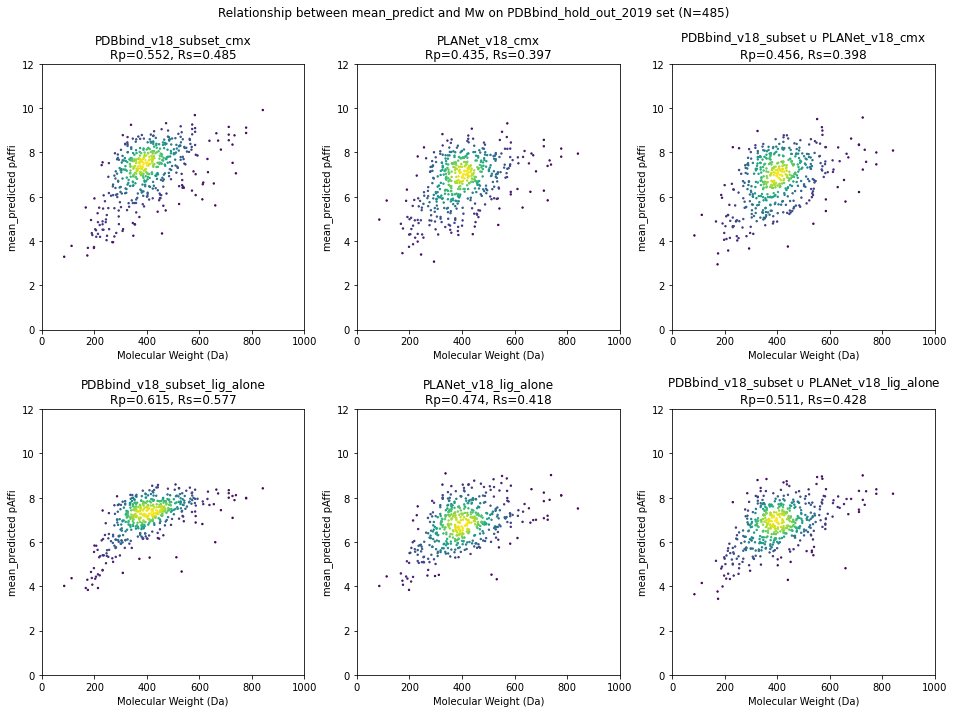

In [376]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['mw']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["mw"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["mw"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and Mw on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/mw/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 2.3 HA-mean_predict

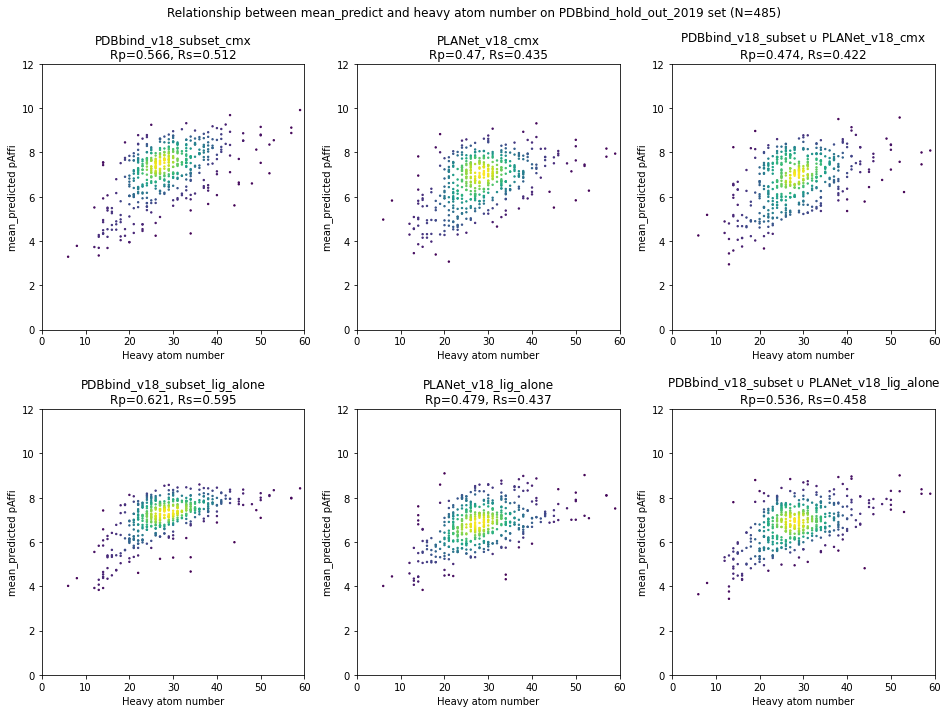

In [375]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['HA']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(0, 60)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["HA"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["HA"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/HA/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 2.4 SASA

In [220]:
PDBbind_whole_sasa = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/SASA/PDBbind_whole_sasa.csv')
len(PDBbind_whole_sasa)

17065

In [226]:
min(PDBbind_whole_sasa['del_sasa'])

-59.6170654296875

In [217]:
len(mean_pred_df_with_prop)

481

In [216]:
mean_pred_df_with_prop.columns

Index(['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean',
       'PDBbind_minimized_v18_subset_lig_alone_mean', 'PLANet_v18_cmx_mean',
       'PLANet_v18_lig_alone_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean', 'mw',
       'logp', 'rotb', 'hbd', 'hba', 'q', 'HA'],
      dtype='object')

In [221]:
mean_pred_df_with_prop_sasa = pd.merge(mean_pred_df_with_prop, PDBbind_whole_sasa.rename(columns={'unique_identity':'unique_identify'}), on=['unique_identify'])
mean_pred_df_with_prop_sasa

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
0              5eng    5.85                               5.380701   
1              5ep7    5.40                               3.944631   
2              5fxq    7.85                               7.675058   
3              5fxs    8.05                               7.410508   
4              5g2b    7.00                               9.180742   
..              ...     ...                                    ...   
476            6m9t    7.70                               7.712587   
477            6ma5    8.10                               6.400635   
478            6mrg    7.55                               6.946436   
479            6mx8    9.43                               7.895870   
480            6nao    6.70                               7.266832   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
0                                       6.926975             6.109479   
1                                       5.104884             5.572817   
2                                       8.337734             6.231024   
3                                       8.598834             7.421319   
4                                       7.783034             7.925518   
..                                           ...                  ...   
476                                     6.622941             7.343087   
477                                     6.937207             6.370486   
478                                     6.864380             6.536760   
479                                     7.646135             8.449475   
480                                     6.583043             5.805114   

     PLANet_v18_lig_alone_mean  \
0                     6.134713   
1                     4.738019   
2                     8.289605   
3                     8.355122   
4                     6.687080   
..                         ...   
476                   6.481245   
477                   5.756728   
478                   6.696309   
479                   8.546027   
480                   6.293966   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
0                                             5.598933        
1                                             4.992645        
2                                             6.583290        
3                                             7.449681        
4                                             8.600389        
..                                                 ...        
476                                           8.256964        
477                                           6.755843        
478                                           6.555857        
479                                           8.239832        
480                                           6.408082        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean       mw  \
0                                             6.653835             471.554   
1                                             5.605777             271.252   
2                                             7.886528             409.905   
3                                             8.070054             509.038   
4                                             6.333493             528.653   
..                                                 ...                 ...   
476                                           6.607823             367.506   
477                                           5.779567             540.599   
478                                           7.211950             349.390   
479                                           8.388421             586.121   
480                                           6.939303             379.396   

        logp  rotb  hbd  hba    q    HA  lig_sasa    rec_sasa    com_sasa  \
0    0.16750  10.0  3.0  6.0  2.0  34.0  8.203731   71.745308   71.241333   
1    0.00110   3.0  1.0  5.0 

In [228]:
min(mean_pred_df_with_prop_sasa['del_sasa'])

-55.6556396484375

In [229]:
max(mean_pred_df_with_prop_sasa['del_sasa'])

27.736724853515625

In [233]:
mean_pred_df_with_prop_sasa[mean_pred_df_with_prop_sasa['del_sasa']<-30]

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
283            6d6t    8.21                               7.203829   
284            6d6u    8.21                               7.248432   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
283                                     6.069516             5.901479   
284                                     6.065004             5.781781   

     PLANet_v18_lig_alone_mean  \
283                   6.626007   
284                   6.600419   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
283                                           5.219582        
284                                           5.062654        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean       mw  \
283                                           6.207106             303.293   
284                                           6.065750             303.293   

       logp  rotb  hbd  hba    q    HA  lig_sasa    rec_sasa    com_sasa  \
283  1.7737   2.0  0.0  5.0  0.0  22.0  4.947023  875.065857  933.648010   
284  1.7737   2.0  0.0  5.0  0.0  22.0  5.016707  906.021118  966.693481   

      del_sasa  
283 -53.635132  
284 -55.655640

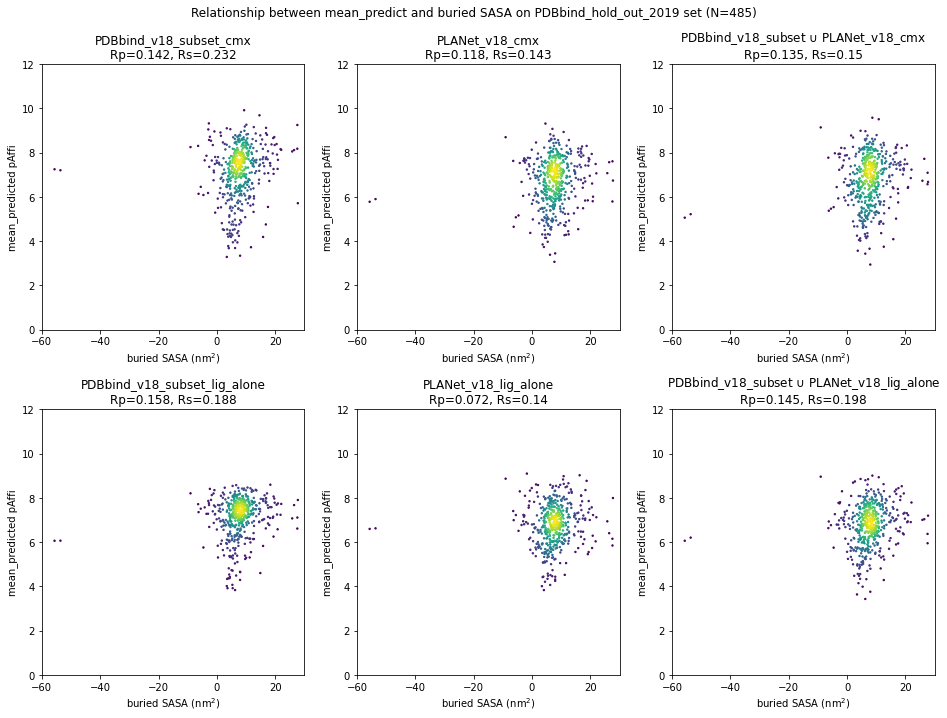

In [377]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop_sasa['del_sasa']
        y_pred = mean_pred_df_with_prop_sasa[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        ax.set_xlim(-60, 30)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop_sasa[f"{model}_{tp}_mean"], mean_pred_df_with_prop_sasa["del_sasa"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop_sasa[f"{model}_{tp}_mean"], mean_pred_df_with_prop_sasa["del_sasa"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and buried SASA on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/SASA/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# logp

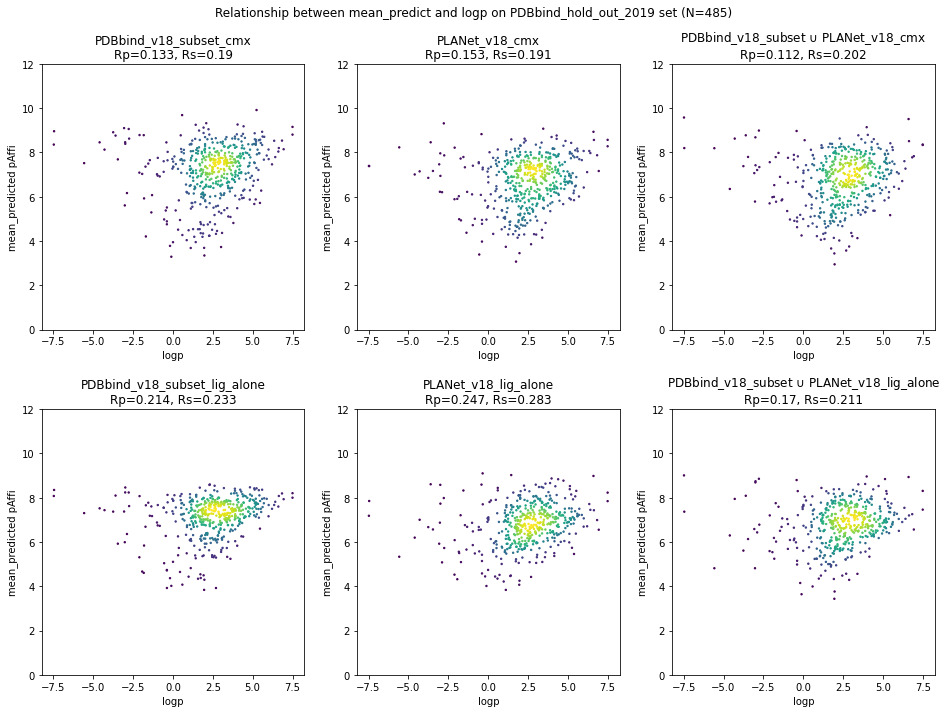

In [386]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))

        y_true = mean_pred_df_with_prop['logp']
        y_pred = mean_pred_df_with_prop[f'{model}_{tp}_mean']

        xy = np.vstack([y_true.T, y_pred.T])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        y_true_, y_pred_, z = y_true[idx], y_pred[idx], z[idx]

        #https://github.com/hnlab/handbook/blob/41ad374cd0f9dc3ef882a7724eaac3d1f748fc05/0-General-computing-skills/MISC/vsfig.py#L83-L134
        # fig, ax = plt.subplots()
        ax.scatter(y_true_, y_pred_, s=2, c=z, zorder=2)

        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=mean_pred_df_with_prop)

        # if model=='PDBbind_minimized_intersected_Uw':
        #     ax.axvline(x=800, color='black', linestyle='--')

        # ax.set_xlim(0, 60)
        ax.set_ylim(0, 12)

        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\nRp={round(stats.pearsonr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["logp"])[0], 3)}, Rs={round(stats.spearmanr(mean_pred_df_with_prop[f"{model}_{tp}_mean"], mean_pred_df_with_prop["logp"])[0], 3)}')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.3)
plt.suptitle(f'Relationship between mean_predict and logp on PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/logp/scatter_for_12_models.png', dpi=300, bbox_inches='tight')

# 3. property match

In [85]:
PDBbind_hold_prop

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
168     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0
242     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0
652     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0
655     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0
666     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17025   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17032   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17049   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0
17073   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0
17083   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0

[485 rows x 9 columns]

# PDBbind_v18 subset

In [86]:
PDBbind_v18_subset = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PDBbind_v18_subset_rm_simi_1.csv', sep='\t')
PDBbind_v18_subset

pdb_id  -logAffi
0      3fl9      1.11
1      2hdq      1.40
2      1utp      1.44
3      1tnk      1.49
4      2hdr      1.72
...     ...       ...
5366   4n70     12.00
5367   3o9h     12.10
5368   3o9g     12.30
5369   1q83     12.39
5370   3o9f     12.70

[5371 rows x 2 columns]

In [195]:
max(PDBbind_v18_subset['-logAffi'])

12.7

In [164]:
min(PDBbind_v18_subset['-logAffi'])

1.11

In [90]:
PDBbind_v18_subset_prop = PDBbind_whole_property[PDBbind_whole_property['pdb_id'].isin(PDBbind_v18_subset['pdb_id'])]
len(PDBbind_v18_subset_prop)

5371

In [196]:
max(PDBbind_v18_subset_prop['mw'])

911.3299999999997

In [197]:
min(PDBbind_v18_subset_prop['mw'])

78.11399999999998

# PLANet_v18

In [91]:
PLANet_v18 = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PLANet_v18_rm_simi_1.csv', sep='\t')
PLANet_v18

unique_identify   -logAffi
0         CHEMBL1075026_1swr_CHEMBL857  14.000000
1      CHEMBL1075027_1hp5_CHEMBL257158   4.698970
2      CHEMBL1075027_1hp5_CHEMBL403756   4.000000
3      CHEMBL1075027_1hp5_CHEMBL404356   3.698970
4      CHEMBL1075027_1jak_CHEMBL253537   4.677781
...                                ...        ...
63599    CHEMBL6166_4zk5_CHEMBL3623138   8.431798
63600    CHEMBL6166_4zk5_CHEMBL3623139   8.795880
63601    CHEMBL6166_5di1_CHEMBL3754283   7.588909
63602    CHEMBL6166_5di1_CHEMBL3754304   6.285285
63603      CHEMBL6175_2xml_CHEMBL90852   3.301030

[63604 rows x 2 columns]

In [94]:
PLANet_property = pd.read_csv('/pubhome/xli02/project/PLIM/analysis/20220812_paper/distribution/property/PLANet_property.csv', sep='\t')
PLANet_v18_property = PLANet_property[PLANet_property['unique_identify'].isin(PLANet_v18['unique_identify'])]
len(PLANet_v18_property)

63604

In [198]:
max(PLANet_v18_property['mw'])

969.1289999999992

In [199]:
min(PLANet_v18_property['mw'])

78.11399999999998

# PDBbind_v18_subset_union_PLANet_v18

In [95]:
# PIPUP = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/rm_all_simi_1/PDBbind_v18_subset_union_PLANet_rm_simi_1.csv', sep='\t')
# PIPUP

unique_identify   -logAffi
0         CHEMBL1075026_1swr_CHEMBL857  14.000000
1      CHEMBL1075027_1hp5_CHEMBL257158   4.698970
2      CHEMBL1075027_1hp5_CHEMBL403756   4.000000
3      CHEMBL1075027_1hp5_CHEMBL404356   3.698970
4      CHEMBL1075027_1jak_CHEMBL253537   4.677781
...                                ...        ...
68970                             4n70  12.000000
68971                             3o9h  12.100000
68972                             3o9g  12.300000
68973                             1q83  12.390000
68974                             3o9f  12.700000

[68975 rows x 2 columns]

In [97]:
PIPUP_df = pd.concat([PDBbind_v18_subset_prop.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'})[['unique_identify', 'y_true', 'mw']].copy(), PLANet_v18_property.rename(columns={'-logAffi':'y_true'})[['unique_identify', 'y_true', 'mw']].copy()])
# PIPUP_df['dataset'] = 'PDBbind_subset_union_PLANet'
PIPUP_df

unique_identify    y_true       mw
15                              3fl9  1.110000  290.323
38                              2hdq  1.400000  127.144
42                              1utp  1.440000  150.245
44                              1tnk  1.490000  136.218
73                              2hdr  1.720000  152.129
...                              ...       ...      ...
69811  CHEMBL6166_4zk5_CHEMBL3623138  8.431798  405.433
69812  CHEMBL6166_4zk5_CHEMBL3623139  8.795880  394.410
69813  CHEMBL6166_5di1_CHEMBL3754283  7.588909  340.404
69814  CHEMBL6166_5di1_CHEMBL3754304  6.285285  367.430
69815    CHEMBL6175_2xml_CHEMBL90852  3.301030  145.070

[68975 rows x 3 columns]

In [100]:
PDBbind_v18_subset_prop

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
15      3fl9      1.11  290.323  1.2576   5.0  2.0  7.0  0.0  21.0
38      2hdq      1.40  127.144  0.1116   1.0  0.0  3.0 -1.0   8.0
42      1utp      1.44  150.245  1.2512   4.0  1.0  0.0  1.0  11.0
44      1tnk      1.49  136.218  0.8611   3.0  1.0  0.0  1.0  10.0
73      2hdr      1.72  152.129 -0.6621   1.0  2.0  4.0 -1.0  11.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17151   4n70     12.00  458.464  2.2407   4.0  3.0  5.0  1.0  33.0
17155   3o9h     12.10  604.722  3.3020  13.0  2.0  9.0  0.0  42.0
17158   3o9g     12.30  590.739  3.0656  14.0  3.0  8.0  0.0  41.0
17160   1q83     12.39  661.878  8.0456  12.0  3.0  7.0  1.0  50.0
17163   3o9f     12.70  590.739  3.5819  14.0  2.0  8.0  0.0  41.0

[5371 rows x 9 columns]

# PDBbind_v18_subset vs PDBbind_hold_out_19

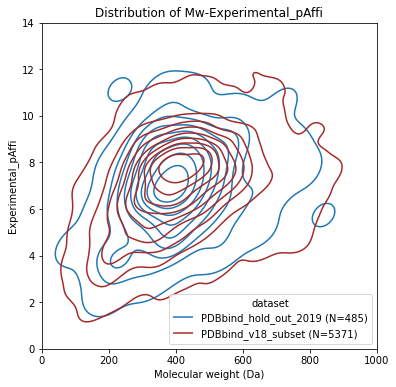

In [103]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=PDBbind_hold_prop, x='mw', y='-logAffi', color='tab:blue', thresh=0.01)
sns.kdeplot(data=PDBbind_v18_subset_prop, x='mw', y='-logAffi', color='brown', thresh=0.01)
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Experimental_pAffi")
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
ax.set_title(f'Distribution of Mw-Experimental_pAffi')
plt.legend(labels=[f'PDBbind_hold_out_2019 (N={len(PDBbind_hold_prop)})', f'PDBbind_v18_subset (N={len(PDBbind_v18_subset_prop)})'], title = "dataset", loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_match/PIP_vs_hold_thresh_0.01.png', dpi=300, bbox_inches='tight')
# plt.close()

# PLANet_v18 vs PDBbind_hold_out_2019

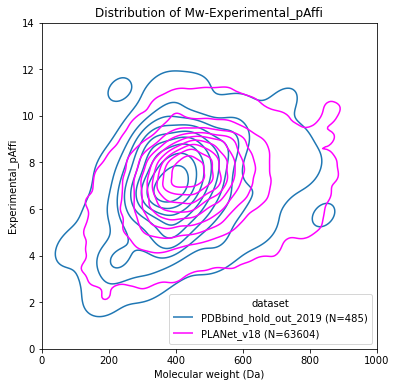

In [104]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=PDBbind_hold_prop, x='mw', y='-logAffi', color='tab:blue', thresh=0.01)
sns.kdeplot(data=PLANet_v18_property, x='mw', y='-logAffi', color='magenta', thresh=0.01)
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Experimental_pAffi")
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
ax.set_title(f'Distribution of Mw-Experimental_pAffi')
plt.legend(labels=[f'PDBbind_hold_out_2019 (N={len(PDBbind_hold_prop)})', f'PLANet_v18 (N={len(PLANet_v18_property)})'], title = "dataset", loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_match/PLANet_vs_hold_thresh_0.01.png', dpi=300, bbox_inches='tight')
# plt.close()

# PIPUP vs PDBbind_hold_out_2019

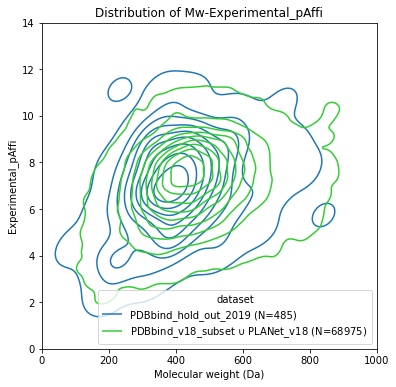

In [106]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=PDBbind_hold_prop, x='mw', y='-logAffi', color='tab:blue', thresh=0.01)
sns.kdeplot(data=PIPUP_df, x='mw', y='y_true', color='limegreen', thresh=0.01)
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Experimental_pAffi")
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
ax.set_title(f'Distribution of Mw-Experimental_pAffi')
plt.legend(labels=[f'PDBbind_hold_out_2019 (N={len(PDBbind_hold_prop)})', f'PDBbind_v18_subset '+r'$\cup{}$' + f' PLANet_v18 (N={len(PIPUP_df)})'], title = "dataset", loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_match/PIPUP_vs_hold_thresh_0.01.png', dpi=300, bbox_inches='tight')
# plt.close()

# PDBbind_v18_subset vs PLANet_v18

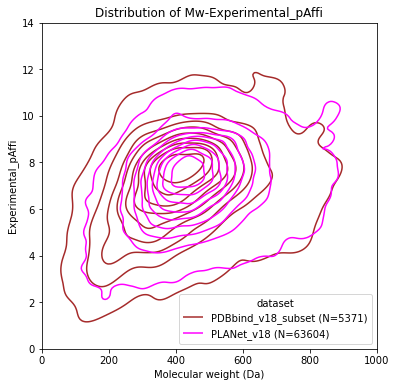

In [107]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=PDBbind_v18_subset_prop, x='mw', y='-logAffi', color='brown', thresh=0.01)
sns.kdeplot(data=PLANet_v18_property, x='mw', y='-logAffi', color='magenta', thresh=0.01)
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Experimental_pAffi")
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
ax.set_title(f'Distribution of Mw-Experimental_pAffi')
plt.legend(labels=[f'PDBbind_v18_subset (N={len(PDBbind_v18_subset_prop)})', f'PLANet_v18 (N={len(PLANet_v18_property)})'], title = "dataset", loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_match/PIP_vs_PLANet_thresh_0.01.png', dpi=300, bbox_inches='tight')
# plt.close()

# PLANet vs PIPUP

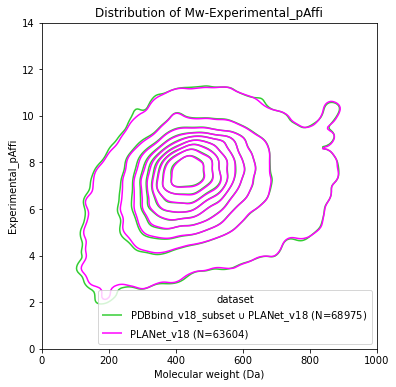

In [108]:
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=PIPUP_df, x='mw', y='y_true', color='limegreen', thresh=0.01)
sns.kdeplot(data=PLANet_v18_property, x='mw', y='-logAffi', color='magenta', thresh=0.01)
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Experimental_pAffi")
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
ax.set_title(f'Distribution of Mw-Experimental_pAffi')
plt.legend(labels=[ f'PDBbind_v18_subset '+r'$\cup{}$' + f' PLANet_v18 (N={len(PIPUP_df)})', f'PLANet_v18 (N={len(PLANet_v18_property)})'], title = "dataset", loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_match/PIPUP_vs_PLANet_thresh_0.01.png', dpi=300, bbox_inches='tight')
# plt.close()

# 4. similarity: 包含与PLANet_hold_out的相似性分析

In [118]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw, AllChem
from rdkit import DataStructs

In [111]:
PLANet_property.columns

Index(['unique_identify', '-logAffi', 'Target_chembl_id', 'Cry_lig_name',
       'Cry_lig_smiles', 'Cry_lig_an', 'Similar_compnd_name',
       'Similar_compnd_smiles', 'Similar_compnd_an', 'Similarity', 'Core_num',
       'Diff_an', 'Part_fix', 'Total_sampled_num', 'Similar_compnd_conform',
       'Total_delta', 'Lig_delta', 'Core_RMSD', 'MolWt', 'MCS_smarts',
       'target_compnd', 'mw', 'logp', 'rotb', 'hbd', 'hba', 'q', 'HA',
       'dataset'],
      dtype='object')

In [116]:
pdbbind_dir = '/pubhome/xli02/Downloads/dataset/PDBbind/PDBbind_v2019'

In [112]:
def obtain_training_fps(data_df, dataset_name):
    mols = []
    mol_fps = []
    skipped_mols = []
    for row in data_df.itertuples():
        if 'pdb_id' in data_df.columns.values:
            uniq_id = row.pdb_id
            lig_file = f'{pdbbind_dir}/general_structure_only/{uniq_id}/{uniq_id}_ligand.smi'
            if not Path(lig_file).exists():
                print(f'{uniq_id} of PDBbind not exsits, skipped.')
                skipped_mols.append(uniq_id)
                continue
            compnd_mol = Chem.SmilesMolSupplier(lig_file, delimiter='\t', titleLine=False)[0]
        else:
            uniq_id = row.unique_identify
            if '_' in uniq_id:
                if uniq_id not in list(PLANet_property['unique_identify']):
                    print(f'{uniq_id} of PLANet not exsits in smiles_df, skipped.')
                    skipped_mols.append(uniq_id)
                    continue
                compnd_smi = PLANet_property[PLANet_property['unique_identify']==uniq_id]['Similar_compnd_smiles'].values[0]
                compnd_mol = Chem.MolFromSmiles(compnd_smi)
            else:
                lig_file = f'{pdbbind_dir}/general_structure_only/{uniq_id}/{uniq_id}_ligand.smi'
                if not Path(lig_file).exists():
                    print(f'{uniq_id} of PDBbind not exsits, skipped.')
                    skipped_mols.append(uniq_id)
                    continue
                compnd_mol = Chem.SmilesMolSupplier(lig_file, delimiter='\t', titleLine=False)[0]
        if compnd_mol is None:
            print(f'For compounds in {dataset_name}, {uniq_id} cannot be read by rdkit, skipped.')
            skipped_mols.append(uniq_id)
            continue
        compnd_mol.SetProp('_Name', uniq_id)
        mols.append(compnd_mol)
        mol_fps.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(compnd_mol,2))
    return mols, mol_fps

In [207]:
def calculate_simi(hold_2019_mols, hold_2019_mol_fps, hold_2019_df, mols_2, mol_fps_2, affi_df_2, set_name_1, set_name_2):
    max_simi_for_hold_2019_mols = []
    cols = [f'{set_name_1}_name', f'{set_name_1}_affi', f'{set_name_1}_smiles', f'{set_name_2}_cpnd_name', f'{set_name_2}_cpnd_affi', f'{set_name_2}_cpnd_smiles', 'similarity']
    lst = []
    for i, mol in enumerate(hold_2019_mols):
        simi_list = DataStructs.BulkTanimotoSimilarity(hold_2019_mol_fps[i], mol_fps_2)
        mol_name = mol.GetProp('_Name')
        for j,simi in enumerate(simi_list):
            if simi > 0.8:
                # mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                if 'pdb_id' in hold_2019_df.columns.values:
                    mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                else:
                    mol_affi = hold_2019_df[hold_2019_df['unique_identify']==mol_name]['-logAffi'].values[0]
                mol_smiles = Chem.MolToSmiles(mol)
                mol_2_name = mols_2[j].GetProp('_Name')
                if 'pdb_id' in affi_df_2.columns.values:
                    mol_2_affi = affi_df_2[affi_df_2['pdb_id']==mol_2_name]['-logAffi'].values[0]
                else:
                    mol_2_affi = affi_df_2[affi_df_2['unique_identify']==mol_2_name]['-logAffi'].values[0]
                mol_2_smiles = Chem.MolToSmiles(mols_2[j])
                lst.append([mol_name, mol_affi, mol_smiles, mol_2_name, mol_2_affi, mol_2_smiles, simi])
        max_simi = max(simi_list)
        max_simi_for_hold_2019_mols.append(max_simi)
    out_dir = f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/{set_name_2}_in_{set_name_1}'
    if not Path(out_dir).exists():
        Path(out_dir).mkdir(parents=True)
    simi_9_df = pd.DataFrame(lst, columns=cols)
    simi_9_df.to_csv(f'{out_dir}/simi_0.8.csv', sep='\t', index=False)
    print(f'For {set_name_1}, there are {max_simi_for_hold_2019_mols.count(1)} / {len(max_simi_for_hold_2019_mols)} PDB IDs same as(similarity=1, not considering chirality) {set_name_2}.')
    print(f'similarity > 0.8: {len([n for n in max_simi_for_hold_2019_mols if n>0.8])} / {len(max_simi_for_hold_2019_mols)}')
    return max_simi_for_hold_2019_mols

In [114]:
models

['PDBbind_minimized_v18_subset',
 'PLANet_v18',
 'PDBbind_minimized_v18_subset_union_PLANet_v18']

# PDBbind_v18_subset training set

In [ ]:
PDBbind_v18_subset_train_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/PDBbind/pdbbind_v2019/minimized/dataset/PDBbind_minimized_v18_subset/complex_6A/train.csv', sep='\t')
PDBbind_v18_subset_train_mols, PDBbind_v18_subset_train_mol_fps = obtain_training_fps(PDBbind_v18_subset_train_df, 'PDBbind_v18_subset_train_set')

In [122]:
len(PDBbind_v18_subset_train_df)

4296

In [121]:
len(PDBbind_v18_subset_train_mols)

4281

# PLANet_v18 training set

In [120]:
PLANet_v18_train_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/dataset/true_lig_alone/whole_set/PLANet_v18/complex_6A/train.csv', sep='\t')
PLANet_v18_train_mols, PLANet_v18_train_mol_fps = obtain_training_fps(PLANet_v18_train_df, 'PLANet_v18_train_set')

In [123]:
len(PLANet_v18_train_df)

50883

In [124]:
len(PLANet_v18_train_mols)

50883

# PIPUP

In [ ]:
PIPUP_v18_train_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/dataset/true_lig_alone/whole_set/PDBbind_minimized_v18_subset_union_PLANet_v18/complex_6A/train.csv', sep='\t')
PIPUP_v18_train_mols, PIPUP_v18_train_mol_fps = obtain_training_fps(PIPUP_v18_train_df, 'PIPUP_v18_train_set')

In [126]:
len(PIPUP_v18_train_df)

55180

In [127]:
len(PIPUP_v18_train_mols)

55164

# 4.1 PDBbind_hold_out_2019

In [ ]:
PDBbind_hold_out_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PDBbind_subset/PDBbind_hold_out_2019_subset.csv', sep='\t')
PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps = obtain_training_fps(PDBbind_hold_out_df, 'PDBbind_hold_out')

In [133]:
len(PDBbind_hold_out_df)

485

In [483]:
len(PDBbind_hold_out_mols)

481

In [135]:
PDBbind_hold_out_mol_names = [mol.GetProp('_Name') for mol in PDBbind_hold_out_mols]

In [147]:
[n for n in max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset_train if n>0.9]

[0.9206349206349206]

In [146]:
# list(filter(lambda n: n > 0.9, max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset_train))

[0.9206349206349206]

In [151]:
max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset_train = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold_out_df, PDBbind_v18_subset_train_mols, PDBbind_v18_subset_train_mol_fps, PDBbind_v18_subset_train_df, f'PDBbind_hold_out_2019', 'PDBbind_v18_subset_train')
max_simi_for_PDBbind_hold_2019_test_Uw_train = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold_out_df, PLANet_v18_train_mols, PLANet_v18_train_mol_fps, PLANet_v18_train_df, f'PDBbind_hold_out_2019', 'PLANet_v18_train')
max_simi_for_PDBbind_hold_2019_test_PIPUP_train = calculate_simi(PDBbind_hold_out_mols, PDBbind_hold_out_mol_fps, PDBbind_hold_out_df, PIPUP_v18_train_mols, PIPUP_v18_train_mol_fps, PIPUP_v18_train_df, f'PDBbind_hold_out_2019', 'PIPUP_v18_train')

For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PDBbind_v18_subset_train.
similarity > 0.8: 3 / 481
For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PLANet_v18_train.
similarity > 0.8: 15 / 481
For PDBbind_hold_out_2019, there are 0 / 481 PDB IDs same as(similarity=1, not considering chirality) PIPUP_v18_train.
similarity > 0.8: 20 / 481


In [152]:
max_simi_distribution = pd.DataFrame({"pdb_id": PDBbind_hold_out_mol_names, "PDBbind_v18_subset": max_simi_for_PDBbind_hold_2019_test_PDBbind_v18_subset_train, "PLANet_v18": max_simi_for_PDBbind_hold_2019_test_Uw_train, "PDBbind_v18_subset_union_PLANet_v18": max_simi_for_PDBbind_hold_2019_test_PIPUP_train})
max_simi_distribution.to_csv(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/all_6_models_max_simi_distribution.csv', sep='\t', index=False)

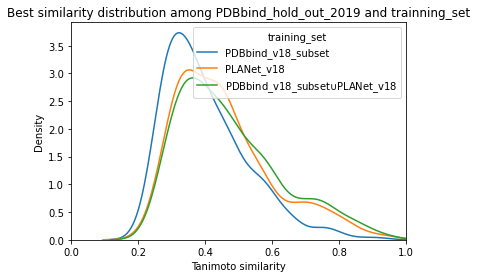

In [153]:
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset'])
sns.kdeplot(max_simi_distribution['PLANet_v18'])
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset_union_PLANet_v18'])
plt.xlabel("Tanimoto similarity")
plt.xlim(0,1)
plt.title(f'Best similarity distribution among PDBbind_hold_out_2019 and trainning_set')
plt.legend(labels=['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset' +r'$\cup$' 'PLANet_v18'], title = "training_set")
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/similarity/3_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 4.2 PLANet_hold_out_2019

In [200]:
PLANet_hold_out_df = pd.read_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/index/minimized/PLANet_hold_out_2019.csv', sep='\t')
PLANet_hold_out_mols, PLANet_hold_out_mol_fps = obtain_training_fps(PLANet_hold_out_df, 'PLANet_hold_out')

In [201]:
len(PLANet_hold_out_df)

5883

In [202]:
len(PLANet_hold_out_mols)

5883

In [203]:
PLANet_hold_out_mol_names = [mol.GetProp('_Name') for mol in PLANet_hold_out_mols]

In [209]:
def calculate_simi(hold_2019_mols, hold_2019_mol_fps, hold_2019_df, mols_2, mol_fps_2, affi_df_2, set_name_1, set_name_2):
    max_simi_for_hold_2019_mols = []
    cols = [f'{set_name_1}_name', f'{set_name_1}_affi', f'{set_name_1}_smiles', f'{set_name_2}_cpnd_name', f'{set_name_2}_cpnd_affi', f'{set_name_2}_cpnd_smiles', 'similarity']
    lst = []
    for i, mol in enumerate(hold_2019_mols):
        simi_list = DataStructs.BulkTanimotoSimilarity(hold_2019_mol_fps[i], mol_fps_2)
        mol_name = mol.GetProp('_Name')
        for j,simi in enumerate(simi_list):
            if simi > 0.8:
                # mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                if 'pdb_id' in hold_2019_df.columns.values:
                    mol_affi = hold_2019_df[hold_2019_df['pdb_id']==mol_name]['-logAffi'].values[0]
                else:
                    mol_affi = hold_2019_df[hold_2019_df['unique_identify']==mol_name]['-logAffi'].values[0]
                mol_smiles = Chem.MolToSmiles(mol)
                mol_2_name = mols_2[j].GetProp('_Name')
                if 'pdb_id' in affi_df_2.columns.values:
                    mol_2_affi = affi_df_2[affi_df_2['pdb_id']==mol_2_name]['-logAffi'].values[0]
                else:
                    mol_2_affi = affi_df_2[affi_df_2['unique_identify']==mol_2_name]['-logAffi'].values[0]
                mol_2_smiles = Chem.MolToSmiles(mols_2[j])
                lst.append([mol_name, mol_affi, mol_smiles, mol_2_name, mol_2_affi, mol_2_smiles, simi])
        max_simi = max(simi_list)
        max_simi_for_hold_2019_mols.append(max_simi)
    out_dir = f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/{set_name_2}_in_{set_name_1}' #
    if not Path(out_dir).exists():
        Path(out_dir).mkdir(parents=True)
    simi_9_df = pd.DataFrame(lst, columns=cols)
    simi_9_df.to_csv(f'{out_dir}/simi_0.8.csv', sep='\t', index=False)
    print(f'For {set_name_1}, there are {max_simi_for_hold_2019_mols.count(1)} / {len(max_simi_for_hold_2019_mols)} PDB IDs same as(similarity=1, not considering chirality) {set_name_2}.')
    print(f'similarity > 0.8: {len([n for n in max_simi_for_hold_2019_mols if n>0.8])} / {len(max_simi_for_hold_2019_mols)}')
    return max_simi_for_hold_2019_mols

In [210]:
max_simi_for_PLANet_hold_2019_test_PDBbind_v18_subset_train = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PDBbind_v18_subset_train_mols, PDBbind_v18_subset_train_mol_fps, PDBbind_v18_subset_train_df, f'PLANet_hold_out_2019', 'PDBbind_v18_subset_train')
max_simi_for_PLANet_hold_2019_test_Uw_train = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PLANet_v18_train_mols, PLANet_v18_train_mol_fps, PLANet_v18_train_df, f'PLANet_hold_out_2019', 'PLANet_v18_train')
max_simi_for_PLANet_hold_2019_test_PIPUP_train = calculate_simi(PLANet_hold_out_mols, PLANet_hold_out_mol_fps, PLANet_hold_out_df, PIPUP_v18_train_mols, PIPUP_v18_train_mol_fps, PIPUP_v18_train_df, f'PLANet_hold_out_2019', 'PIPUP_v18_train')

For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PDBbind_v18_subset_train.
similarity > 0.8: 10 / 5883
For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PLANet_v18_train.
similarity > 0.8: 350 / 5883
For PLANet_hold_out_2019, there are 0 / 5883 PDB IDs same as(similarity=1, not considering chirality) PIPUP_v18_train.
similarity > 0.8: 370 / 5883


In [211]:
max_simi_distribution = pd.DataFrame({"unique_identify": PLANet_hold_out_mol_names, "PDBbind_v18_subset": max_simi_for_PLANet_hold_2019_test_PDBbind_v18_subset_train, "PLANet_v18": max_simi_for_PLANet_hold_2019_test_Uw_train, "PDBbind_v18_subset_union_PLANet_v18": max_simi_for_PLANet_hold_2019_test_PIPUP_train})
max_simi_distribution.to_csv(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/all_6_models_max_simi_distribution.csv', sep='\t', index=False)

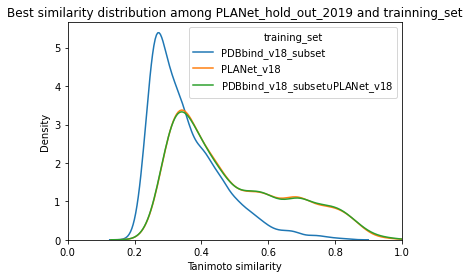

In [212]:
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset'])
sns.kdeplot(max_simi_distribution['PLANet_v18'])
sns.kdeplot(max_simi_distribution['PDBbind_v18_subset_union_PLANet_v18'])
plt.xlabel("Tanimoto similarity")
plt.xlim(0,1)
plt.title(f'Best similarity distribution among PLANet_hold_out_2019 and trainning_set')
plt.legend(labels=['PDBbind_v18_subset', 'PLANet_v18', 'PDBbind_v18_subset' +r'$\cup$' 'PLANet_v18'], title = "training_set")
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PLANet_hold_out_2019/similarity/3_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# 5. property distribution of PDBbind_hold_out_2019

In [154]:
PDBbind_hold_prop

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
168     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0
242     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0
652     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0
655     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0
666     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0
...      ...       ...      ...     ...   ...  ...  ...  ...   ...
17025   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17032   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
17049   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0
17073   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0
17083   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0

[485 rows x 9 columns]

In [237]:
PDBbind_hold_prop.reset_index(inplace=True, drop=True)

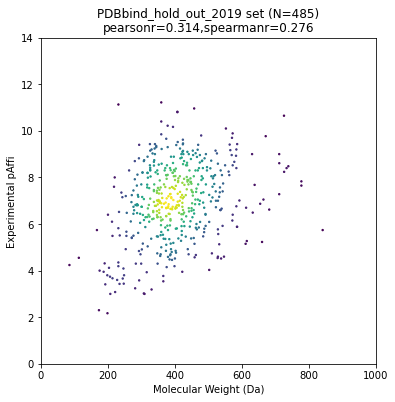

In [169]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop['mw'], PDBbind_hold_prop['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop['mw'][idx], PDBbind_hold_prop['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('Molecular Weight (Da)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0,1000)
ax.set_ylim(0,14)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/Mw_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

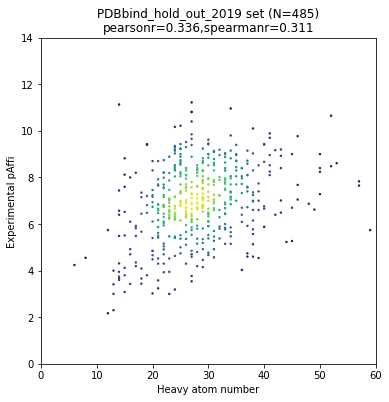

In [172]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop['HA'], PDBbind_hold_prop['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop['HA'][idx], PDBbind_hold_prop['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('Heavy atom number')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(0,60)
ax.set_ylim(0,14)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/HA_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

In [238]:
PDBbind_hold_prop

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA
0     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0
1     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0
2     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0
3     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0
4     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0
..     ...       ...      ...     ...   ...  ...  ...  ...   ...
480   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
481   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0
482   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0
483   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0
484   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0

[485 rows x 9 columns]

In [239]:
PDBbind_hold_prop_sasa = pd.merge(PDBbind_hold_prop, PDBbind_whole_sasa.rename(columns={'unique_identity':'pdb_id'}), on=['pdb_id'])
PDBbind_hold_prop_sasa

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA  lig_sasa  \
0     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0  3.537246   
1     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0  3.843836   
2     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0  3.653962   
3     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0  5.656953   
4     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0  5.215878   
..     ...       ...      ...     ...   ...  ...  ...  ...   ...       ...   
480   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.259465   
481   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.314178   
482   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0  7.792099   
483   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0  4.381822   
484   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0  6.230400   

       rec_sasa    com_sasa   del_sasa  
0    169.899353  161.762436  11.674164  
1    170.113678  166.014801   7.942719  
2    154.229050  142.052338  15.830673  
3    105.767990  105.343513   6.081429  
4    215.081009  215.483047   4.813843  
..          ...         ...        ...  
480  233.573181  240.532394  -0.699753  
481  235.785126  242.192078  -0.092773  
482  206.258041  209.102600   4.947540  
483  117.294327  114.550919   7.125229  
484  147.387054  144.508194   9.109268  

[485 rows x 13 columns]

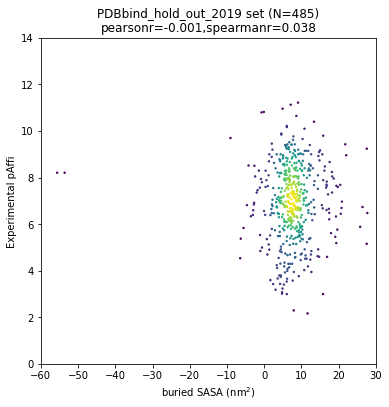

In [243]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop_sasa['del_sasa'][idx], PDBbind_hold_prop_sasa['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(-60,30)
ax.set_ylim(0,14)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop_sasa)})\npearsonr={pearsonr},spearmanr={spearmanr}')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/SASA_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'PDBbind_hold_out_2019 set (N=485)\npearsonr=-0.001,spearmanr=0.038')

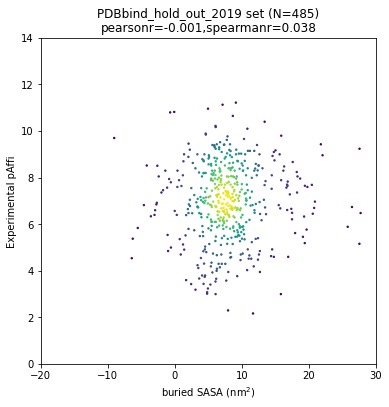

In [244]:
# RIP_minimized_PCV.reset_index(drop=True, inplace=True)
pearsonr = round(stats.pearsonr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)
spearmanr = round(stats.spearmanr(PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi'])[0],3)

xy = np.vstack([PDBbind_hold_prop_sasa['del_sasa'], PDBbind_hold_prop_sasa['-logAffi']])  #按行叠加
g = gaussian_kde(xy)  #根据xy进行核密度估计(kde) -> 关于xy的概率密度函数
z = g(xy)  #计算每个xy样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()  #对z值排序并返回索引
y, y_, z = PDBbind_hold_prop_sasa['del_sasa'][idx], PDBbind_hold_prop_sasa['-logAffi'][idx], z[idx]  #对y, y_根据z的大小进行排序

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y, y_, s=2, c=z, zorder=2)
ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
ax.set_ylabel('Experimental pAffi')
ax.set_xlim(-20,30)
ax.set_ylim(0,14)
plt.title(f'PDBbind_hold_out_2019 set (N={len(PDBbind_hold_prop_sasa)})\npearsonr={pearsonr},spearmanr={spearmanr}')
# plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/property_distribution/SASA_pAffi_scaled_1000.png', dpi=300, bbox_inches='tight')

# pfam

In [286]:
PDBbind_hold_prop_sasa

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA  lig_sasa  \
0     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0  3.537246   
1     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0  3.843836   
2     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0  3.653962   
3     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0  5.656953   
4     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0  5.215878   
..     ...       ...      ...     ...   ...  ...  ...  ...   ...       ...   
480   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.259465   
481   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.314178   
482   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0  7.792099   
483   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0  4.381822   
484   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0  6.230400   

       rec_sasa    com_sasa   del_sasa  
0    169.899353  161.762436  11.674164  
1    170.113678  166.014801   7.942719  
2    154.229050  142.052338  15.830673  
3    105.767990  105.343513   6.081429  
4    215.081009  215.483047   4.813843  
..          ...         ...        ...  
480  233.573181  240.532394  -0.699753  
481  235.785126  242.192078  -0.092773  
482  206.258041  209.102600   4.947540  
483  117.294327  114.550919   7.125229  
484  147.387054  144.508194   9.109268  

[485 rows x 13 columns]

In [304]:
PDBbind_v2020_cluster.columns

Index(['pdb', 'affinity', 'PCV_cluster', 'main_chain', 'res_num', 'pfam',
       'pfam_name', 'pdb_start', 'pdb_end', 'cov_num', 'clan_acc', 'clan_id',
       'uniport', 'seq', 'mol_weight', 'SCV_cluster', 'smina', 'year', 'Type'],
      dtype='object')

In [287]:
PDBbind_v2020_cluster = pd.read_csv('/pubhome/xli02/scripts/scripts_from_zhuhui/general_refine_classified.csv')
PDBbind_v2020_cluster_sel = PDBbind_v2020_cluster[['pdb', 'PCV_cluster']].copy()
PDBbind_v2020_cluster_sel.rename(columns={'pdb':'pdb_id'}, inplace=True)
PDBbind_v2020_cluster_sel

pdb_id PCV_cluster
0       4i7p    Lysozyme
1       1l83    Lysozyme
2       1li6    Lysozyme
3       4w52    Lysozyme
4       188l    Lysozyme
...      ...         ...
19434   5ylv     una_223
19435   3ump  Ribokinase
19436   4q3r    Arginase
19437   1ind          Ig
19438   2iw9     pkinase

[19439 rows x 2 columns]

In [289]:
PDBbind_hold_prop_sasa_Pfam = pd.merge(PDBbind_hold_prop_sasa, PDBbind_v2020_cluster_sel, on='pdb_id')
PDBbind_hold_prop_sasa_Pfam

pdb_id  -logAffi       mw    logp  rotb  hbd  hba    q    HA  lig_sasa  \
0     6gmx      2.17  198.674  3.0185   0.0  0.0  2.0  0.0  12.0  3.537246   
1     6gmq      2.30  173.215  1.9696   2.0  1.0  2.0  0.0  13.0  3.843836   
2     5ye8      3.00  207.201  1.3363   2.0  1.0  2.0  0.0  13.0  3.653962   
3     6ftz      3.00  309.349  1.2610   4.0  4.0  2.0  1.0  23.0  5.656953   
4     6f6n      3.02  307.244  4.1534   2.0  1.0  0.0  1.0  20.0  5.215878   
..     ...       ...      ...     ...   ...  ...  ...  ...   ...       ...   
480   6h5w     10.80  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.259465   
481   6h5x     10.82  407.537  0.6063   5.0  2.0  6.0 -1.0  27.0  6.314178   
482   5nn0     10.96  457.662  1.8888   7.0  2.0  1.0  2.0  34.0  7.792099   
483   5llg     11.13  231.342  1.8361   4.0  1.0  3.0  0.0  14.0  4.381822   
484   5qim     11.22  359.389  3.6539   4.0  2.0  5.0  0.0  27.0  6.230400   

       rec_sasa    com_sasa   del_sasa     PCV_cluster  
0    169.899353  161.762436  11.674164         una_579  
1    170.113678  166.014801   7.942719   Transthyretin  
2    154.229050  142.052338  15.830673    AB_hydrolase  
3    105.767990  105.343513   6.081429    Peptidase_PA  
4    215.081009  215.483047   4.813843         una_204  
..          ...         ...        ...             ...  
480  233.573181  240.532394  -0.699753    Peptidase_MA  
481  235.785126  242.192078  -0.092773    Peptidase_MA  
482  206.258041  209.102600   4.947540    AB_hydrolase  
483  117.294327  114.550919   7.125229  Carb_anhydrase  
484  147.387054  144.508194   9.109268         pkinase  

[485 rows x 14 columns]

In [290]:
len(set(PDBbind_hold_prop_sasa_Pfam['PCV_cluster']))

72

In [292]:
PCV_count_df = pd.DataFrame({'count':PDBbind_hold_prop_sasa_Pfam.groupby('PCV_cluster').size()}).reset_index()
PCV_count_df.sort_values(by='count', ascending=False).head(10)

PCV_cluster  count
61         pkinase    116
15  Carb_anhydrase     36
11     Bromodomain     35
60   hormone_recep     21
28    His_Kinase_A     19
27       HD_PDEase     17
23          GPCR_A     15
48    Peptidase_PA     15
5         Arginase     14
0     AB_hydrolase     11

In [347]:
PCV_count_df[PCV_count_df['PCV_cluster']=='P53-like']

PCV_cluster  count
38    P53-like      8

In [293]:
top10_clusters=list(PCV_count_df.sort_values(by='count', ascending=False).head(10)['PCV_cluster'])
top10_clusters

['pkinase',
 'Carb_anhydrase',
 'Bromodomain',
 'hormone_recep',
 'His_Kinase_A',
 'HD_PDEase',
 'GPCR_A',
 'Peptidase_PA',
 'Arginase',
 'AB_hydrolase']

In [294]:
test_dir

'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/test_result'

In [ ]:
# PDBbind_v2020_cluster_sel.rename(columns={'pdb_id':'unique_identify'})

In [297]:
pfam_label_to_res_dict = defaultdict(list)
for model in models:
    for tp in tps:
        res_df = pd.read_csv(f'{test_dir}/test_on_PDBbind_hold_out_2019/{model}_{tp}/test.csv', sep='\t')
        res_df_with_PCV = pd.merge(res_df, PDBbind_v2020_cluster_sel.rename(columns={'pdb_id':'unique_identify'}), on='unique_identify')
        for cluster in top10_clusters:
            hold_out_cluster = res_df_with_PCV[res_df_with_PCV['PCV_cluster']==cluster].copy()
            for i in range(5):
                r2 = r2_score(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                mae = mean_absolute_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                mse = mean_squared_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
                pearsonr = stats.pearsonr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
                spearmanr = stats.spearmanr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
                pfam_label_to_res_dict[f'{model}_{tp}_{i+1}_cluster_{cluster}']=[r2, mae, mse, pearsonr, spearmanr]
        cluster='others'
        hold_out_cluster = res_df_with_PCV[~res_df_with_PCV['PCV_cluster'].isin(top10_clusters)].copy()
        for i in range(5):
            r2 = r2_score(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            mae = mean_absolute_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            mse = mean_squared_error(y_true=hold_out_cluster['y_true'], y_pred=hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])
            pearsonr = stats.pearsonr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
            spearmanr = stats.spearmanr(hold_out_cluster['y_true'], hold_out_cluster[f'{model}_{tp}_{i+1}_pred'])[0]
            pfam_label_to_res_dict[f'{model}_{tp}_{i+1}_cluster_{cluster}']=[r2, mae, mse, pearsonr, spearmanr]

In [314]:
pfam_sum_df = pd.DataFrame.from_dict(pfam_label_to_res_dict, orient='index', columns=['r2', 'mae', 'mse', 'pearsonr', 'spearmanr']).reset_index()
pfam_sum_df['rmse']= np.sqrt(pfam_sum_df['mse'])
pfam_sum_df.rename(columns={"index": "model_names_test_type_cluster"}, inplace=True)
pfam_sum_df['cluster'] = pfam_sum_df['model_names_test_type_cluster'].str.rsplit('cluster_', n=1).str[1]
pfam_sum_df['model_names_test_type'] = pfam_sum_df['model_names_test_type_cluster'].str.rsplit('_cluster', n=1).str[0]
pfam_sum_df['model_tp'] = pfam_sum_df['model_names_test_type'].str.rsplit('_', n=1).str[0]
pfam_sum_df['type'] = ['cmx' if 'cmx' in m else 'ligand_alone' for m in pfam_sum_df['model_tp']]
pfam_sum_df['dataset'] = ['_'.join(m.split('_')[:-1]) if 'cmx' in m else '_'.join(m.split('_')[:-2]) for m in pfam_sum_df['model_tp']]
pfam_sum_df.to_csv('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/6_models_5_repeats_metrics.csv', sep='\t', index=False)
pfam_sum_df

model_names_test_type_cluster        r2       mae  \
0    PDBbind_minimized_v18_subset_cmx_1_cluster_pki...  0.149431  1.036605   
1    PDBbind_minimized_v18_subset_cmx_2_cluster_pki...  0.211704  0.982407   
2    PDBbind_minimized_v18_subset_cmx_3_cluster_pki...  0.271975  0.929645   
3    PDBbind_minimized_v18_subset_cmx_4_cluster_pki...  0.200565  0.995522   
4    PDBbind_minimized_v18_subset_cmx_5_cluster_pki...  0.253241  0.927449   
..                                                 ...       ...       ...   
325  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.220794  1.181594   
326  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.217454  1.213937   
327  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.162055  1.201342   
328  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.202311  1.209544   
329  PDBbind_minimized_v18_subset_union_PLANet_v18_...  0.262608  1.157178   

          mse  pearsonr  spearmanr      rmse  cluster  \
0    1.624902  0.438341   0.305339  1.274717  pkinase   
1    1.505938  0.496992   0.366061  1.227167  pkinase   
2    1.390798  0.532975   0.409728  1.179321  pkinase   
3    1.527217  0.502132   0.416103  1.235806  pkinase   
4    1.426587  0.533433   0.435776  1.194398  pkinase   
..        ...       ...        ...       ...      ...   
325  2.254925  0.503167   0.459963  1.501641   others   
326  2.264590  0.491584   0.425641  1.504855   others   
327  2.424908  0.489370   0.465785  1.557211   others   
328  2.308411  0.485595   0.453757  1.519346   others   
329  2.133919  0.540687   0.504142  1.460794   others   

                                 model_names_test_type  \
0                   PDBbind_minimized_v18_subset_cmx_1   
1                   PDBbind_minimized_v18_subset_cmx_2   
2                   PDBbind_minimized_v18_subset_cmx_3   
3                   PDBbind_minimized_v18_subset_cmx_4   
4                   PDBbind_minimized_v18_subset_cmx_5   
..                                                 ...   
325  PDBbind_minimized_v18_subset_union_PLANet_v18_...   
326  PDBbind_minimized_v18_subset_union_PLANet_v18_...   
327  PDBbind_minimized_v18_subset_union_PLANet_v18_...   
328  PDBbind_minimized_v18_subset_union_PLANet_v18_...   
329  PDBbind_minimized_v18_subset_union_PLANet_v18_...   

                                              model_tp          type  \
0                     PDBbind_minimized_v18_subset_cmx           cmx   
1                     PDBbind_minimized_v18_subset_cmx           cmx   
2                     PDBbind_minimized_v18_subset_cmx           cmx   
3                     PDBbind_minimized_v18_subset_cmx           cmx   
4                     PDBbind_minimized_v18_subset_cmx           cmx   
..                                                 ...           ...   
325  PDBbind_minimized_v18_subset_union_PLANet_v18_...  ligand_alone   
326  PDBbind_minimized_v18_subset_union_PLANet_v18_...  ligand_alone   
327  PDBbind_minimized_v18_subset_union_PLANet_v18_...  ligand_alone   
328  PDBbind_minimized_v18_subset_union_PLANet_v18_...  ligand_alone   
329  PDBbind_minimized_v18_subset_union_PLANet_v18_...  ligand_alone   

                                           dataset  
0                     PDBbind_minimized_v18_subset  
1                     PDBbind_minimized_v18_subset  
2                     PDBbind_minimized_v18_subset  
3                     PDBbind_minimized_v18_subset  
4                     PDBbind_minimized_v18_subset  
..                                             ...  
325  PDBbind_minimized_v18_subset_union_PLANet_v18  
326  PDBbind_minimized_v18_subset_union_PLANet_v18  
327  PDBbind_minimized_v18_subset_union_PLANet_v18  
328  PDBbind_minimized_v18_subset_union_PLANet_v18  
329  PDBbind_minimized_v18_subset_union_PLANet_v18  

[330 rows x 12 columns]

In [477]:
cluster_11_count = {}
for cluster in top10_clusters+['others']:
    if cluster != 'others':
        cluster_11_count[cluster]=PCV_count_df[PCV_count_df['PCV_cluster']==cluster]['count'].values[0]
    else:
        cluster_11_count[cluster]=187 #
cluster_11_count['hormone_recep']=20
cluster_11_count


{'pkinase': 116,
 'Carb_anhydrase': 36,
 'Bromodomain': 35,
 'hormone_recep': 20,
 'His_Kinase_A': 19,
 'HD_PDEase': 17,
 'GPCR_A': 15,
 'Peptidase_PA': 15,
 'Arginase': 14,
 'AB_hydrolase': 11,
 'others': 187}

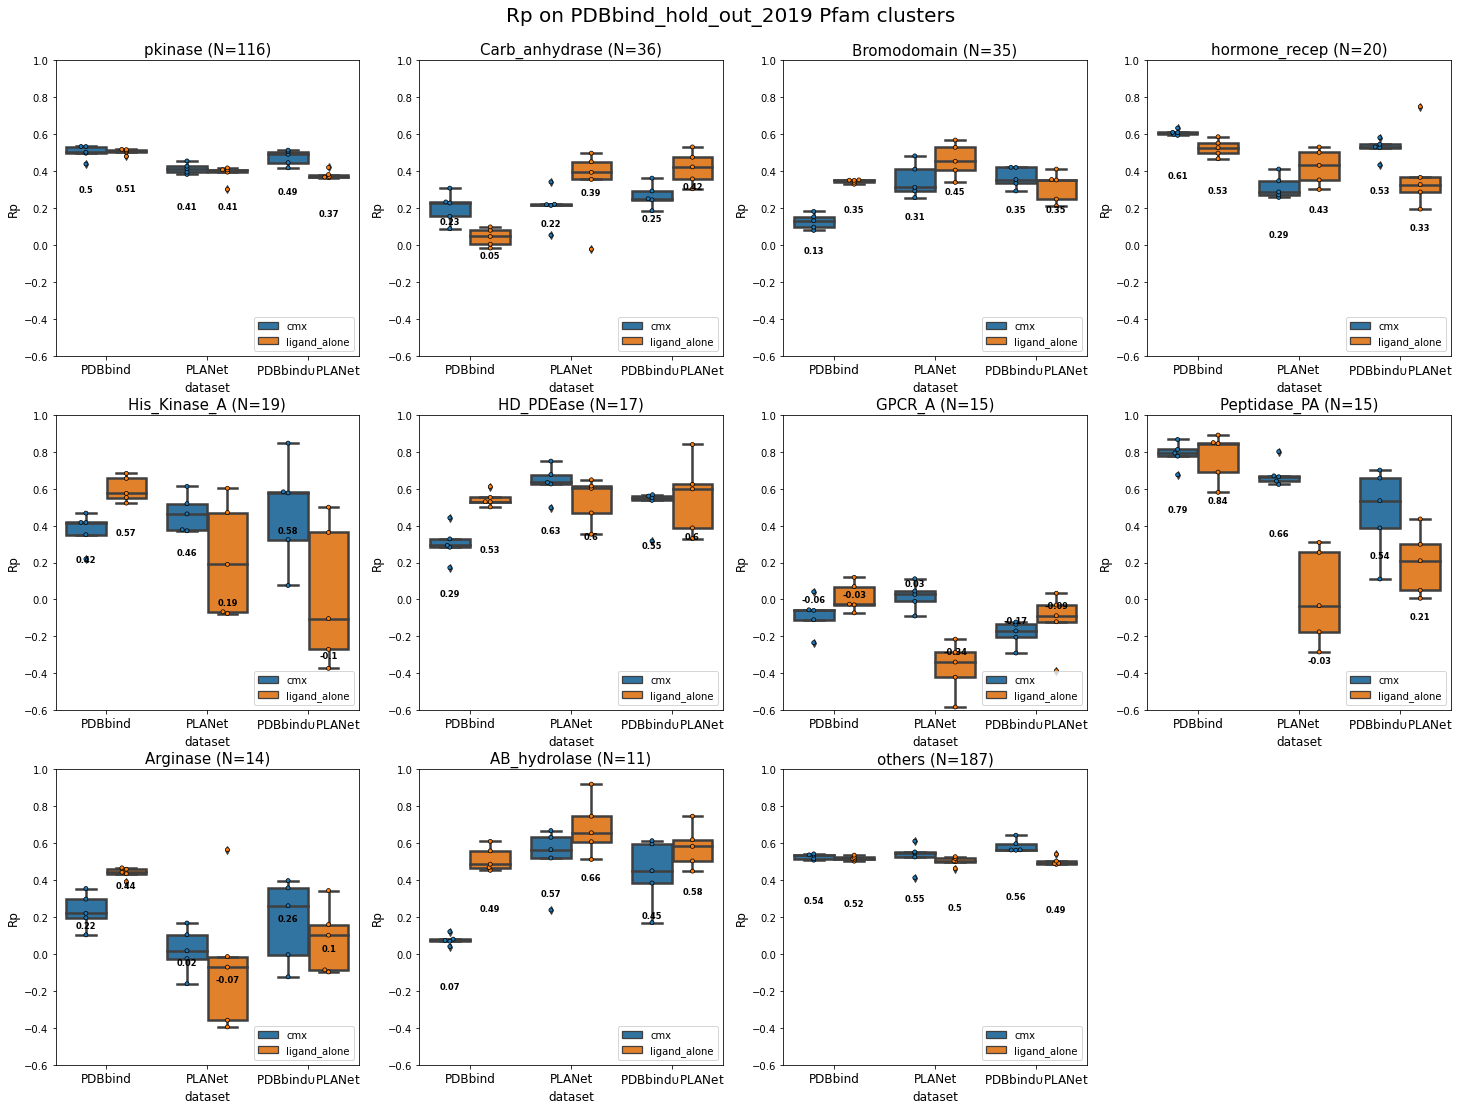

In [478]:
metric='pearsonr'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='lower right')
    vertical_offset = cluster_sum_df[metric].median() * 0.5 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='PBP':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(-0.6,1)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('Rp', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('Rp on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

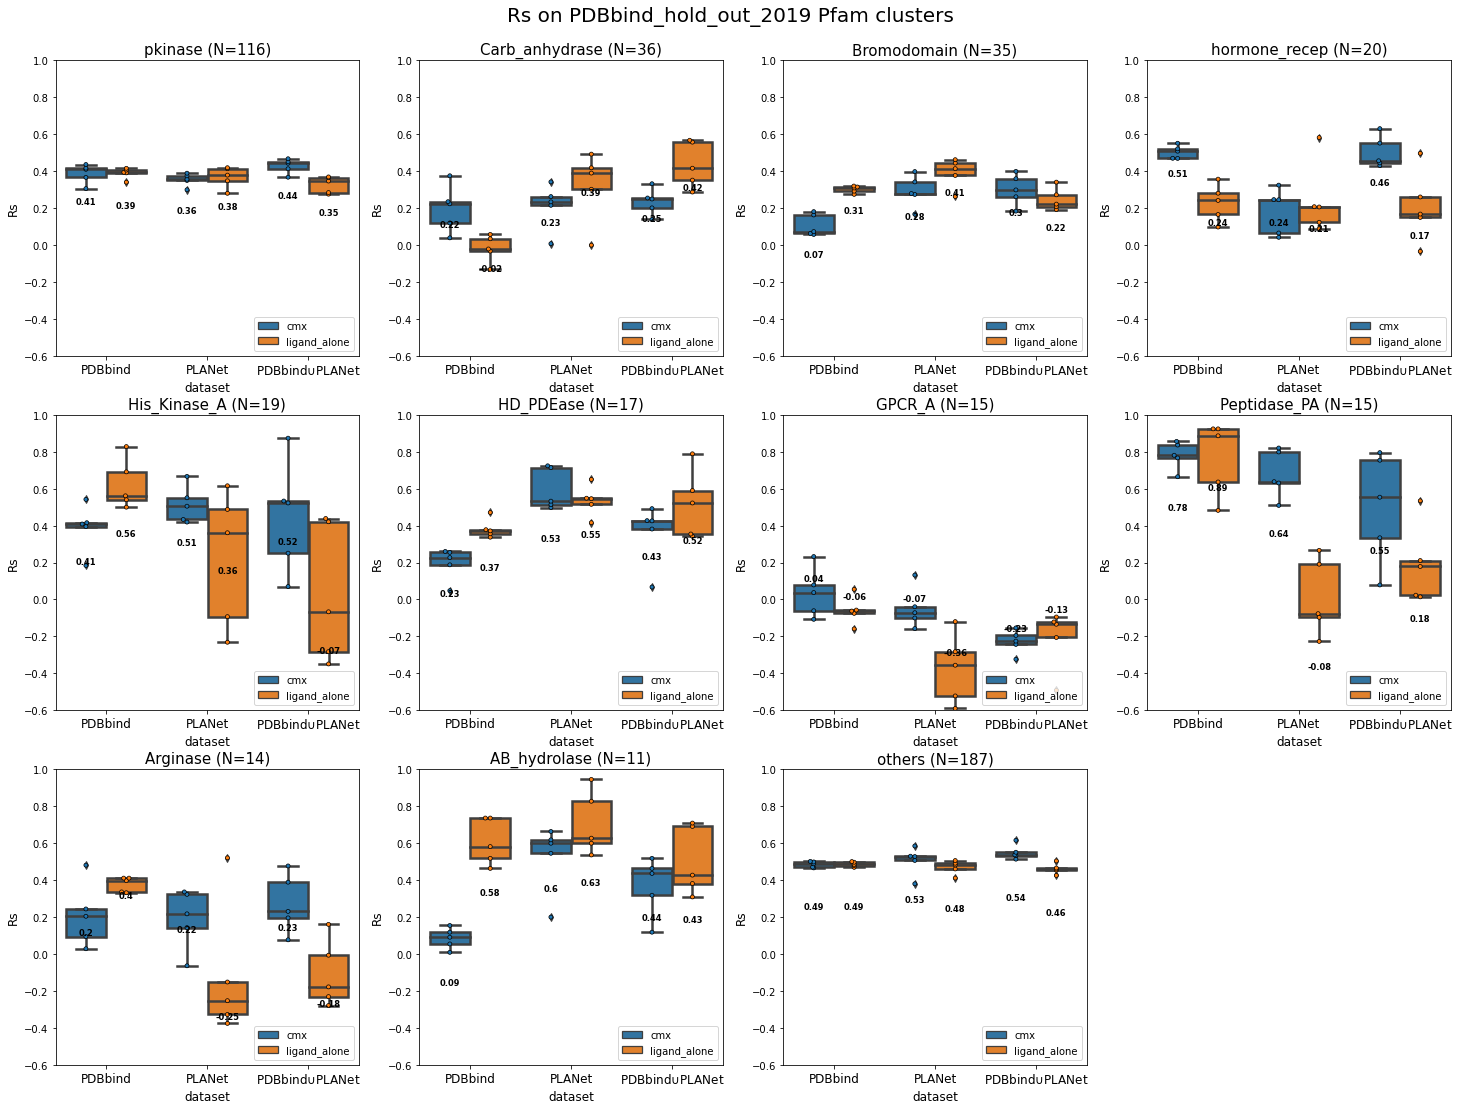

In [479]:
metric='spearmanr'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc='lower right')
    vertical_offset = cluster_sum_df[metric].median() * 0.5 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='PBP':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(-0.6,1)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('Rs', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('Rs on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

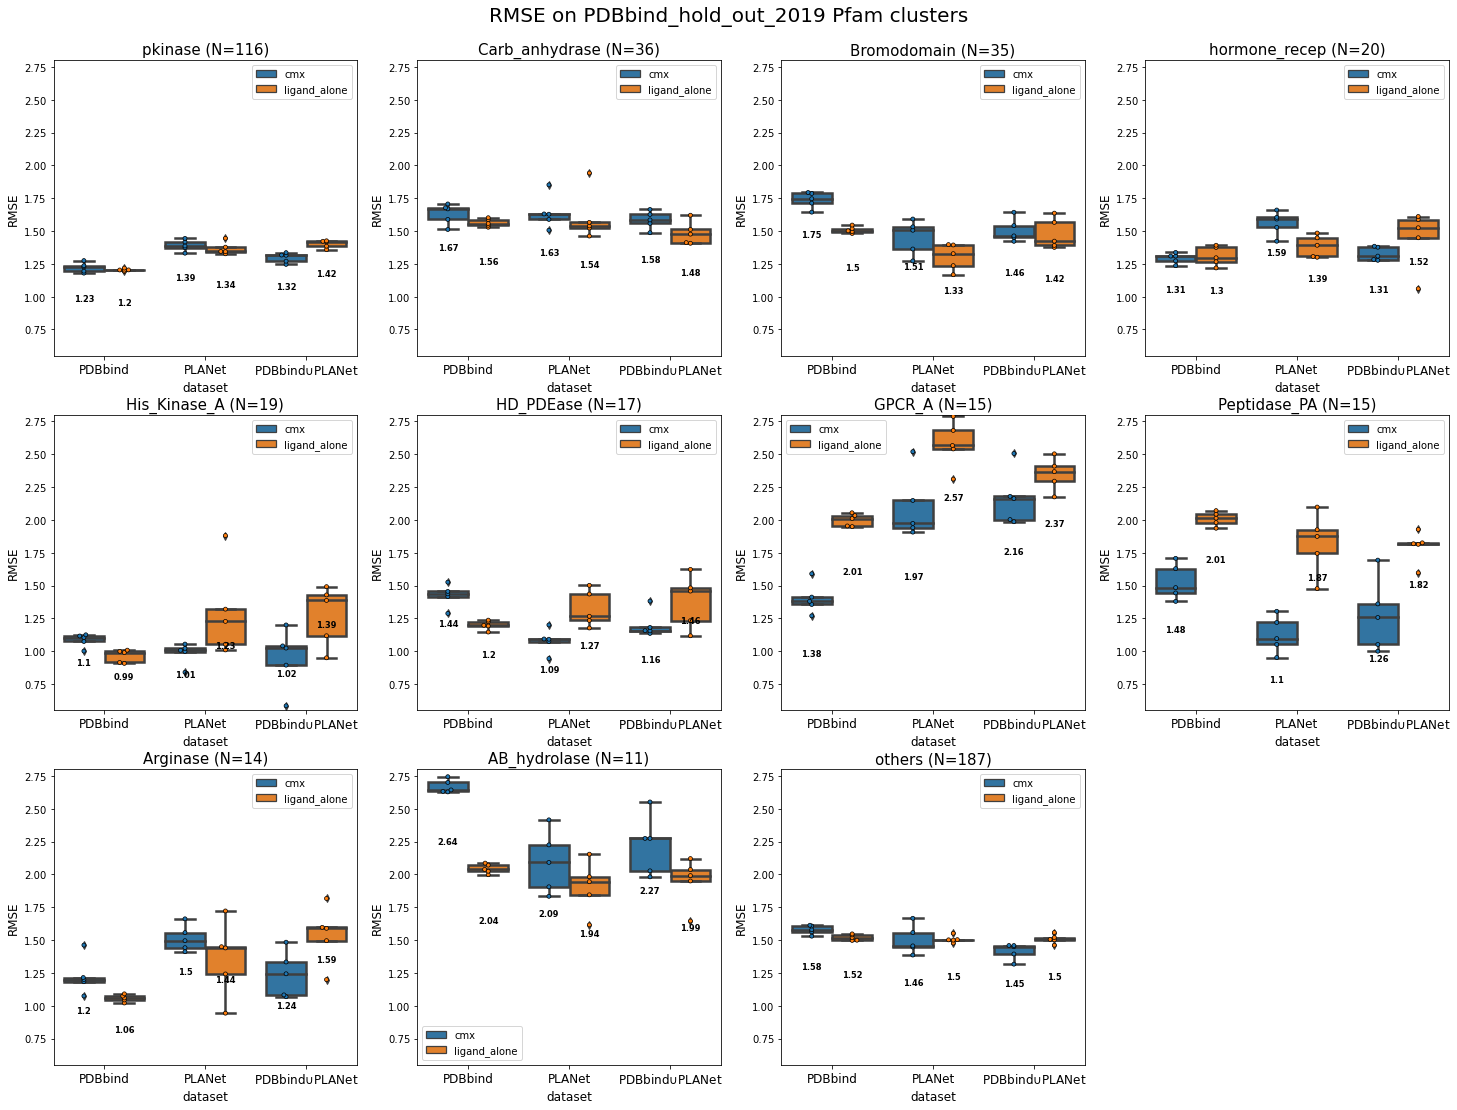

In [480]:
metric='rmse'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    vertical_offset = cluster_sum_df[metric].median() * 0.2 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='PBP':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(0.55,2.8)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('RMSE on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

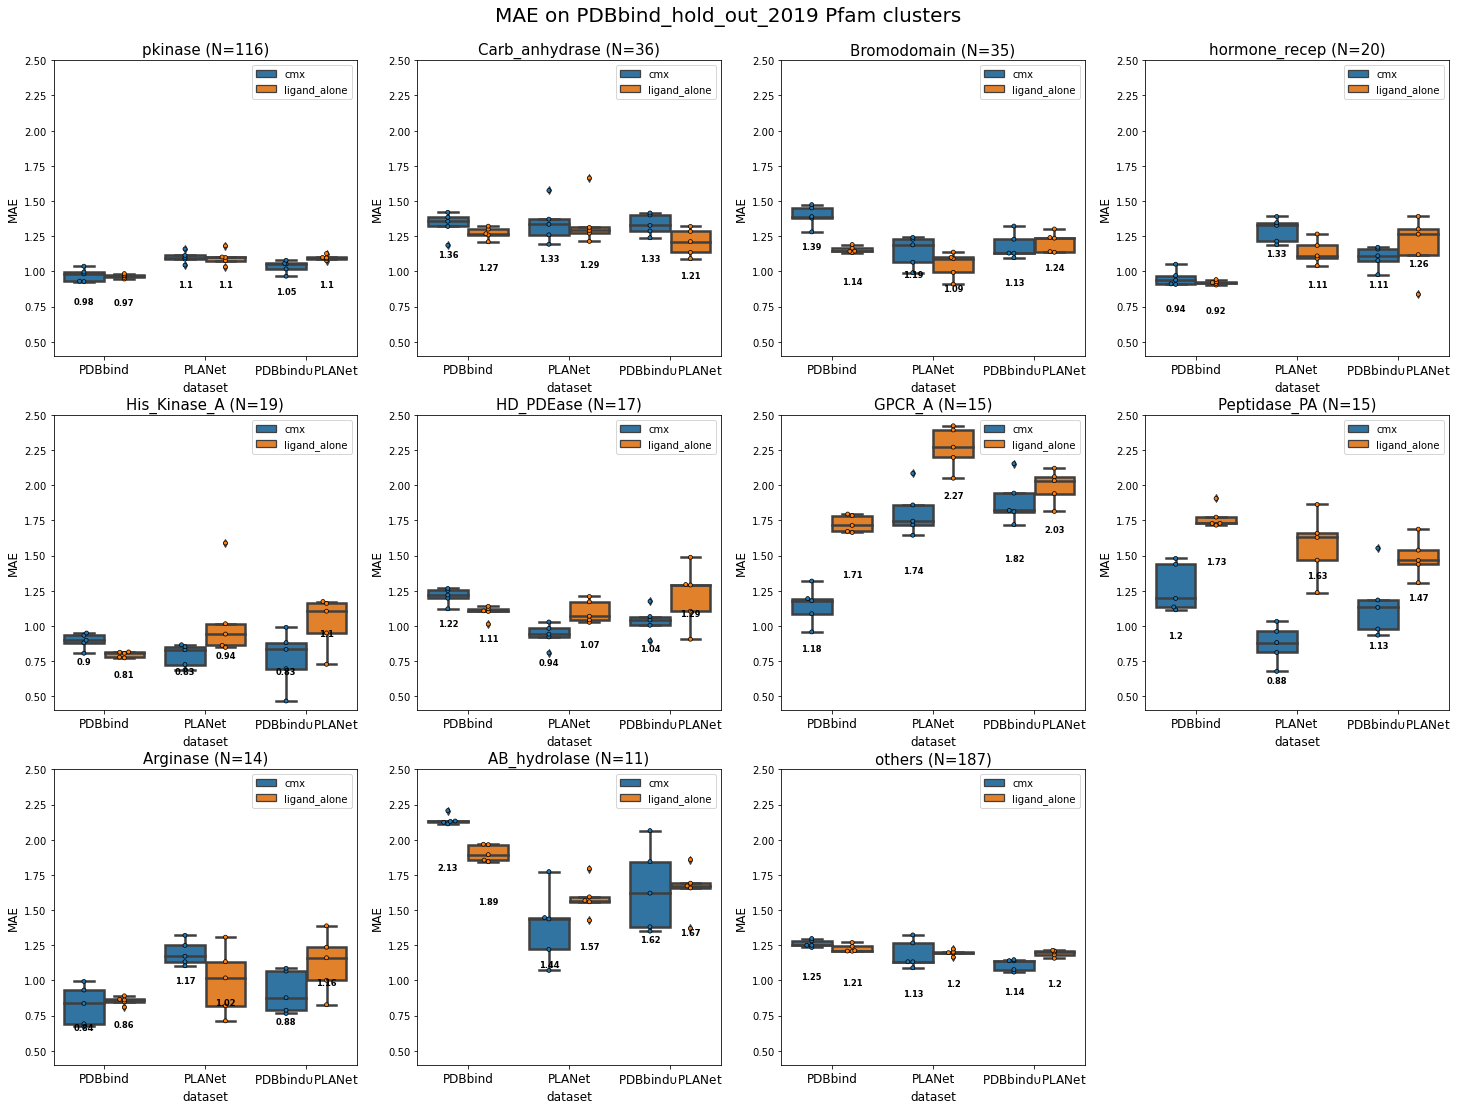

In [481]:
metric='mae'
fig = plt.figure(figsize=(25,25))
for i, cluster in enumerate(top10_clusters+['others']):
    cluster_sum_df = pfam_sum_df[pfam_sum_df['cluster']==cluster]
    grouped_median_cluster = cluster_sum_df.groupby(['dataset', 'type']).median().reset_index()
    grouped_median_cluster['model_name'] = [f'{row.dataset}_{row.type}' for row in grouped_median_cluster.itertuples()]
    
    ax = fig.add_subplot(4, 4, i+1)
    sns.boxplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, linewidth=2.5)
    sns.swarmplot(x="dataset", y=metric, data=cluster_sum_df, hue="type", order = models, size = 4, dodge=True, edgecolor="black", linewidth=0.7)

    ax.set_title(f'{cluster} (N={cluster_11_count[cluster]})', fontsize=15)
    # fig.autofmt_xdate()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    vertical_offset = cluster_sum_df[metric].median() * 0.2 # offset from median for display
    for i, modl in enumerate(models):
        for tp in ['cmx', 'ligand_alone']:
            median_metric = round(grouped_median_cluster.loc[(grouped_median_cluster['model_name'] == f'{modl}_{tp}')][metric].values[0], 2)
            if cluster=='PBP':
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-0.15, median_metric, horizontalalignment='center',size='small',weight='semibold')
            else:
                if tp == 'cmx':
                    ax.text(i-.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small', weight='semibold')
                else:
                    ax.text(i+.2, median_metric-vertical_offset, median_metric, horizontalalignment='center',size='small',weight='semibold')
    ax.set_ylim(0.4,2.5)
    ax.set_xticklabels(['PDBbind', 'PLANet', 'PDBbind'+r'$\cup{}$' + 'PLANet'], fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_xlabel('dataset', fontsize=12)
plt.suptitle('MAE on PDBbind_hold_out_2019 Pfam clusters', y=0.91, fontsize=20)
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/pfam_cluster/top10_clusters_{metric}_mean_of_5_repeat_models.png', dpi=300, bbox_inches='tight')
# plt.close()

# HD_PDEase

In [352]:
mean_pred_df

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
0              5eng    5.85                               5.380701   
1              5ep7    5.40                               3.944631   
2              5fxq    7.85                               7.675058   
3              5fxs    8.05                               7.410508   
4              5g2b    7.00                               9.180742   
..              ...     ...                                    ...   
476            6m9t    7.70                               7.712587   
477            6ma5    8.10                               6.400635   
478            6mrg    7.55                               6.946436   
479            6mx8    9.43                               7.895870   
480            6nao    6.70                               7.266832   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
0                                       6.926975             6.109479   
1                                       5.104884             5.572817   
2                                       8.337734             6.231024   
3                                       8.598834             7.421319   
4                                       7.783034             7.925518   
..                                           ...                  ...   
476                                     6.622941             7.343087   
477                                     6.937207             6.370486   
478                                     6.864380             6.536760   
479                                     7.646135             8.449475   
480                                     6.583043             5.805114   

     PLANet_v18_lig_alone_mean  \
0                     6.134713   
1                     4.738019   
2                     8.289605   
3                     8.355122   
4                     6.687080   
..                         ...   
476                   6.481245   
477                   5.756728   
478                   6.696309   
479                   8.546027   
480                   6.293966   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
0                                             5.598933        
1                                             4.992645        
2                                             6.583290        
3                                             7.449681        
4                                             8.600389        
..                                                 ...        
476                                           8.256964        
477                                           6.755843        
478                                           6.555857        
479                                           8.239832        
480                                           6.408082        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
0                                             6.653835              
1                                             5.605777              
2                                             7.886528              
3                                             8.070054              
4                                             6.333493              
..                                                 ...              
476                                           6.607823              
477                                           5.779567              
478                                           7.211950              
479                                           8.388421              
480                                           6.939303              

     d(PLANet_cmx-PDBbind_cmx)  
0                     0.728778  
1                     1.628186  
2                     1.444034  
3                     0.010811  
4                     1.255223  
..                         ...  
476                   0.369500  
477                   0.030

In [354]:
mean_pred_df_prop_sasa_pfam = mean_pred_df.round({'y_true': 2}).merge(PDBbind_hold_prop_sasa_Pfam.rename(columns={'pdb_id':'unique_identify', '-logAffi':'y_true'}), on=['unique_identify', 'y_true']).copy()

In [399]:
hold_out_hdpdease_mean_pred = mean_pred_df_prop_sasa_pfam[mean_pred_df_prop_sasa_pfam['PCV_cluster']=='HD_PDEase'].copy()
hold_out_hdpdease_mean_pred

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
4              5g2b    7.00                               9.180742   
5              5g57    8.40                               8.934470   
6              5g5v    6.70                               8.595950   
22             5l8c    7.00                               8.395043   
23             5l8y    6.40                               9.262081   
24             5l9h    6.40                               7.962449   
25             5laq    9.20                               8.338660   
99             5w6e    8.04                               8.015800   
171            5zz2    8.85                               7.776954   
177            6acb    9.41                               8.565758   
239            6c7e    8.55                               7.623232   
240            6c7f    9.62                               8.496356   
241            6c7g    7.74                               8.200454   
242            6c7i    9.42                               8.743238   
243            6c7j    8.88                               8.577528   
362            6f6u    4.80                               6.732353   
364            6f8u    6.10                               7.834495   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
4                                       7.783034             7.925518   
5                                       7.950130             8.174199   
6                                       7.794888             7.903600   
22                                      7.728829             7.394662   
23                                      8.099895             8.163469   
24                                      7.366215             7.358520   
25                                      8.363998             7.790786   
99                                      7.191557             7.339603   
171                                     7.927867             8.520183   
177                                     8.455546             8.168135   
239                                     7.451552             8.220814   
240                                     7.683361             8.616704   
241                                     8.079151             8.565682   
242                                     7.639334             8.764636   
243                                     7.854627             8.096866   
362                                     6.776403             6.622976   
364                                     7.302825             6.919837   

     PLANet_v18_lig_alone_mean  \
4                     6.687080   
5                     7.165953   
6                     6.881386   
22                    6.877983   
23                    6.902740   
24                    6.797401   
25                    7.275914   
99                    6.761337   
171                   6.982639   
177                   7.084803   
239                   7.872523   
240                   8.123290   
241                   7.433943   
242                   7.756589   
243                   8.061899   
362                   6.374808   
364                   6.563905   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
4                                             8.600389        
5                                             8.240639        
6                                             7.531475        
22                                            8.154192        
23                                            8.794344        
24                                            7.590480        
25                                            7.591649        
99                                            7.782752        
171                                           8.157170        
177                                           8.398100        
239                                           7.807775        
240                                           8.477967     

In [358]:
hold_out_hdpdease_mean_pred_melted = hold_out_hdpdease_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')
# hold_out_hdpdease_mean_pred_melted

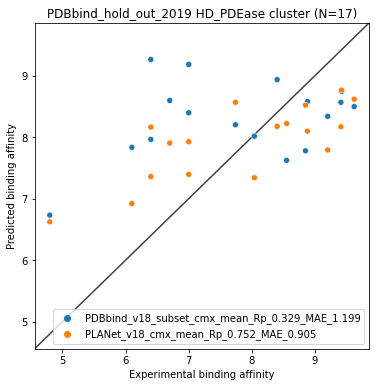

In [369]:
# PIP_PLANet_cmx_kinase = kinase_mean_pred_df_melted[kinase_mean_pred_df_melted['model'].isin(['PDBbind_minimized_intersected_Uw_cmx_mean', 'PLANet_Uw_cmx_mean'])].copy()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=hold_out_hdpdease_mean_pred_melted, x="y_true", y="value", hue='model')
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{round(stats.pearsonr(hold_out_hdpdease_mean_pred["y_true"], hold_out_hdpdease_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_hdpdease_mean_pred[f"y_true"], hold_out_hdpdease_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{round(stats.pearsonr(hold_out_hdpdease_mean_pred["y_true"], hold_out_hdpdease_mean_pred["PLANet_v18_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_hdpdease_mean_pred[f"y_true"], hold_out_hdpdease_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HD_PDEase_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')

In [387]:
hold_out_hdpdease_mean_pred.columns

Index(['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean',
       'PDBbind_minimized_v18_subset_lig_alone_mean', 'PLANet_v18_cmx_mean',
       'PLANet_v18_lig_alone_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean',
       'PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean',
       'd(PLANet_cmx-PDBbind_cmx)', 'mw', 'logp', 'rotb', 'hbd', 'hba', 'q',
       'HA', 'lig_sasa', 'rec_sasa', 'com_sasa', 'del_sasa', 'PCV_cluster'],
      dtype='object')

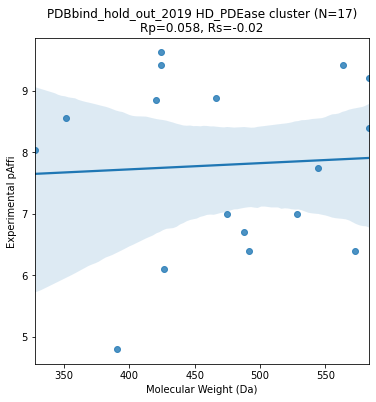

In [396]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hdpdease_mean_pred, x="mw", y="y_true")

plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hdpdease_mean_pred["mw"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hdpdease_mean_pred["mw"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HD_PDEase_scatter_Mw_experimental_pAffi.png', dpi=300, bbox_inches='tight')

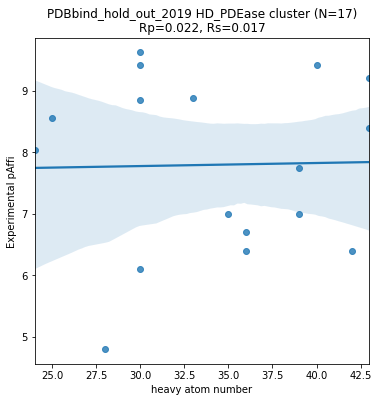

In [395]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hdpdease_mean_pred, x="HA", y="y_true")

plt.xlabel("heavy atom number")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hdpdease_mean_pred["HA"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hdpdease_mean_pred["HA"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HD_PDEase_scatter_HA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

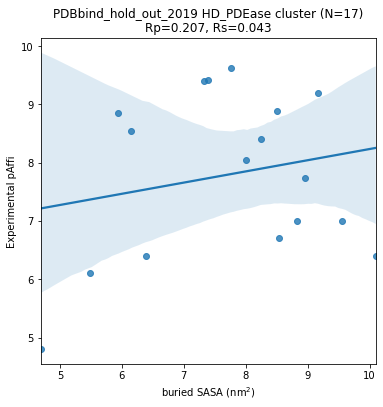

In [394]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hdpdease_mean_pred, x="del_sasa", y="y_true")
# ax.set_ylim(5.5,10)
plt.xlabel("buried SASA (nm$\mathregular{^2}$)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hdpdease_mean_pred["del_sasa"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hdpdease_mean_pred["del_sasa"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HD_PDEase_scatter_SASA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

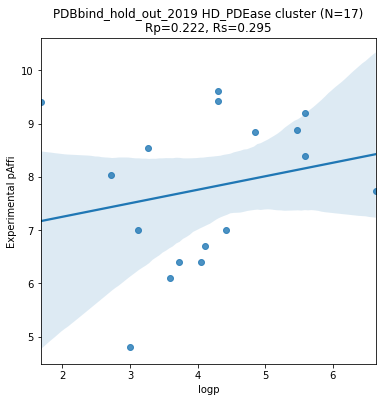

In [397]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hdpdease_mean_pred, x="logp", y="y_true")
# ax.set_ylim(5.5,10)
plt.xlabel("logp")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hdpdease_mean_pred["logp"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hdpdease_mean_pred["logp"], hold_out_hdpdease_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HD_PDEase_scatter_logp_experimental_pAffi.png', dpi=300, bbox_inches='tight')

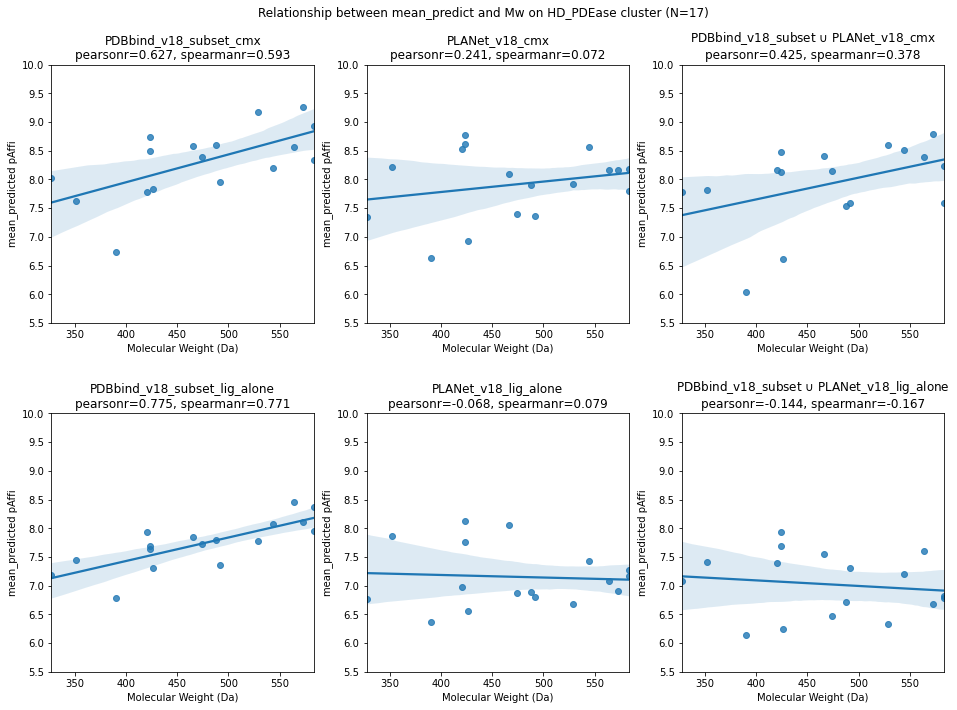

In [380]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(5.5,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["mw"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["mw"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and Mw on HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/Mw_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

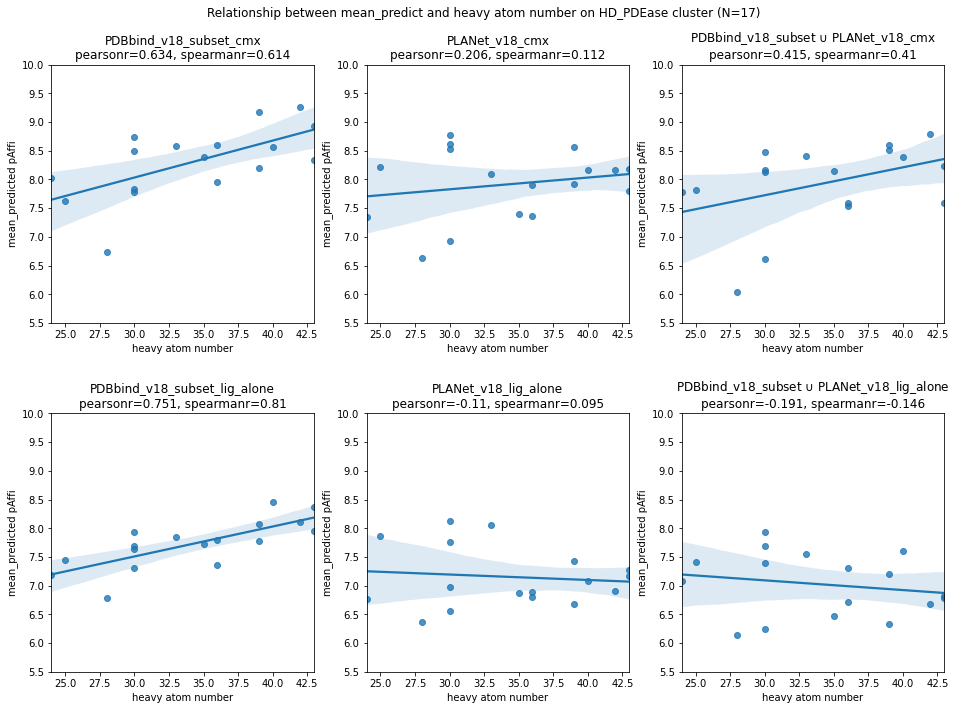

In [382]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='HA', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(5.5,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["HA"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["HA"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/HA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

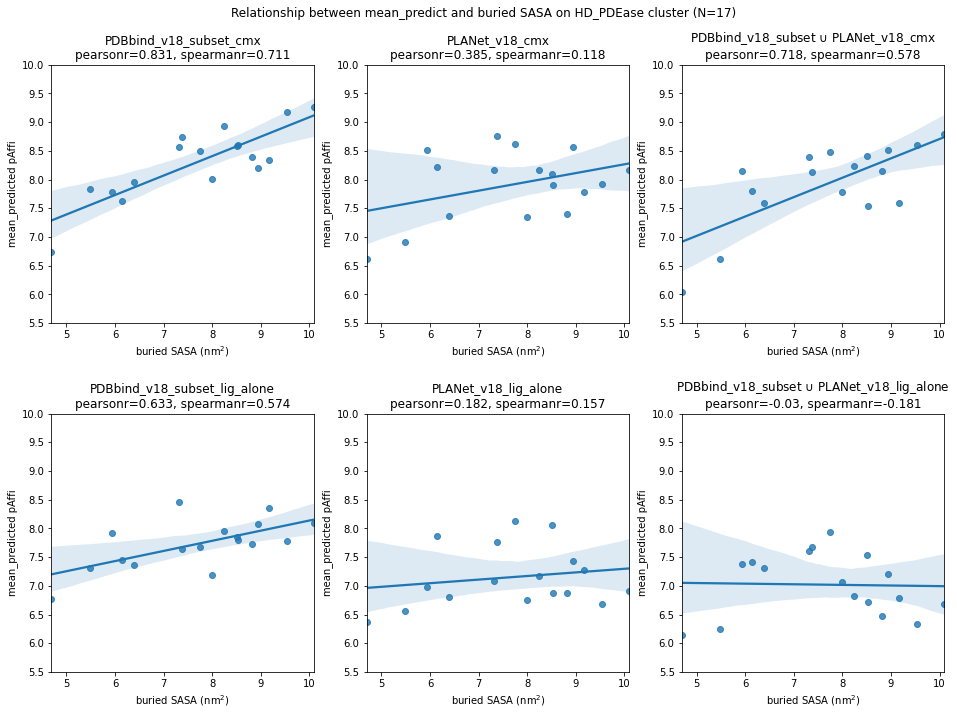

In [391]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='del_sasa', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(5.5,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["del_sasa"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["del_sasa"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and buried SASA on HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/SASA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

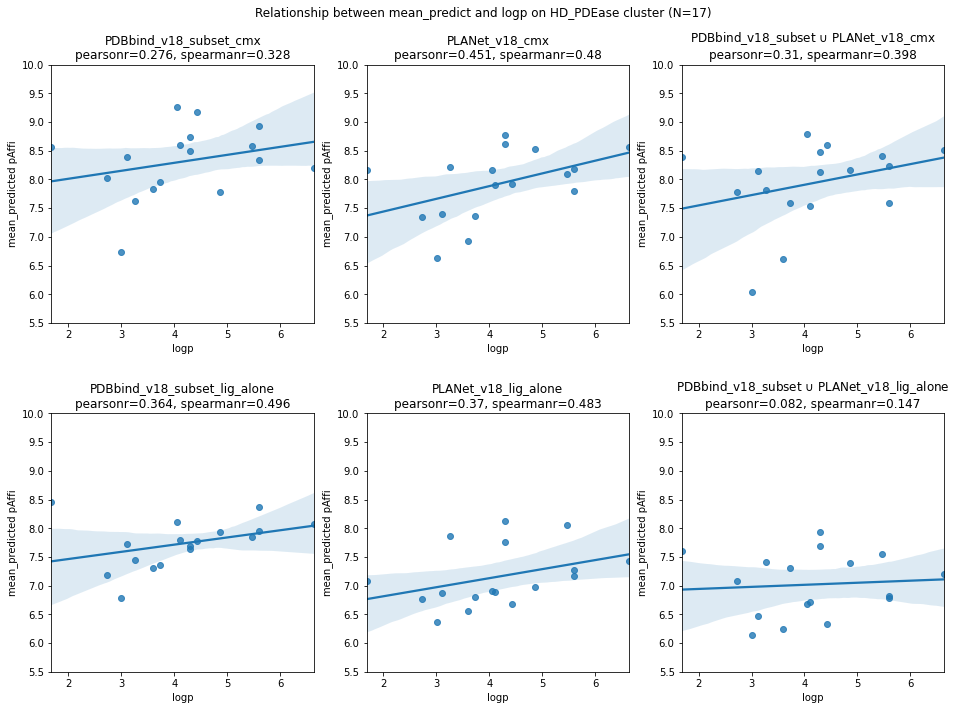

In [383]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='logp', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(5.5,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["logp"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hdpdease_mean_pred[f"{model}_{tp}_mean"], hold_out_hdpdease_mean_pred["logp"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and logp on HD_PDEase cluster (N={len(hold_out_hdpdease_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/HD_PDEase/logp_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

# AB_hydrolase

In [398]:
hold_out_abhydrolase_mean_pred = mean_pred_df_prop_sasa_pfam[mean_pred_df_prop_sasa_pfam['PCV_cluster']=='AB_hydrolase'].copy()
hold_out_abhydrolase_mean_pred

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
44             5nn0   10.96                               4.339872   
139            5ye7    5.46                               7.963439   
140            5ye8    3.00                               4.191432   
141            5ye9    6.45                               7.913512   
142            5yea    8.30                               7.387080   
170            5zun    9.19                               7.453549   
182            6ary    7.60                               5.505437   
183            6aum    9.10                               8.213192   
192            6b1o    8.51                               7.360301   
363            6f7q    8.96                               6.143881   
380            6fse    4.74                               6.917303   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
44                                      7.466100             5.188254   
139                                     7.098470             5.843468   
140                                     5.830879             4.541744   
141                                     7.251971             6.605575   
142                                     7.042354             7.878984   
170                                     7.387754             7.435534   
182                                     5.310438             5.855141   
183                                     7.706174             9.074303   
192                                     6.690040             7.724645   
363                                     7.322344             7.127286   
380                                     6.730049             5.004884   

     PLANet_v18_lig_alone_mean  \
44                    7.532173   
139                   5.459024   
140                   5.733981   
141                   5.738350   
142                   7.043801   
170                   6.576069   
182                   6.045510   
183                   8.454813   
192                   7.208015   
363                   6.918542   
380                   5.482595   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
44                                            5.354481        
139                                           7.014585        
140                                           4.089410        
141                                           7.494124        
142                                           7.956654        
170                                           7.026635        
182                                           5.633498        
183                                           8.773548        
192                                           7.791320        
363                                           6.665729        
380                                           4.971235        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
44                                            7.766486              
139                                           6.399173              
140                                           5.391368              
141                                           6.901887              
142                                           6.956427              
170                                           6.279537              
182                                           5.922881              
183                                           8.603530              
192                                           7.753662              
363                                           6.610658              
380                                           6.091871              

     d(PLANet_cmx-PDBbind_cmx)       mw  ...  rotb  hbd  hba    q    HA  \
44                    0.848382  457.662  ...   7.0  2.0  1.0  2.0  34.0   
139                   2.119971  432.501  ...   6.0  2.0  4.0  0.0  31.0   
140                   0.350312  207.201  ...   2.0  1.0  2.0  0.0 

In [400]:
hold_out_abhydrolase_mean_pred_melted = hold_out_abhydrolase_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')

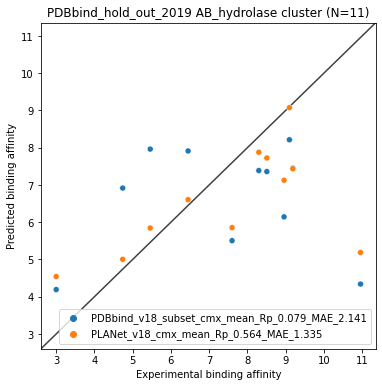

In [405]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=hold_out_abhydrolase_mean_pred_melted, x="y_true", y="value", hue='model')
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{round(stats.pearsonr(hold_out_abhydrolase_mean_pred["y_true"], hold_out_abhydrolase_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_abhydrolase_mean_pred[f"y_true"], hold_out_abhydrolase_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{round(stats.pearsonr(hold_out_abhydrolase_mean_pred["y_true"], hold_out_abhydrolase_mean_pred["PLANet_v18_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_abhydrolase_mean_pred[f"y_true"], hold_out_abhydrolase_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/AB_hydrolase_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')

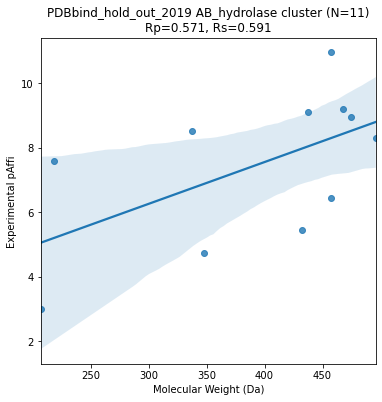

In [406]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_abhydrolase_mean_pred, x="mw", y="y_true")

plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_abhydrolase_mean_pred["mw"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_abhydrolase_mean_pred["mw"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/AB_hydrolase_scatter_Mw_experimental_pAffi.png', dpi=300, bbox_inches='tight')

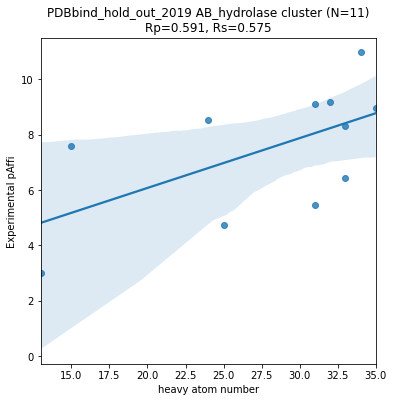

In [407]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_abhydrolase_mean_pred, x="HA", y="y_true")

plt.xlabel("heavy atom number")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_abhydrolase_mean_pred["HA"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_abhydrolase_mean_pred["HA"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/AB_hydrolase_scatter_HA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

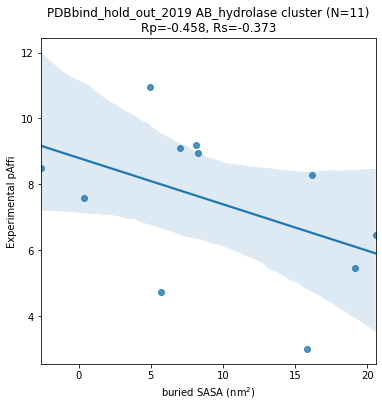

In [408]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_abhydrolase_mean_pred, x="del_sasa", y="y_true")

plt.xlabel("buried SASA (nm$\mathregular{^2}$)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_abhydrolase_mean_pred["del_sasa"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_abhydrolase_mean_pred["del_sasa"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/AB_hydrolase_scatter_SASA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

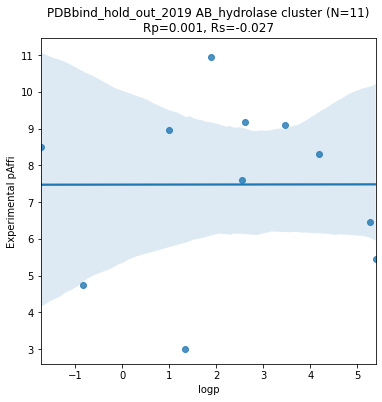

In [409]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_abhydrolase_mean_pred, x="logp", y="y_true")

plt.xlabel("logp")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_abhydrolase_mean_pred["logp"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_abhydrolase_mean_pred["logp"], hold_out_abhydrolase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/AB_hydrolase_scatter_logp_experimental_pAffi.png', dpi=300, bbox_inches='tight')

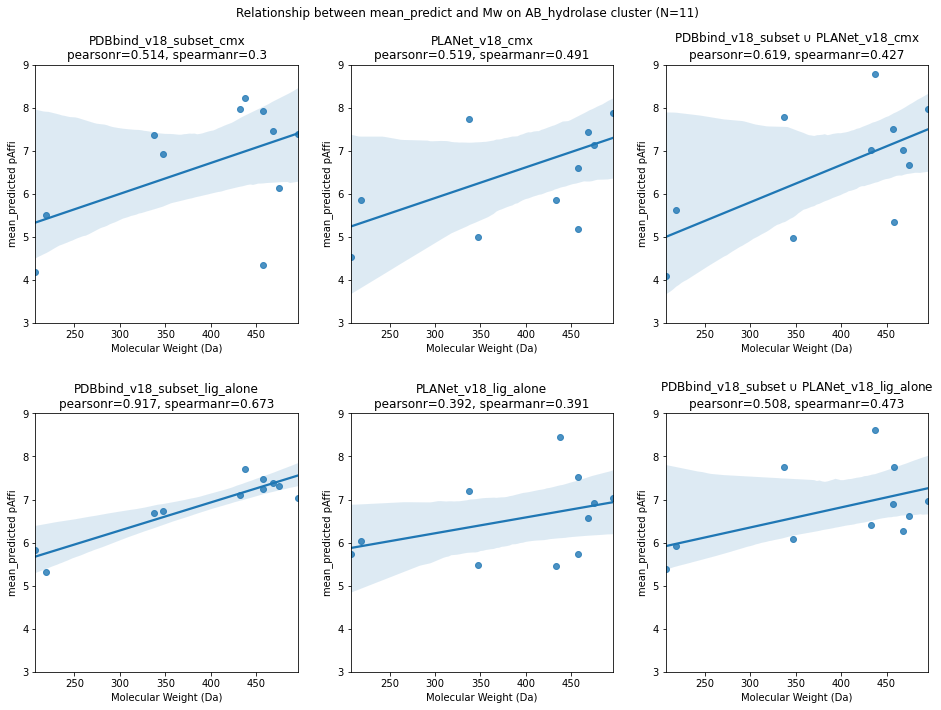

In [412]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_abhydrolase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["mw"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["mw"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and Mw on AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/Mw_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

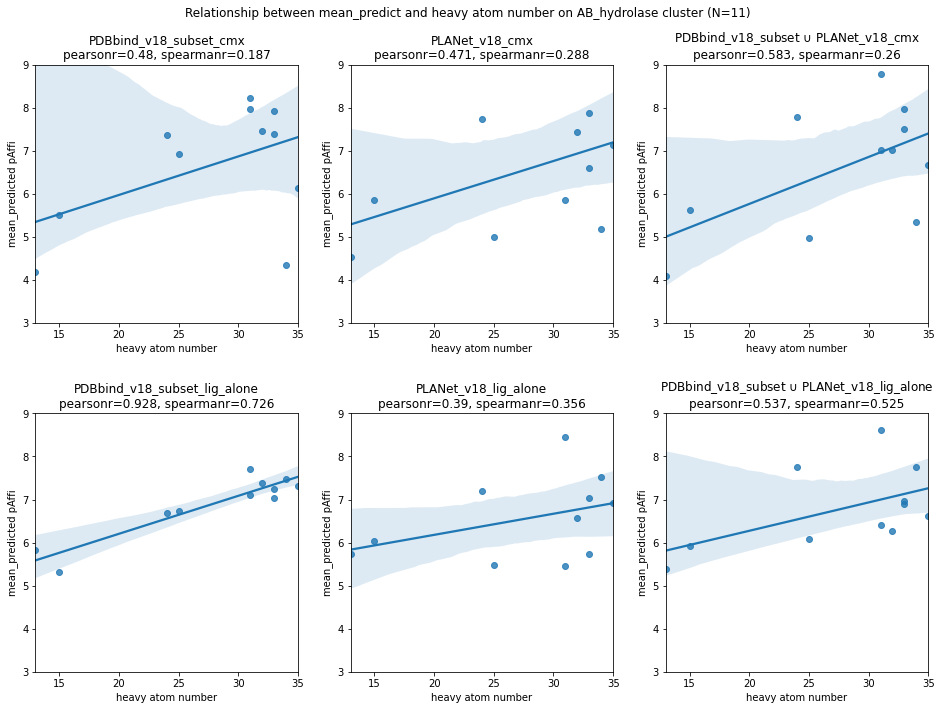

In [413]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='HA', y=f'{model}_{tp}_mean', data=hold_out_abhydrolase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["HA"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["HA"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/HA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

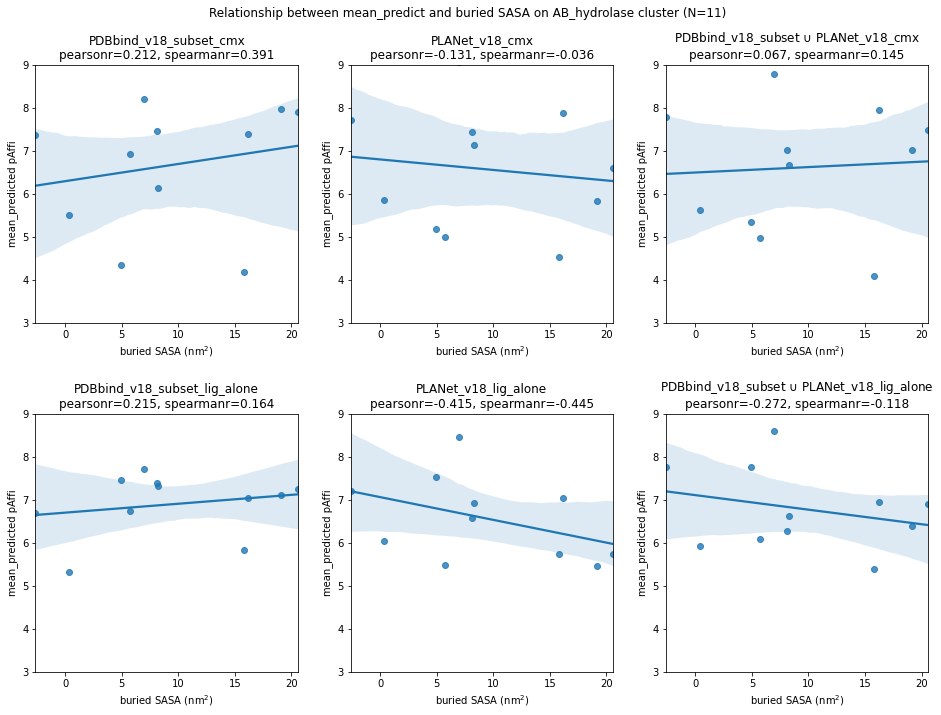

In [414]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='del_sasa', y=f'{model}_{tp}_mean', data=hold_out_abhydrolase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["del_sasa"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["del_sasa"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and buried SASA on AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/SASA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

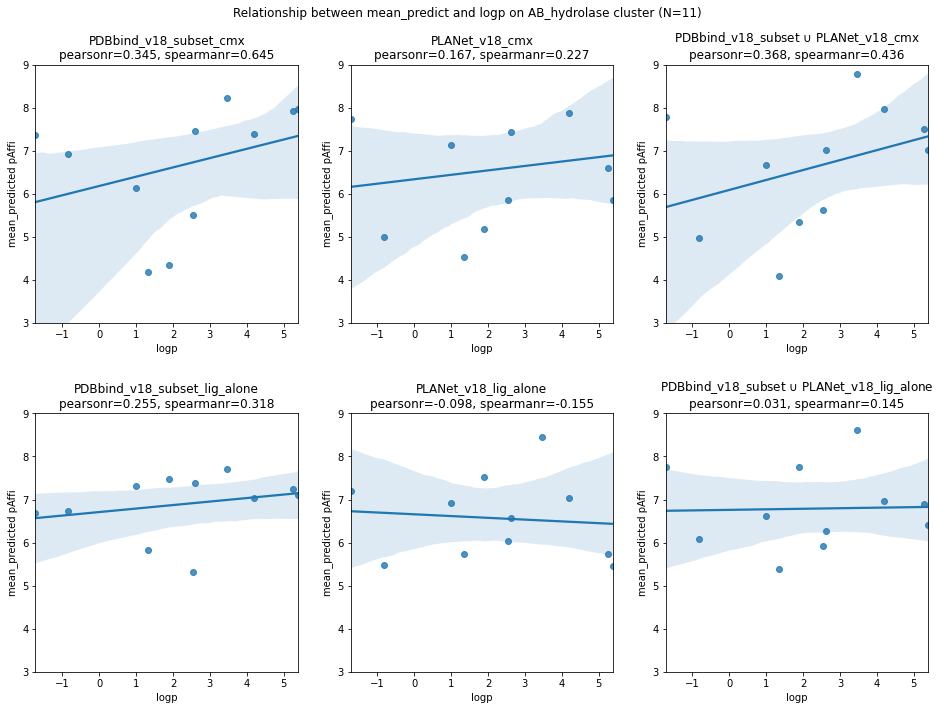

In [415]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='logp', y=f'{model}_{tp}_mean', data=hold_out_abhydrolase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["logp"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_abhydrolase_mean_pred[f"{model}_{tp}_mean"], hold_out_abhydrolase_mean_pred["logp"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and logp on AB_hydrolase cluster (N={len(hold_out_abhydrolase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/AB_hydrolase/logp_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

# P53-like

In [416]:
hold_out_p53like_mean_pred = mean_pred_df_prop_sasa_pfam[mean_pred_df_prop_sasa_pfam['PCV_cluster']=='P53-like'].copy()
hold_out_p53like_mean_pred

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
55            5o1a    4.52                               6.457995   
56            5o1b    4.70                               5.323044   
57            5o1c    3.95                               5.928838   
58            5o1d    4.66                               6.038726   
59            5o1e    4.48                               5.660220   
60            5o1f    4.52                               6.003012   
61            5o1h    4.85                               6.029898   
62            5o1i    5.40                               7.493425   

    PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
55                                     7.150183             4.725118   
56                                     6.411172             4.307718   
57                                     6.954997             5.918157   
58                                     6.156137             4.272268   
59                                     6.141131             4.449686   
60                                     6.162184             4.692666   
61                                     6.145538             4.930928   
62                                     7.526984             5.231322   

    PLANet_v18_lig_alone_mean  \
55                   6.104350   
56                   6.060204   
57                   6.480055   
58                   6.129116   
59                   5.937140   
60                   6.050576   
61                   6.190423   
62                   6.686304   

    PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
55                                           4.779778        
56                                           3.750443        
57                                           5.803060        
58                                           4.873248        
59                                           4.791575        
60                                           4.877429        
61                                           5.257705        
62                                           6.484726        

    PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
55                                           5.400787              
56                                           4.289716              
57                                           6.624538              
58                                           5.590054              
59                                           5.359791              
60                                           5.720440              
61                                           5.215319              
62                                           6.288955              

    d(PLANet_cmx-PDBbind_cmx)       mw  ...  rotb  hbd  hba    q    HA  \
55                   1.732877  538.147  ...   2.0  2.0  3.0  1.0  23.0   
56                   1.015326  441.006  ...   2.0  2.0  3.0  0.0  16.0   
57                   0.010681  422.173  ...   3.0  1.0  4.0 -1.0  23.0   
58                   1.766458  386.165  ...   5.0  1.0  5.0 -1.0  20.0   
59                   1.210534  384.149  ...   5.0  1.0  5.0 -1.0  20.0   
60                   1.310347  400.192  ...   6.0  1.0  5.0 -1.0  21.0   
61                   1.098970  402.233  ...   5.0  1.0  5.0 -1.0  20.0   
62                   2.262103  456.285  ...   5.0  1.0  7.0 -1.0  24.0   

    lig_sasa    rec_sasa    com_sasa   del_sasa  PCV_cluster  
55  5.957557  104.368721   99.304916  11.021362     P53-like  
56  4.555434  106.946922   98.939743  12.562614     P53-like  
57  5.343790  106.851334   99.497177  12.697945     P53-like  
58  5.140255  106.179398  100.189438  11.130219     P53-like  
59  5.140731  106.560593   99.292931  12.408394     P53-like  
60  5.523054  104.843468   98.957336  11.409187     P53-like  
61  5.281420  106.011307   98.598625  12.694099     P53-like  
62  5.840074  104.831551   98.252876  12.418747     P53-like  

[8 rows x 21 columns]

In [419]:
lims

[3.8775000000000004, 7.654483120441437]

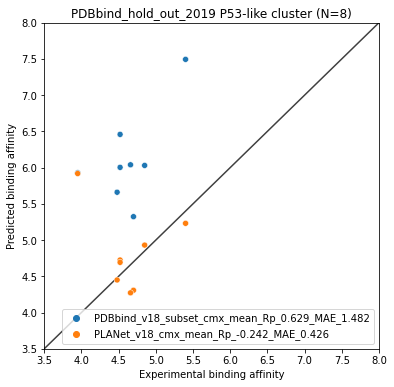

In [424]:
hold_out_p53like_mean_pred_melted = hold_out_p53like_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=hold_out_p53like_mean_pred_melted, x="y_true", y="value", hue='model')
# lims = [
#         np.min([ax.get_xlim(), ax.get_ylim()]),
#         np.max([ax.get_xlim(), ax.get_ylim()]),
#     ]
lims=[3.5,8]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 P53-like cluster (N={len(hold_out_p53like_mean_pred)})')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{round(stats.pearsonr(hold_out_p53like_mean_pred["y_true"], hold_out_p53like_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_p53like_mean_pred[f"y_true"], hold_out_p53like_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{round(stats.pearsonr(hold_out_p53like_mean_pred["y_true"], hold_out_p53like_mean_pred["PLANet_v18_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_p53like_mean_pred[f"y_true"], hold_out_p53like_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/P53-like_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')

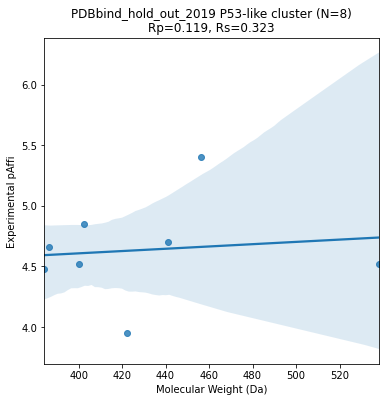

In [425]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_p53like_mean_pred, x="mw", y="y_true")

plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 P53-like cluster (N={len(hold_out_p53like_mean_pred)})\nRp={round(stats.pearsonr(hold_out_p53like_mean_pred["mw"], hold_out_p53like_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_p53like_mean_pred["mw"], hold_out_p53like_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/P53-like_scatter_Mw_experimental_pAffi.png', dpi=300, bbox_inches='tight')

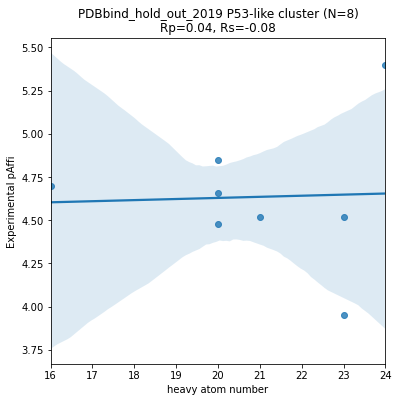

In [426]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_p53like_mean_pred, x="HA", y="y_true")

plt.xlabel("heavy atom number")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 P53-like cluster (N={len(hold_out_p53like_mean_pred)})\nRp={round(stats.pearsonr(hold_out_p53like_mean_pred["HA"], hold_out_p53like_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_p53like_mean_pred["HA"], hold_out_p53like_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/P53-like_scatter_HA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

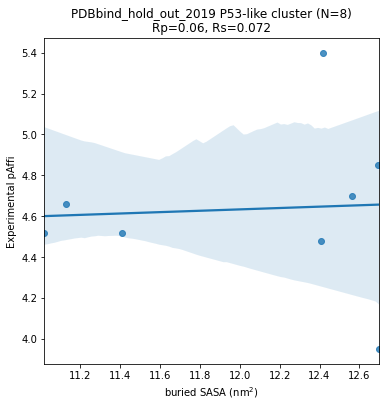

In [427]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_p53like_mean_pred, x="del_sasa", y="y_true")

plt.xlabel("buried SASA (nm$\mathregular{^2}$)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 P53-like cluster (N={len(hold_out_p53like_mean_pred)})\nRp={round(stats.pearsonr(hold_out_p53like_mean_pred["del_sasa"], hold_out_p53like_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_p53like_mean_pred["del_sasa"], hold_out_p53like_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/P53-like_scatter_SASA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

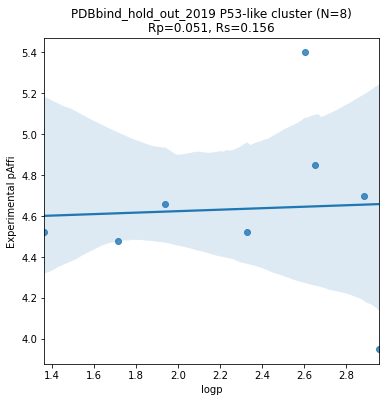

In [428]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_p53like_mean_pred, x="logp", y="y_true")

plt.xlabel("logp")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 P53-like cluster (N={len(hold_out_p53like_mean_pred)})\nRp={round(stats.pearsonr(hold_out_p53like_mean_pred["logp"], hold_out_p53like_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_p53like_mean_pred["logp"], hold_out_p53like_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/P53-like_scatter_logp_experimental_pAffi.png', dpi=300, bbox_inches='tight')

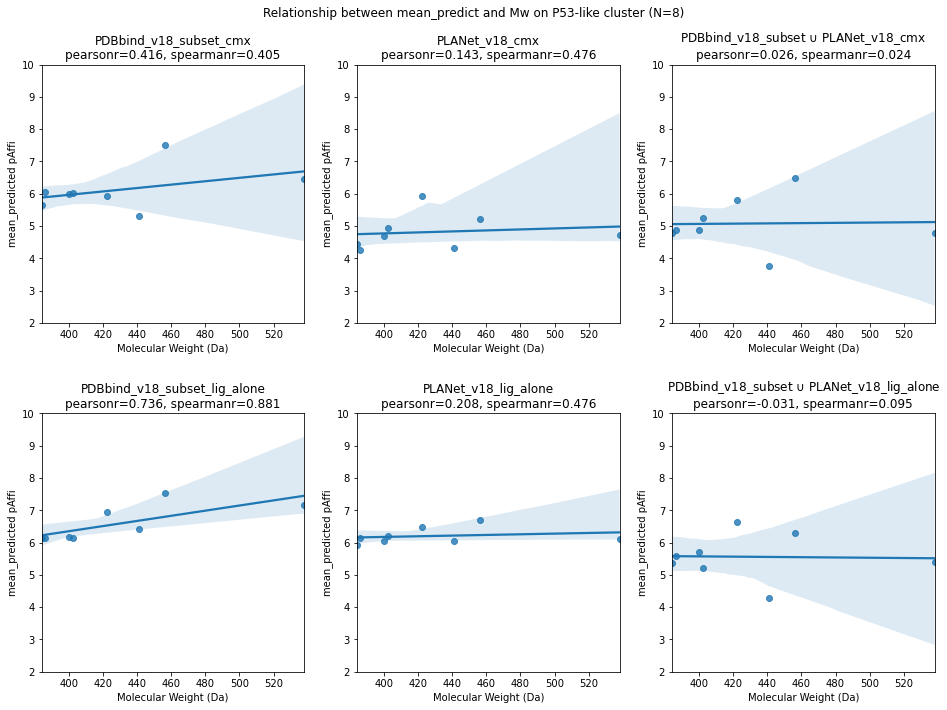

In [432]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_p53like_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(2,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["mw"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["mw"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and Mw on P53-like cluster (N={len(hold_out_p53like_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/Mw_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

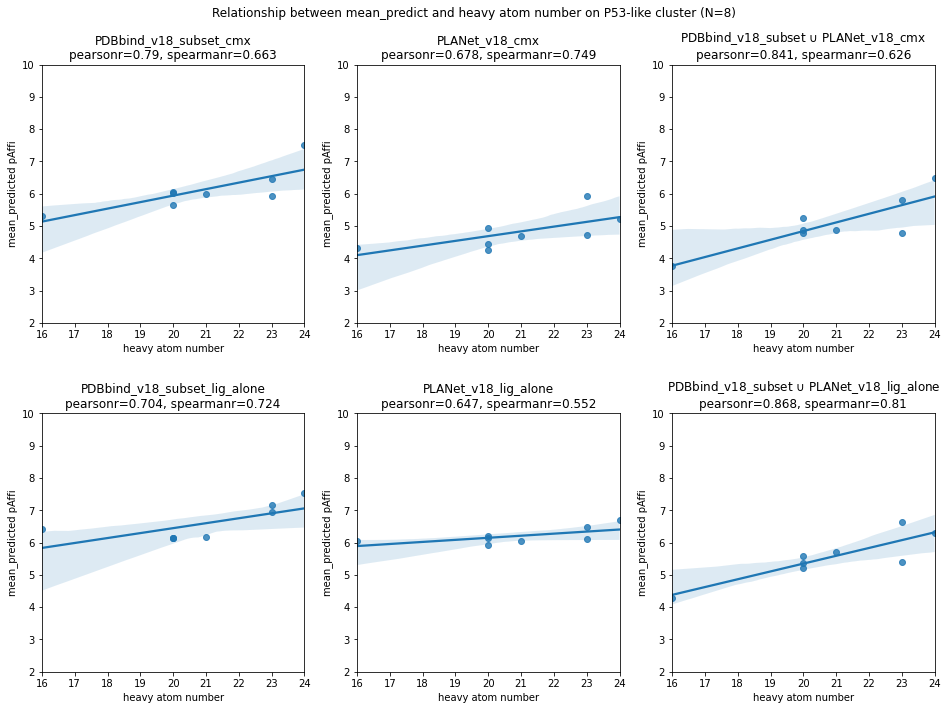

In [433]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='HA', y=f'{model}_{tp}_mean', data=hold_out_p53like_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(2,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["HA"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["HA"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on P53-like cluster (N={len(hold_out_p53like_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/HA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

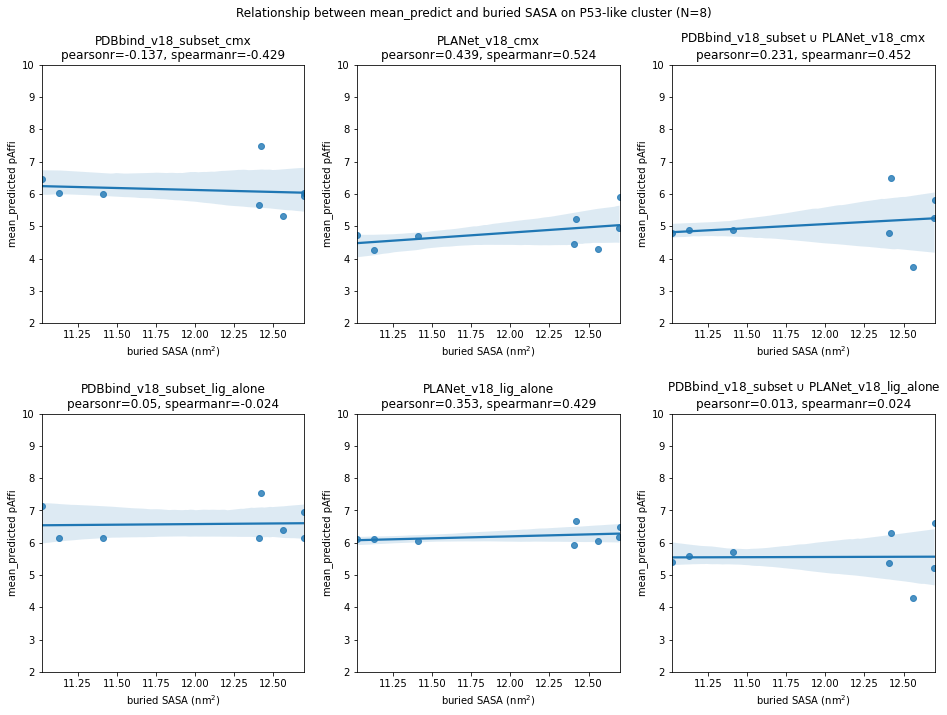

In [434]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='del_sasa', y=f'{model}_{tp}_mean', data=hold_out_p53like_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(2,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["del_sasa"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["del_sasa"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and buried SASA on P53-like cluster (N={len(hold_out_p53like_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/SASA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

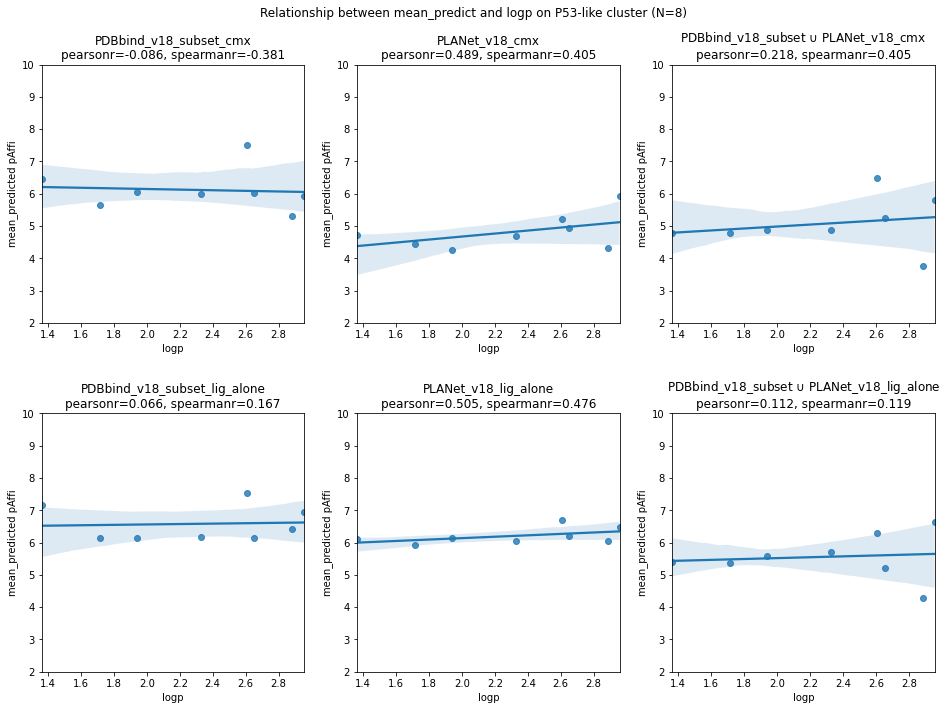

In [435]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='logp', y=f'{model}_{tp}_mean', data=hold_out_p53like_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(2,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["logp"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_p53like_mean_pred[f"{model}_{tp}_mean"], hold_out_p53like_mean_pred["logp"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and logp on P53-like cluster (N={len(hold_out_p53like_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/P53-like/logp_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

# hormone_recep

In [441]:
# len(PDBbind_hold_prop_sasa_Pfam[PDBbind_hold_prop_sasa_Pfam['PCV_cluster'] == 'hormone_recep'])

21

In [436]:
hold_out_hormone_recep_mean_pred = mean_pred_df_prop_sasa_pfam[mean_pred_df_prop_sasa_pfam['PCV_cluster']=='hormone_recep'].copy()
hold_out_hormone_recep_mean_pred

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
36             5mwp    7.50                               7.417083   
37             5mwy    7.00                               8.489872   
40             5ni7    7.70                               7.067653   
41             5ni8    7.70                               7.209470   
42             5nib    7.72                               7.302048   
117            5xmx    7.24                               6.954647   
147            5yp5    4.60                               7.462332   
148            5yp6    4.60                               7.791577   
154            5za1    7.52                               6.779179   
179            6an1    5.35                               6.547162   
196            6b31    8.44                               8.629776   
225            6br2    8.72                               7.806741   
226            6br3    8.72                               8.644611   
237            6c5q    6.66                               7.699571   
238            6c5t    6.97                               7.675460   
272            6cn5    7.70                               8.360522   
273            6cn6    8.30                               8.430095   
334            6esn    8.05                               7.360120   
391            6fzu    3.67                               4.322164   
392            6g07    4.57                               6.855659   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
36                                      7.151654             8.064823   
37                                      7.269439             7.435955   
40                                      7.411215             6.179134   
41                                      7.489245             6.159034   
42                                      7.504539             6.665764   
117                                     7.102107             7.123846   
147                                     7.500779             7.111246   
148                                     7.817606             7.972029   
154                                     7.506602             6.372633   
179                                     6.195687             5.689925   
196                                     7.419364             6.292456   
225                                     7.527861             7.401314   
226                                     7.491361             7.889153   
237                                     7.671079             6.415989   
238                                     7.750371             6.010526   
272                                     7.515417             7.139218   
273                                     7.499397             6.498973   
334                                     7.570253             6.341283   
391                                     3.920663             3.852314   
392                                     7.271884             6.539034   

     PLANet_v18_lig_alone_mean  \
36                    6.693977   
37                    7.966521   
40                    7.128542   
41                    6.832684   
42                    7.369556   
117                   7.114963   
147                   6.709280   
148                   7.453285   
154                   7.191824   
179                   5.959377   
196                   7.290492   
225                   6.395906   
226                   7.640565   
237                   7.067511   
238                   7.226159   
272                   6.723895   
273                   6.378704   
334                   7.261189   
391                   4.422191   
392                   6.629683   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
36                                            6.927988        
37                                            6.749628        
40                                            6.016480        
41                              

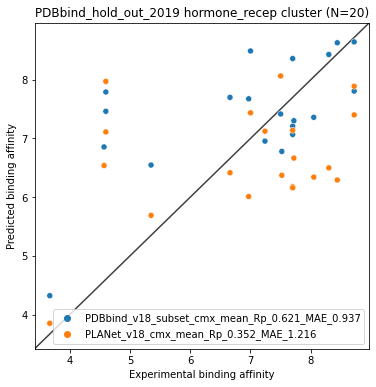

In [449]:
hold_out_hormone_recep_mean_pred_melted = hold_out_hormone_recep_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=hold_out_hormone_recep_mean_pred_melted, x="y_true", y="value", hue='model')
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
# lims=[3.5,8]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{round(stats.pearsonr(hold_out_hormone_recep_mean_pred["y_true"], hold_out_hormone_recep_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_hormone_recep_mean_pred[f"y_true"], hold_out_hormone_recep_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{round(stats.pearsonr(hold_out_hormone_recep_mean_pred["y_true"], hold_out_hormone_recep_mean_pred["PLANet_v18_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_hormone_recep_mean_pred[f"y_true"], hold_out_hormone_recep_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='lower right')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/hormone_recep_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')

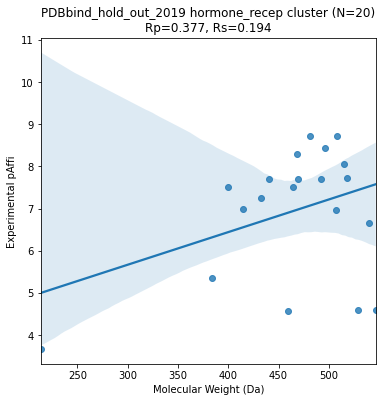

In [450]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hormone_recep_mean_pred, x="mw", y="y_true")

plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hormone_recep_mean_pred["mw"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hormone_recep_mean_pred["mw"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/hormone_recep_scatter_Mw_experimental_pAffi.png', dpi=300, bbox_inches='tight')

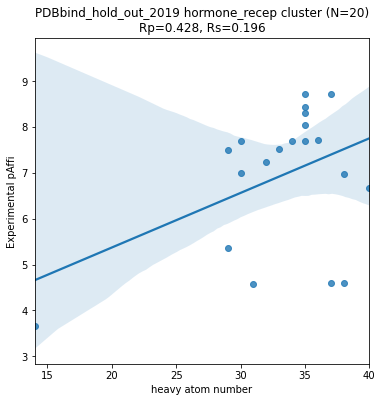

In [451]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hormone_recep_mean_pred, x="HA", y="y_true")

plt.xlabel("heavy atom number")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hormone_recep_mean_pred["HA"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hormone_recep_mean_pred["HA"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/hormone_recep_scatter_HA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

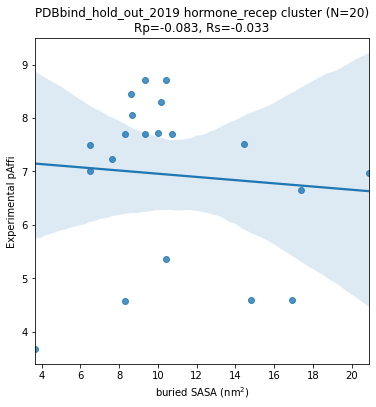

In [452]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hormone_recep_mean_pred, x="del_sasa", y="y_true")

plt.xlabel("buried SASA (nm$\mathregular{^2}$)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hormone_recep_mean_pred["del_sasa"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hormone_recep_mean_pred["del_sasa"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/hormone_recep_scatter_SASA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

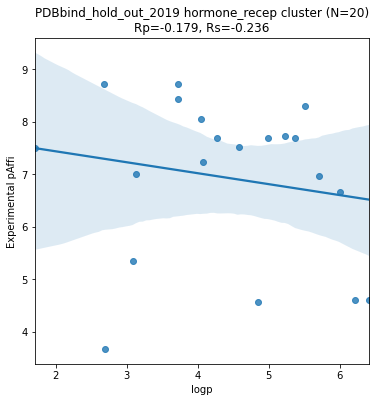

In [453]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_hormone_recep_mean_pred, x="logp", y="y_true")

plt.xlabel("logp")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})\nRp={round(stats.pearsonr(hold_out_hormone_recep_mean_pred["logp"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_hormone_recep_mean_pred["logp"], hold_out_hormone_recep_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/hormone_recep_scatter_logp_experimental_pAffi.png', dpi=300, bbox_inches='tight')

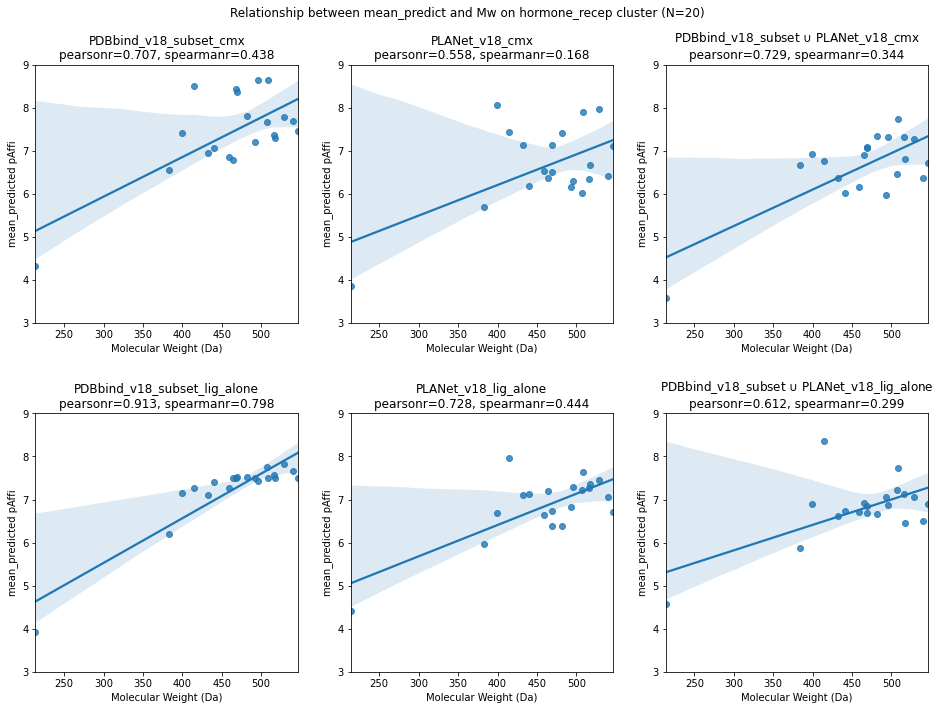

In [456]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hormone_recep_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["mw"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["mw"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and Mw on hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/Mw_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

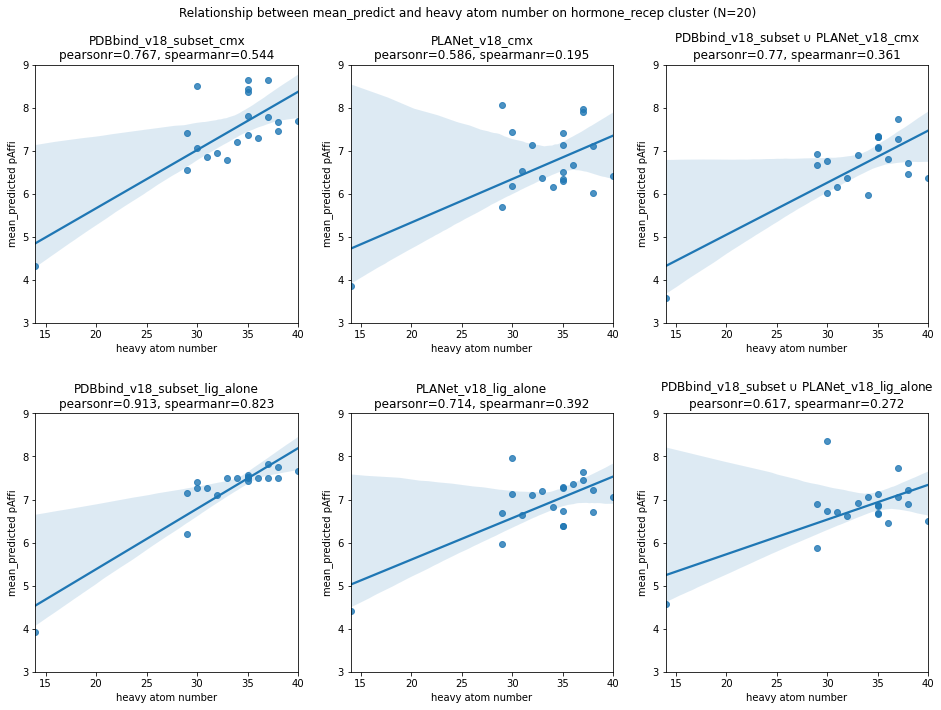

In [457]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='HA', y=f'{model}_{tp}_mean', data=hold_out_hormone_recep_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["HA"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["HA"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/HA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

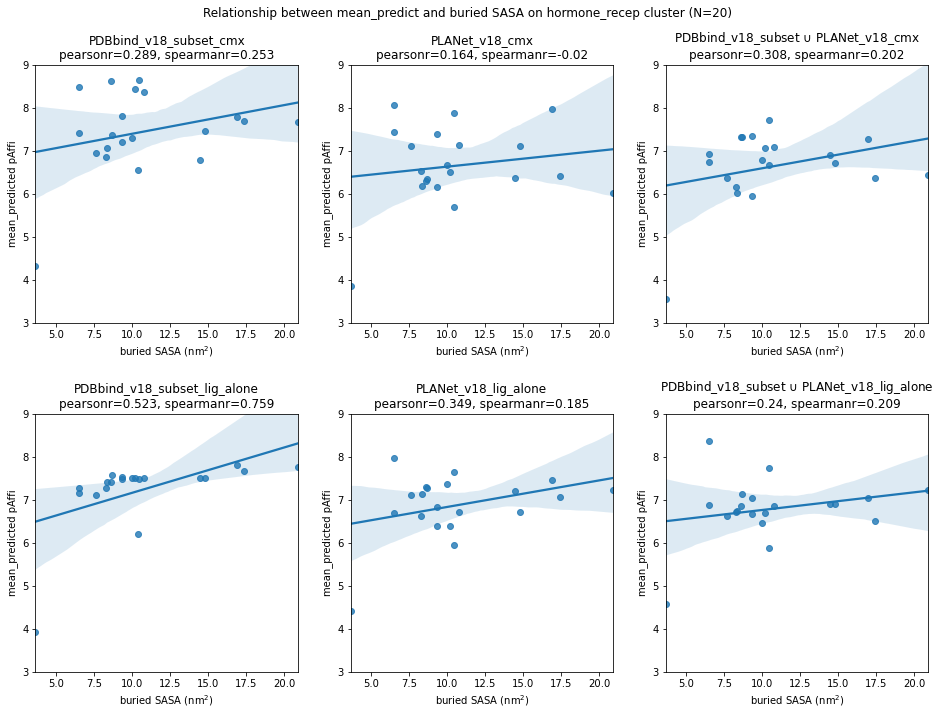

In [458]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='del_sasa', y=f'{model}_{tp}_mean', data=hold_out_hormone_recep_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["del_sasa"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["del_sasa"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and buried SASA on hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/SASA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

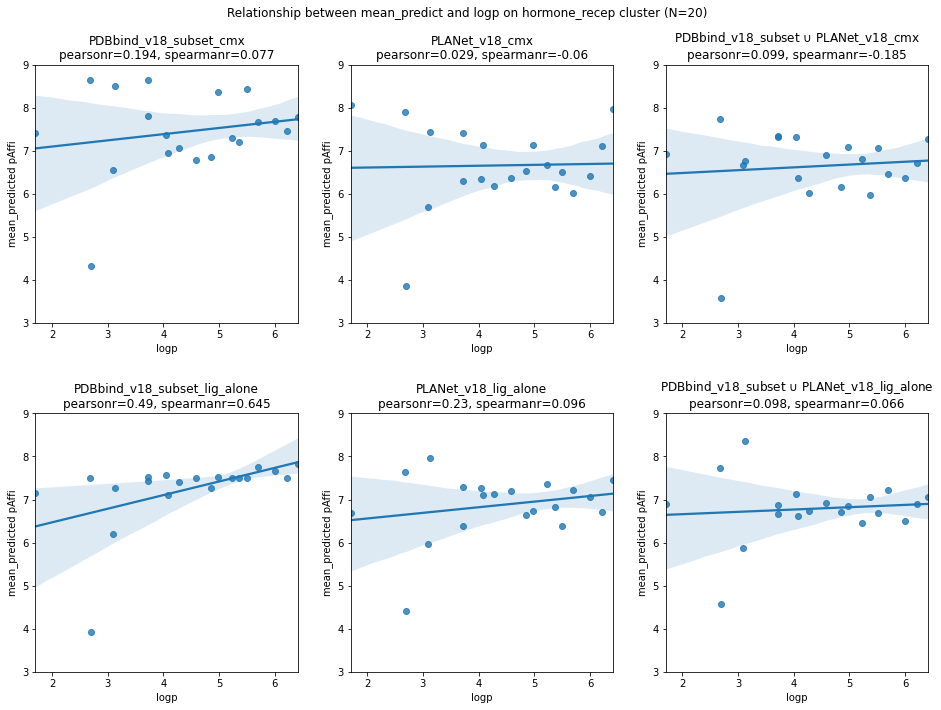

In [459]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='logp', y=f'{model}_{tp}_mean', data=hold_out_hormone_recep_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(3,9)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["logp"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_hormone_recep_mean_pred[f"{model}_{tp}_mean"], hold_out_hormone_recep_mean_pred["logp"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and logp on hormone_recep cluster (N={len(hold_out_hormone_recep_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/hormone_recep/logp_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

# pkinase

In [460]:
hold_out_pkinase_mean_pred = mean_pred_df_prop_sasa_pfam[mean_pred_df_prop_sasa_pfam['PCV_cluster']=='pkinase'].copy()
hold_out_pkinase_mean_pred

unique_identify  y_true  PDBbind_minimized_v18_subset_cmx_mean  \
2              5fxq    7.85                               7.675058   
3              5fxs    8.05                               7.410508   
9              5hvu    7.89                               8.007788   
19             5kks    8.70                               8.265381   
20             5kkt    9.00                               8.359003   
..              ...     ...                                    ...   
453            6hjk    7.60                               8.343732   
456            6hm6    5.50                               5.480788   
457            6hm7    7.10                               7.686818   
458            6hmx    8.89                               8.626806   
479            6mx8    9.43                               7.895870   

     PDBbind_minimized_v18_subset_lig_alone_mean  PLANet_v18_cmx_mean  \
2                                       8.337734             6.231024   
3                                       8.598834             7.421319   
9                                       7.572141             6.825363   
19                                      7.177957             7.321736   
20                                      7.802241             7.603434   
..                                           ...                  ...   
453                                     7.785273             6.955029   
456                                     5.832794             5.751941   
457                                     7.079657             6.624603   
458                                     7.493965             7.797657   
479                                     7.646135             8.449475   

     PLANet_v18_lig_alone_mean  \
2                     8.289605   
3                     8.355122   
9                     7.456814   
19                    6.868789   
20                    7.308927   
..                         ...   
453                   7.004574   
456                   6.197823   
457                   6.633228   
458                   7.607253   
479                   8.546027   

     PDBbind_minimized_v18_subset_union_PLANet_v18_cmx_mean  \
2                                             6.583290        
3                                             7.449681        
9                                             6.965334        
19                                            7.135947        
20                                            7.259992        
..                                                 ...        
453                                           7.689144        
456                                           5.498020        
457                                           7.008013        
458                                           7.919997        
479                                           8.239832        

     PDBbind_minimized_v18_subset_union_PLANet_v18_lig_alone_mean  \
2                                             7.886528              
3                                             8.070054              
9                                             7.326709              
19                                            7.338792              
20                                            7.268287              
..                                                 ...              
453                                           7.063674              
456                                           6.234088              
457                                           6.606894              
458                                           7.344821              
479                                           8.388421              

     d(PLANet_cmx-PDBbind_cmx)       mw  ...  rotb  hbd  hba    q    HA  \
2                     1.444034  409.905  ...   4.0  2.0  7.0  1.0  29.0   
3                     0.010811  509.038  ...   6.0  2.0  8.0  1.0  36.0   
9                     1.182425  437.589  ...   9.0  2.0  5.0  1.0 

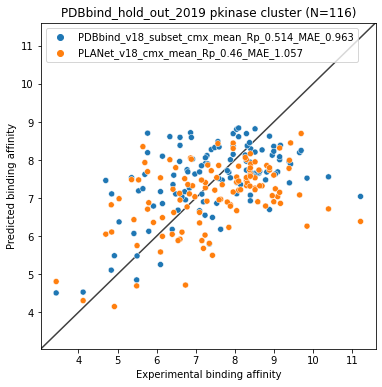

In [462]:
hold_out_pkinase_mean_pred_melted = hold_out_pkinase_mean_pred[['unique_identify', 'y_true', 'PDBbind_minimized_v18_subset_cmx_mean', 'PLANet_v18_cmx_mean']].melt(id_vars=['unique_identify', 'y_true'], var_name='model')

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=hold_out_pkinase_mean_pred_melted, x="y_true", y="value", hue='model')
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
# lims=[3.5,8]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
plt.xlabel("Experimental binding affinity")
plt.ylabel("Predicted binding affinity")
plt.title(f'PDBbind_hold_out_2019 pkinase cluster (N={len(hold_out_pkinase_mean_pred)})')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
ax.legend(handles[:2], [f'PDBbind_v18_subset_cmx_mean_Rp_{round(stats.pearsonr(hold_out_pkinase_mean_pred["y_true"], hold_out_pkinase_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_pkinase_mean_pred[f"y_true"], hold_out_pkinase_mean_pred["PDBbind_minimized_v18_subset_cmx_mean"]), 3)}', f'PLANet_v18_cmx_mean_Rp_{round(stats.pearsonr(hold_out_pkinase_mean_pred["y_true"], hold_out_pkinase_mean_pred["PLANet_v18_cmx_mean"])[0], 3)}_MAE_{round(mean_absolute_error(hold_out_pkinase_mean_pred[f"y_true"], hold_out_pkinase_mean_pred["PLANet_v18_cmx_mean"]), 3)}'], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/pkinase_scatter_PLANet_vs_PIP_cmx_mean.png', dpi=300, bbox_inches='tight')

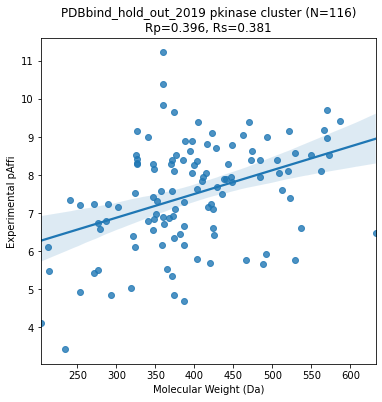

In [463]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_pkinase_mean_pred, x="mw", y="y_true")

plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 pkinase cluster (N={len(hold_out_pkinase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_pkinase_mean_pred["mw"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_pkinase_mean_pred["mw"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/pkinase_scatter_Mw_experimental_pAffi.png', dpi=300, bbox_inches='tight')

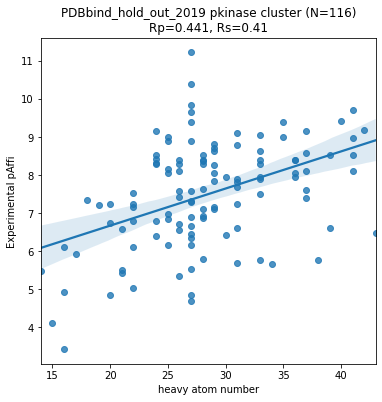

In [464]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_pkinase_mean_pred, x="HA", y="y_true")

plt.xlabel("heavy atom number")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 pkinase cluster (N={len(hold_out_pkinase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_pkinase_mean_pred["HA"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_pkinase_mean_pred["HA"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/pkinase_scatter_HA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

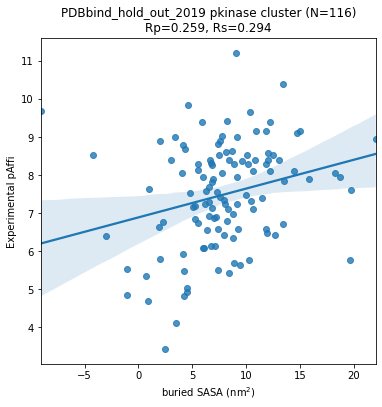

In [465]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_pkinase_mean_pred, x="del_sasa", y="y_true")

plt.xlabel("buried SASA (nm$\mathregular{^2}$)")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 pkinase cluster (N={len(hold_out_pkinase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_pkinase_mean_pred["del_sasa"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_pkinase_mean_pred["del_sasa"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/pkinase_scatter_SASA_experimental_pAffi.png', dpi=300, bbox_inches='tight')

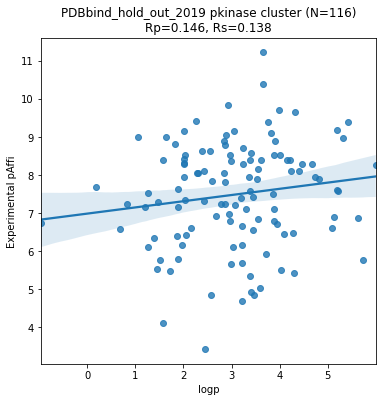

In [466]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(data=hold_out_pkinase_mean_pred, x="logp", y="y_true")

plt.xlabel("logp")
plt.ylabel("Experimental pAffi")
plt.title(f'PDBbind_hold_out_2019 pkinase cluster (N={len(hold_out_pkinase_mean_pred)})\nRp={round(stats.pearsonr(hold_out_pkinase_mean_pred["logp"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}, Rs={round(stats.spearmanr(hold_out_pkinase_mean_pred["logp"], hold_out_pkinase_mean_pred["y_true"])[0], 3)}')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], loc='upper left')
plt.savefig(f'/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/pkinase_scatter_logp_experimental_pAffi.png', dpi=300, bbox_inches='tight')

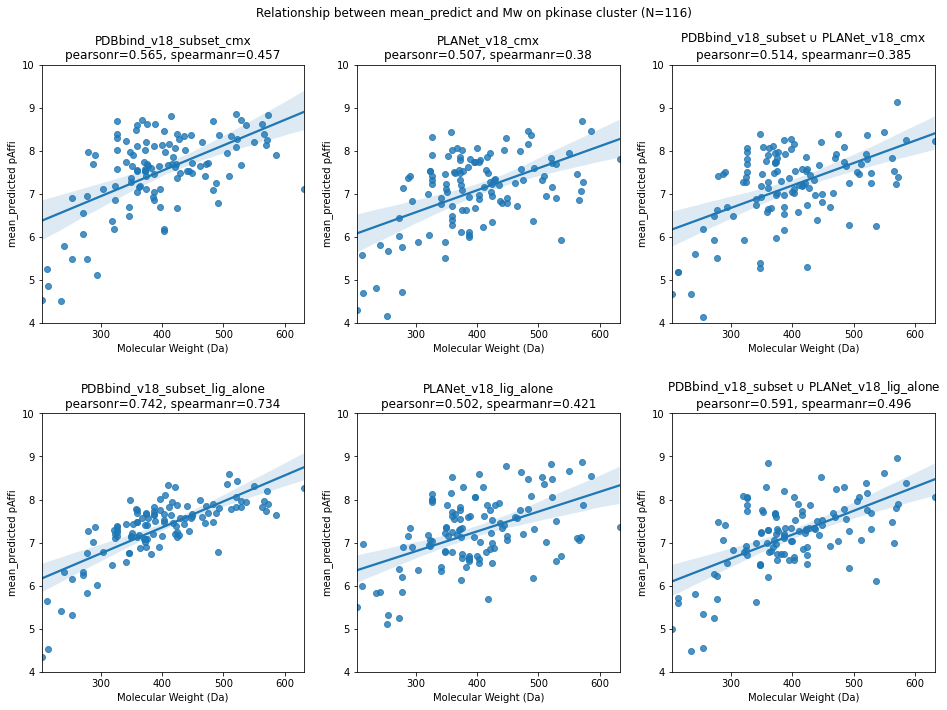

In [473]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_pkinase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(4,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('Molecular Weight (Da)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["mw"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["mw"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and Mw on pkinase cluster (N={len(hold_out_pkinase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/Mw_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

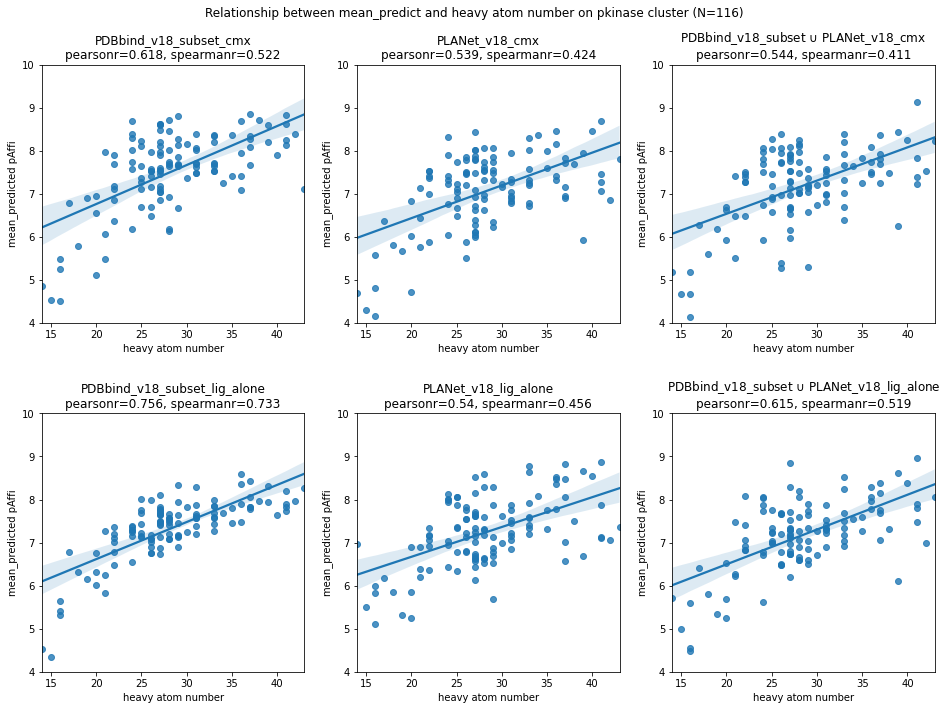

In [474]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='HA', y=f'{model}_{tp}_mean', data=hold_out_pkinase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(4,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('heavy atom number')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["HA"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["HA"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on pkinase cluster (N={len(hold_out_pkinase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/HA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

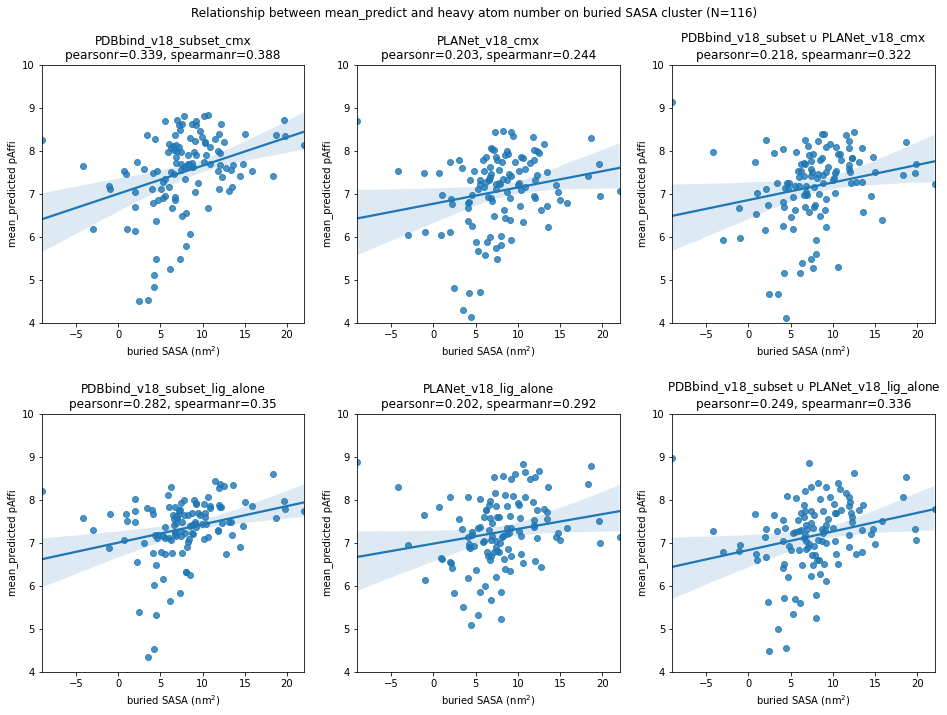

In [475]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='del_sasa', y=f'{model}_{tp}_mean', data=hold_out_pkinase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(4,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('buried SASA (nm$\mathregular{^2}$)')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["del_sasa"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["del_sasa"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on buried SASA cluster (N={len(hold_out_pkinase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/SASA_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')

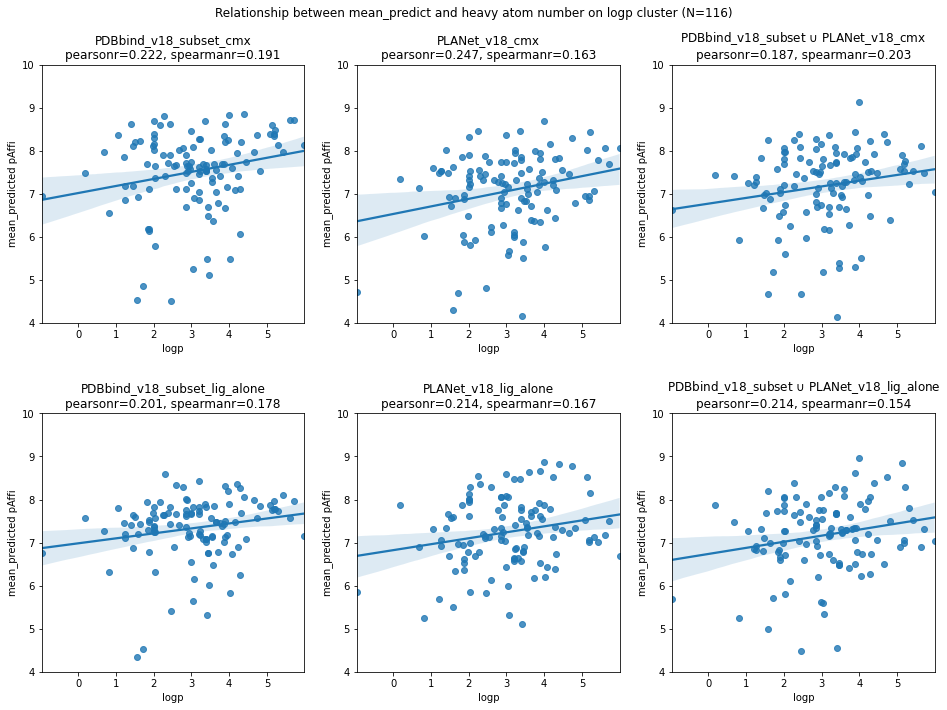

In [476]:
fig = plt.figure(figsize=(16,16))
for i, model in enumerate(models):
    for j, tp in enumerate(tps):
        # print((i+1)+6*j)
        ax = fig.add_subplot(3, 3, (i+1)+3*j)
        # fig, ax = plt.subplots(figsize=(6,6))
        # sns.scatterplot(x='mw', y=f'{model}_{tp}_mean', data=hold_out_hdpdease_mean_pred)
        sns.regplot(x='logp', y=f'{model}_{tp}_mean', data=hold_out_pkinase_mean_pred)

        # ax.set_xlim(0, 600)
        ax.set_ylim(4,10)
        ax.set_ylabel(f'mean_predicted pAffi')
        ax.set_xlabel('logp')
        ax.set_title(f'{simple_dict[model]}_{tp}\npearsonr={round(stats.pearsonr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["logp"])[0], 3)}, spearmanr={round(stats.spearmanr(hold_out_pkinase_mean_pred[f"{model}_{tp}_mean"], hold_out_pkinase_mean_pred["logp"])[0], 3)}')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.93, 
                    wspace=0.2, 
                    hspace=0.35)
plt.suptitle(f'Relationship between mean_predict and heavy atom number on logp cluster (N={len(hold_out_pkinase_mean_pred)})')
plt.savefig('/pubhome/xli02/project/PLIM/deep_learning/FAST/fast_plim/hold_out_2019/4-evaluation/test_on_PDBbind_hold_out_2019/mean_of_5_models/pfam_cluster/pkinase/logp_pred_pAffi_for_6_models.png', dpi=300, bbox_inches='tight')